# Sensitivity Analysis with the OpenCL RAMP model

### Import opencl modules

In [2]:
import multiprocessing as mp
import numpy as np
#import multiprocess as mp  # A fork of multiprocessing that uses dill rather than pickle
import yaml # pyyaml library for reading the parameters.yml file
import os

import matplotlib.pyplot as plt

from microsim.opencl.ramp.run import run_headless
from microsim.opencl.ramp.snapshot_convertor import SnapshotConvertor
from microsim.opencl.ramp.snapshot import Snapshot
from microsim.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
from microsim.opencl.ramp.simulator import Simulator
from microsim.opencl.ramp.disease_statuses import DiseaseStatus

import functions # Some additional notebook-specific functions required (functions.py)

# Useful for connecting to this kernel
%connect_info

{
  "shell_port": 60691,
  "iopub_port": 60692,
  "stdin_port": 60693,
  "control_port": 60695,
  "hb_port": 60694,
  "ip": "127.0.0.1",
  "key": "cee85a41-033024e8d4ee4be4aedf3daf",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-6e3560e0-1040-4067-86f2-7b05aae85ab9.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


### Setup params for all runs

Read the parameters file

In [3]:
PARAMETERS_FILENAME = "obesity.yml"
with open(os.path.join("..","model_parameters", PARAMETERS_FILENAME)) as f:
    parameters = yaml.load(f, Loader=yaml.SafeLoader)
    
sim_params = parameters["microsim"]  # Parameters for the dynamic microsim (python)
calibration_params = parameters["microsim_calibration"]
disease_params = parameters["disease"]  # Parameters for the disease model (r)

Prepare the parameters for the OpenCL model. (See [main.py](https://github.com/Urban-Analytics/RAMP-UA/blob/052861cc51be5bc1827c85bb827209f0df73c685/microsim/main.py#L262) for an example of how this is done in the code). 

In [4]:
current_risk_beta = disease_params['current_risk_beta']

# The OpenCL model incorporates the current risk beta by pre-multiplying the hazard multipliers with it
location_hazard_multipliers = LocationHazardMultipliers(
    retail=calibration_params["hazard_location_multipliers"]["Retail"] * current_risk_beta,
    primary_school=calibration_params["hazard_location_multipliers"]["PrimarySchool"] * current_risk_beta,
    secondary_school=calibration_params["hazard_location_multipliers"]["SecondarySchool"] * current_risk_beta,
    home=calibration_params["hazard_location_multipliers"]["Home"] * current_risk_beta,
    work=calibration_params["hazard_location_multipliers"]["Work"] * current_risk_beta,
)

# Individual hazard multipliers can be passed straight through
individual_hazard_multipliers = IndividualHazardMultipliers(
    presymptomatic=calibration_params["hazard_individual_multipliers"]["presymptomatic"],
    asymptomatic=calibration_params["hazard_individual_multipliers"]["asymptomatic"],
    symptomatic=calibration_params["hazard_individual_multipliers"]["symptomatic"]
)

proportion_asymptomatic = disease_params["asymp_rate"]

params = Params(
    location_hazard_multipliers=location_hazard_multipliers,
    individual_hazard_multipliers=individual_hazard_multipliers,
    proportion_asymptomatic=proportion_asymptomatic
)

In [5]:
location_hazard_multipliers

LocationHazardMultipliers(retail=0.0015, primary_school=0.0015, secondary_school=0.0015, home=0.0015, work=0.0015)

### Get snapshot path
**NB** this is the path to the OpenCL snapshot file generated by running `microsim/main.py`. To run with new population data just re-run `main.py --opencl` without the `--use-cache` option, so that it regenerates a new snapshot file and writes it to this location.

In [6]:
opencl_dir = "../microsim/opencl"
snapshot_filepath = os.path.join(opencl_dir, "snapshots", "cache.npz")

## Run OpenCL simulation for multiple repetitions

In [7]:
l_store_detailed_counts

NameError: name 'l_store_detailed_counts' is not defined

In [72]:
iterations = 120
repetitions = 10000
num_seed_days = 10
use_gpu=False
store_detailed_counts=False
use_healthier_pop=False
summaries = []
final_results = []
# Prepare the function arguments as lists for starmap
l_i = [i for i in range(repetitions)]
l_iterations = [iterations] * repetitions
l_snapshot_filepath = [snapshot_filepath] * repetitions
l_params = [params] * repetitions
l_opencl_dir = [opencl_dir] * repetitions
l_num_seed_days = [num_seed_days] * repetitions
l_use_gpu = [use_gpu] * repetitions
l_store_detailed_counts = [store_detailed_counts] * repetitions
l_use_healthier_pop=[use_healthier_pop] * repetitions
#results = functions.run_opencl_model_multiprocess(
#    l_i, l_iterations, l_snapshot_filepath, l_params, l_opencl_dir, l_num_seed_days, l_use_gpu)
import itertools  # (only while I can't get multiprocessing to work)
try:
    with mp.Pool(processes=int(os.cpu_count())) as pool:
        #results = pool.starmap(
        results = itertools.starmap(
            functions._run_opencl_model, zip(
                l_i, l_iterations, l_snapshot_filepath, l_params, l_opencl_dir, l_num_seed_days,
                l_use_gpu, l_use_healthier_pop, l_store_detailed_counts
        ))
finally:  # Make sure they get closed (shouldn't be necessary)
    pool.close()

summaries = [x[0] for x in results]
final_results = [x[1] for x in results]

# Conver the summaries 

Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.96it/s]

Running simulation 1.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 2.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.78it/s]

Running simulation 3.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.96it/s]

Running simulation 4.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.75it/s]

Running simulation 5.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.65it/s]

Running simulation 6.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 7.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 8.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.28it/s]

Running simulation 9.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.05it/s]

Running simulation 10.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 11.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 12.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 13.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 14.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 15.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 16.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.82it/s]

Running simulation 17.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 18.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.83it/s]

Running simulation 19.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 20.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 21.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.81it/s]

Running simulation 22.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 23.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.61it/s]

Running simulation 24.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.56it/s]

Running simulation 25.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 26.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 27.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.64it/s]

Running simulation 28.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 29.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 30.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 31.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.44it/s]

Running simulation 32.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 33.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 34.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 35.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 36.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.69it/s]

Running simulation 37.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 38.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.68it/s]

Running simulation 39.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.32it/s]

Running simulation 40.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 41.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 42.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 43.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.76it/s]

Running simulation 44.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 45.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 46.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.51it/s]

Running simulation 47.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.77it/s]

Running simulation 48.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 49.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.32it/s]

Running simulation 50.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.66it/s]

Running simulation 51.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 52.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 53.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 54.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 55.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.63it/s]

Running simulation 56.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 57.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 58.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 59.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 60.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.61it/s]

Running simulation 61.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.87it/s]

Running simulation 62.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 63.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 64.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 65.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.04it/s]

Running simulation 66.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.33it/s]

Running simulation 67.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 68.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 69.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.42it/s]

Running simulation 70.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 71.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.90it/s]

Running simulation 72.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.35it/s]

Running simulation 73.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 74.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.55it/s]

Running simulation 75.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 76.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 77.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.73it/s]

Running simulation 78.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.82it/s]

Running simulation 79.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.94it/s]

Running simulation 80.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.12it/s]

Running simulation 81.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.73it/s]

Running simulation 82.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.38it/s]

Running simulation 83.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.71it/s]

Running simulation 84.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 85.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 86.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.92it/s]

Running simulation 87.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 88.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 89.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 90.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 91.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.73it/s]

Running simulation 92.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 93.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 94.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 95.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.22it/s]

Running simulation 96.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.75it/s]

Running simulation 97.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 98.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.70it/s]

Running simulation 99.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.89it/s]

Running simulation 100.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.31it/s]

Running simulation 101.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.86it/s]

Running simulation 102.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 103.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.43it/s]

Running simulation 104.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 105.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.63it/s]

Running simulation 106.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.21it/s]

Running simulation 107.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.73it/s]

Running simulation 108.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 109.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.61it/s]

Running simulation 110.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.83it/s]

Running simulation 111.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.14it/s]

Running simulation 112.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.36it/s]

Running simulation 113.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 114.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 115.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 116.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.45it/s]

Running simulation 117.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.62it/s]

Running simulation 118.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 119.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.45it/s]

Running simulation 120.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 121.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.82it/s]

Running simulation 122.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 123.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.95it/s]

Running simulation 124.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 125.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 126.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 127.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.68it/s]

Running simulation 128.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.73it/s]

Running simulation 129.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 130.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 131.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 132.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 133.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.79it/s]

Running simulation 134.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.43it/s]

Running simulation 135.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.33it/s]

Running simulation 136.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.21it/s]

Running simulation 137.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 138.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 139.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 140.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 141.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 142.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 143.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 144.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 145.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 146.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.69it/s]

Running simulation 147.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 148.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.85it/s]

Running simulation 149.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.73it/s]

Running simulation 150.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 151.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 152.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 153.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.91it/s]

Running simulation 154.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.54it/s]

Running simulation 155.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 156.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.83it/s]

Running simulation 157.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 158.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.38it/s]

Running simulation 159.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 160.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 161.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.12it/s]

Running simulation 162.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 163.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.67it/s]

Running simulation 164.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 165.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 166.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.88it/s]

Running simulation 167.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.51it/s]

Running simulation 168.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.75it/s]

Running simulation 169.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 170.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.14it/s]

Running simulation 171.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 172.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 173.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.92it/s]

Running simulation 174.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 175.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.92it/s]

Running simulation 176.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 177.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.74it/s]

Running simulation 178.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 40.00it/s]

Running simulation 179.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 180.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.89it/s]

Running simulation 181.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.80it/s]

Running simulation 182.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.40it/s]

Running simulation 183.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.89it/s]

Running simulation 184.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.70it/s]

Running simulation 185.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.90it/s]

Running simulation 186.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.89it/s]

Running simulation 187.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 188.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.75it/s]

Running simulation 189.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.73it/s]

Running simulation 190.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.55it/s]

Running simulation 191.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 192.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.73it/s]

Running simulation 193.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 194.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 195.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.71it/s]

Running simulation 196.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.86it/s]

Running simulation 197.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.64it/s]

Running simulation 198.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.61it/s]

Running simulation 199.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 200.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 201.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.70it/s]

Running simulation 202.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.73it/s]

Running simulation 203.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.78it/s]

Running simulation 204.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.41it/s]

Running simulation 205.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.74it/s]

Running simulation 206.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.27it/s]

Running simulation 207.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.84it/s]

Running simulation 208.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 209.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.71it/s]

Running simulation 210.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.61it/s]

Running simulation 211.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 212.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.24it/s]

Running simulation 213.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.76it/s]

Running simulation 214.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.61it/s]

Running simulation 215.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.99it/s]

Running simulation 216.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.71it/s]

Running simulation 217.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.34it/s]

Running simulation 218.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.25it/s]

Running simulation 219.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.02it/s]

Running simulation 220.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.73it/s]

Running simulation 221.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 222.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.31it/s]

Running simulation 223.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.84it/s]

Running simulation 224.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.99it/s]

Running simulation 225.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 226.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 227.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.41it/s]

Running simulation 228.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 229.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 230.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.79it/s]

Running simulation 231.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.61it/s]

Running simulation 232.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 233.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 234.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.66it/s]

Running simulation 235.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.90it/s]

Running simulation 236.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.55it/s]

Running simulation 237.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.77it/s]

Running simulation 238.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.83it/s]

Running simulation 239.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.65it/s]

Running simulation 240.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 241.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.30it/s]

Running simulation 242.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.24it/s]

Running simulation 243.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.96it/s]

Running simulation 244.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.83it/s]

Running simulation 245.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.67it/s]

Running simulation 246.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 247.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.79it/s]

Running simulation 248.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.65it/s]

Running simulation 249.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 250.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 251.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 40.00it/s]

Running simulation 252.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.39it/s]

Running simulation 253.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 254.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 255.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.63it/s]

Running simulation 256.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 257.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 258.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.00it/s]

Running simulation 259.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 260.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 261.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.67it/s]

Running simulation 262.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 263.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.92it/s]

Running simulation 264.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.92it/s]

Running simulation 265.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.25it/s]

Running simulation 266.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.33it/s]

Running simulation 267.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.61it/s]

Running simulation 268.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 269.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.99it/s]

Running simulation 270.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.57it/s]

Running simulation 271.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.63it/s]

Running simulation 272.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 273.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 274.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.85it/s]

Running simulation 275.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.68it/s]

Running simulation 276.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 277.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.95it/s]

Running simulation 278.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 279.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.47it/s]

Running simulation 280.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 281.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.81it/s]

Running simulation 282.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 283.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.29it/s]

Running simulation 284.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.57it/s]

Running simulation 285.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.63it/s]

Running simulation 286.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 287.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 288.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.55it/s]

Running simulation 289.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.71it/s]

Running simulation 290.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 291.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 292.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.95it/s]

Running simulation 293.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 294.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 295.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.50it/s]

Running simulation 296.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 297.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 298.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 299.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.71it/s]

Running simulation 300.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 301.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 302.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 303.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 304.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.44it/s]

Running simulation 305.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 39.85it/s]

Running simulation 306.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.53it/s]

Running simulation 307.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 308.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.14it/s]

Running simulation 309.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.57it/s]

Running simulation 310.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.30it/s]

Running simulation 311.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.04it/s]

Running simulation 312.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.30it/s]

Running simulation 313.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.56it/s]

Running simulation 314.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.51it/s]

Running simulation 315.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.57it/s]

Running simulation 316.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 317.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.61it/s]

Running simulation 318.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.50it/s]

Running simulation 319.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.33it/s]

Running simulation 320.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.42it/s]

Running simulation 321.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.51it/s]

Running simulation 322.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.56it/s]

Running simulation 323.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 324.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.62it/s]

Running simulation 325.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.45it/s]

Running simulation 326.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.02it/s]

Running simulation 327.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.21it/s]

Running simulation 328.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.57it/s]

Running simulation 329.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.87it/s]

Running simulation 330.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.61it/s]

Running simulation 331.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.89it/s]

Running simulation 332.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 333.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.47it/s]

Running simulation 334.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.50it/s]

Running simulation 335.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.39it/s]

Running simulation 336.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 337.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.41it/s]

Running simulation 338.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.73it/s]

Running simulation 339.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.93it/s]

Running simulation 340.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.56it/s]

Running simulation 341.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.54it/s]

Running simulation 342.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.30it/s]

Running simulation 343.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.49it/s]

Running simulation 344.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.34it/s]

Running simulation 345.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.39it/s]

Running simulation 346.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.70it/s]

Running simulation 347.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.65it/s]

Running simulation 348.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.62it/s]

Running simulation 349.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.34it/s]

Running simulation 350.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.90it/s]

Running simulation 351.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 352.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.41it/s]

Running simulation 353.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.94it/s]

Running simulation 354.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.57it/s]

Running simulation 355.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.30it/s]

Running simulation 356.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.51it/s]

Running simulation 357.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.37it/s]

Running simulation 358.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.51it/s]

Running simulation 359.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 360.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.50it/s]

Running simulation 361.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.83it/s]

Running simulation 362.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.32it/s]

Running simulation 363.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.33it/s]

Running simulation 364.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.70it/s]

Running simulation 365.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.50it/s]

Running simulation 366.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.04it/s]

Running simulation 367.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.35it/s]

Running simulation 368.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.02it/s]

Running simulation 369.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.62it/s]

Running simulation 370.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 371.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 372.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.63it/s]

Running simulation 373.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.55it/s]

Running simulation 374.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.24it/s]

Running simulation 375.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.46it/s]

Running simulation 376.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.55it/s]

Running simulation 377.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.74it/s]

Running simulation 378.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 379.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.49it/s]

Running simulation 380.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.73it/s]

Running simulation 381.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.43it/s]

Running simulation 382.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.64it/s]

Running simulation 383.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.41it/s]

Running simulation 384.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.30it/s]

Running simulation 385.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.41it/s]

Running simulation 386.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.55it/s]

Running simulation 387.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.48it/s]

Running simulation 388.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.97it/s]

Running simulation 389.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.19it/s]

Running simulation 390.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.29it/s]

Running simulation 391.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.38it/s]

Running simulation 392.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.44it/s]

Running simulation 393.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.35it/s]

Running simulation 394.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.07it/s]

Running simulation 395.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 396.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.62it/s]

Running simulation 397.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.04it/s]

Running simulation 398.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.42it/s]

Running simulation 399.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.42it/s]

Running simulation 400.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 401.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.41it/s]

Running simulation 402.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.02it/s]

Running simulation 403.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 404.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.19it/s]

Running simulation 405.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.75it/s]

Running simulation 406.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.00it/s]

Running simulation 407.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.45it/s]

Running simulation 408.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.56it/s]

Running simulation 409.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 410.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.42it/s]

Running simulation 411.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.65it/s]

Running simulation 412.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.60it/s]

Running simulation 413.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.33it/s]

Running simulation 414.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.53it/s]

Running simulation 415.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.81it/s]

Running simulation 416.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.35it/s]

Running simulation 417.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.31it/s]

Running simulation 418.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.16it/s]

Running simulation 419.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.64it/s]

Running simulation 420.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.69it/s]

Running simulation 421.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.53it/s]

Running simulation 422.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.67it/s]

Running simulation 423.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.35it/s]

Running simulation 424.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.47it/s]

Running simulation 425.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.23it/s]

Running simulation 426.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.63it/s]

Running simulation 427.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.08it/s]

Running simulation 428.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.51it/s]

Running simulation 429.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.39it/s]

Running simulation 430.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.60it/s]

Running simulation 431.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.36it/s]

Running simulation 432.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.55it/s]

Running simulation 433.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.51it/s]

Running simulation 434.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.63it/s]

Running simulation 435.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.62it/s]

Running simulation 436.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 437.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.30it/s]

Running simulation 438.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.42it/s]

Running simulation 439.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.40it/s]

Running simulation 440.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.43it/s]

Running simulation 441.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 442.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.36it/s]

Running simulation 443.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.59it/s]

Running simulation 444.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.49it/s]

Running simulation 445.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 446.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.27it/s]

Running simulation 447.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.42it/s]

Running simulation 448.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.60it/s]

Running simulation 449.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.38it/s]

Running simulation 450.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.43it/s]

Running simulation 451.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.65it/s]

Running simulation 452.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.36it/s]

Running simulation 453.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.64it/s]

Running simulation 454.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.16it/s]

Running simulation 455.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.63it/s]

Running simulation 456.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.25it/s]

Running simulation 457.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.75it/s]

Running simulation 458.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.15it/s]

Running simulation 459.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.71it/s]

Running simulation 460.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.57it/s]

Running simulation 461.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.59it/s]

Running simulation 462.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 463.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.47it/s]

Running simulation 464.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.57it/s]

Running simulation 465.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.25it/s]

Running simulation 466.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 467.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.76it/s]

Running simulation 468.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.25it/s]

Running simulation 469.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.34it/s]

Running simulation 470.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.62it/s]

Running simulation 471.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.85it/s]

Running simulation 472.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.56it/s]

Running simulation 473.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.58it/s]

Running simulation 474.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.40it/s]

Running simulation 475.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 476.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.50it/s]

Running simulation 477.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.96it/s]

Running simulation 478.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.91it/s]

Running simulation 479.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.91it/s]

Running simulation 480.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.92it/s]

Running simulation 481.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 482.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.73it/s]

Running simulation 483.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.44it/s]

Running simulation 484.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.49it/s]

Running simulation 485.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 486.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 487.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 488.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.37it/s]

Running simulation 489.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.78it/s]

Running simulation 490.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 491.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.87it/s]

Running simulation 492.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.47it/s]

Running simulation 493.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 494.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 495.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.03it/s]

Running simulation 496.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.48it/s]

Running simulation 497.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.05it/s]

Running simulation 498.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.88it/s]

Running simulation 499.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.29it/s]

Running simulation 500.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 501.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.87it/s]

Running simulation 502.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.86it/s]

Running simulation 503.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.88it/s]

Running simulation 504.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 505.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.68it/s]

Running simulation 506.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 507.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 508.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.85it/s]

Running simulation 509.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.54it/s]

Running simulation 510.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 511.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.99it/s]

Running simulation 512.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.53it/s]

Running simulation 513.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.65it/s]

Running simulation 514.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 515.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.33it/s]

Running simulation 516.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.94it/s]

Running simulation 517.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 518.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 519.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.78it/s]

Running simulation 520.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.91it/s]

Running simulation 521.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 522.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 523.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 524.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.68it/s]

Running simulation 525.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.95it/s]

Running simulation 526.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 527.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.63it/s]

Running simulation 528.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 529.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.69it/s]

Running simulation 530.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 531.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.99it/s]

Running simulation 532.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 533.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 534.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 535.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 536.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 537.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 538.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 539.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.62it/s]

Running simulation 540.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 541.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.27it/s]

Running simulation 542.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.68it/s]

Running simulation 543.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 544.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.68it/s]

Running simulation 545.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.93it/s]

Running simulation 546.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.90it/s]

Running simulation 547.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.73it/s]

Running simulation 548.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.48it/s]

Running simulation 549.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.72it/s]

Running simulation 550.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.69it/s]

Running simulation 551.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 552.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.92it/s]

Running simulation 553.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 554.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.70it/s]

Running simulation 555.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 556.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 557.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.86it/s]

Running simulation 558.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.40it/s]

Running simulation 559.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.70it/s]

Running simulation 560.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 561.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 562.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 563.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 564.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 565.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 566.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.12it/s]

Running simulation 567.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 568.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.11it/s]

Running simulation 569.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 570.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.92it/s]

Running simulation 571.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.86it/s]

Running simulation 572.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 573.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 574.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 575.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 576.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 577.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 578.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 40.00it/s]

Running simulation 579.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.85it/s]

Running simulation 580.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.51it/s]

Running simulation 581.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.80it/s]

Running simulation 582.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.53it/s]

Running simulation 583.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.67it/s]

Running simulation 584.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 585.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 586.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 587.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.90it/s]

Running simulation 588.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 589.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 590.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.85it/s]

Running simulation 591.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 592.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 593.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.79it/s]

Running simulation 594.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 595.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 596.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.95it/s]

Running simulation 597.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 598.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 599.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.56it/s]

Running simulation 600.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 601.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.76it/s]

Running simulation 602.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.60it/s]

Running simulation 603.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 604.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 605.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 606.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 607.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 608.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.76it/s]

Running simulation 609.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.86it/s]

Running simulation 610.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.51it/s]

Running simulation 611.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.95it/s]

Running simulation 612.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 613.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 614.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.46it/s]

Running simulation 615.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.69it/s]

Running simulation 616.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 617.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 618.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.84it/s]

Running simulation 619.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.81it/s]

Running simulation 620.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.55it/s]

Running simulation 621.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 622.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 623.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.88it/s]

Running simulation 624.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 625.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.66it/s]

Running simulation 626.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 627.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.74it/s]

Running simulation 628.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.85it/s]

Running simulation 629.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 630.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.08it/s]

Running simulation 631.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.89it/s]

Running simulation 632.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.83it/s]

Running simulation 633.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.73it/s]

Running simulation 634.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.95it/s]

Running simulation 635.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 636.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.76it/s]

Running simulation 637.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 638.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 639.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.91it/s]

Running simulation 640.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 641.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.88it/s]

Running simulation 642.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 643.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.39it/s]

Running simulation 644.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.93it/s]

Running simulation 645.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.21it/s]

Running simulation 646.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.04it/s]

Running simulation 647.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 648.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 649.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.78it/s]

Running simulation 650.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.90it/s]

Running simulation 651.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 652.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 653.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.85it/s]

Running simulation 654.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 655.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 656.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 657.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 658.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 659.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 660.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.86it/s]

Running simulation 661.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 662.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 663.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 664.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 665.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 666.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.73it/s]

Running simulation 667.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 668.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 669.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 670.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.53it/s]

Running simulation 671.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.21it/s]

Running simulation 672.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 673.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 674.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.92it/s]

Running simulation 675.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 676.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 677.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.88it/s]

Running simulation 678.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.78it/s]

Running simulation 679.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 680.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 681.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 682.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.33it/s]

Running simulation 683.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.55it/s]

Running simulation 684.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.78it/s]

Running simulation 685.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 686.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 687.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 688.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.78it/s]

Running simulation 689.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 690.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 691.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.90it/s]

Running simulation 692.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.10it/s]

Running simulation 693.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 694.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 695.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 696.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.09it/s]

Running simulation 697.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.85it/s]

Running simulation 698.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 699.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 700.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 701.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.97it/s]

Running simulation 702.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 703.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.85it/s]

Running simulation 704.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 705.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.98it/s]

Running simulation 706.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 707.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.88it/s]

Running simulation 708.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 709.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 710.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 711.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.78it/s]

Running simulation 712.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.74it/s]

Running simulation 713.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 714.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 715.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.58it/s]

Running simulation 716.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 717.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 718.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.74it/s]

Running simulation 719.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 720.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 721.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 722.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 723.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 724.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 725.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.71it/s]

Running simulation 726.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 727.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.55it/s]

Running simulation 728.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.72it/s]

Running simulation 729.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.45it/s]

Running simulation 730.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 731.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.71it/s]

Running simulation 732.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.73it/s]

Running simulation 733.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.78it/s]

Running simulation 734.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.21it/s]

Running simulation 735.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 736.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.66it/s]

Running simulation 737.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.89it/s]

Running simulation 738.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.88it/s]

Running simulation 739.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.74it/s]

Running simulation 740.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.93it/s]

Running simulation 741.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 742.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.71it/s]

Running simulation 743.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 744.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.92it/s]

Running simulation 745.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 746.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 747.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.40it/s]

Running simulation 748.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 749.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.60it/s]

Running simulation 750.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.74it/s]

Running simulation 751.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.81it/s]

Running simulation 752.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 753.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 754.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.64it/s]

Running simulation 755.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.71it/s]

Running simulation 756.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 757.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.11it/s]

Running simulation 758.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.62it/s]

Running simulation 759.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 760.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 761.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 762.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.38it/s]

Running simulation 763.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.97it/s]

Running simulation 764.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 765.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.84it/s]

Running simulation 766.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.74it/s]

Running simulation 767.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 768.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 769.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 770.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.92it/s]

Running simulation 771.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 772.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 773.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.82it/s]

Running simulation 774.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.69it/s]

Running simulation 775.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 776.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.70it/s]

Running simulation 777.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 778.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.82it/s]

Running simulation 779.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 780.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.73it/s]

Running simulation 781.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.42it/s]

Running simulation 782.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 783.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 784.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.63it/s]

Running simulation 785.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.92it/s]

Running simulation 786.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 787.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.86it/s]

Running simulation 788.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 789.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 790.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 791.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.66it/s]

Running simulation 792.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 793.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.81it/s]

Running simulation 794.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 795.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.77it/s]

Running simulation 796.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 797.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 798.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 799.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 800.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 801.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 802.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.73it/s]

Running simulation 803.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.76it/s]

Running simulation 804.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.62it/s]

Running simulation 805.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 806.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.68it/s]

Running simulation 807.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.08it/s]

Running simulation 808.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 809.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 810.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.86it/s]

Running simulation 811.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 812.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 813.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 814.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.45it/s]

Running simulation 815.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 816.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 817.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 818.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.67it/s]

Running simulation 819.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 820.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.95it/s]

Running simulation 821.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.87it/s]

Running simulation 822.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 823.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 824.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.70it/s]

Running simulation 825.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.55it/s]

Running simulation 826.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.62it/s]

Running simulation 827.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 828.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 829.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 830.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 831.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 832.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.89it/s]

Running simulation 833.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 834.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 835.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 836.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 837.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 838.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 839.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 840.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.74it/s]

Running simulation 841.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 842.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.95it/s]

Running simulation 843.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.77it/s]

Running simulation 844.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 845.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.89it/s]

Running simulation 846.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 847.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 848.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.64it/s]

Running simulation 849.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.86it/s]

Running simulation 850.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.53it/s]

Running simulation 851.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 852.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.75it/s]

Running simulation 853.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.97it/s]

Running simulation 854.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 855.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 856.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 857.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.92it/s]

Running simulation 858.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 859.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.65it/s]

Running simulation 860.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.78it/s]

Running simulation 861.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 862.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.08it/s]

Running simulation 863.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 864.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 865.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 866.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.38it/s]

Running simulation 867.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.89it/s]

Running simulation 868.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 869.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.88it/s]

Running simulation 870.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.43it/s]

Running simulation 871.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 872.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 873.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.78it/s]

Running simulation 874.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.00it/s]

Running simulation 875.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 876.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 877.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.68it/s]

Running simulation 878.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 879.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 880.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 881.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 882.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 883.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 884.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 885.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 886.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.88it/s]

Running simulation 887.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.36it/s]

Running simulation 888.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.24it/s]

Running simulation 889.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 890.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.88it/s]

Running simulation 891.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.73it/s]

Running simulation 892.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.52it/s]

Running simulation 893.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.86it/s]

Running simulation 894.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.17it/s]

Running simulation 895.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 896.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.67it/s]

Running simulation 897.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 898.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 899.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 900.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 901.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.56it/s]

Running simulation 902.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 903.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 904.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 905.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 906.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 907.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 908.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.85it/s]

Running simulation 909.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 910.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.65it/s]

Running simulation 911.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 912.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 913.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 914.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.57it/s]

Running simulation 915.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 916.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 917.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.29it/s]

Running simulation 918.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.77it/s]

Running simulation 919.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.54it/s]

Running simulation 920.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.84it/s]

Running simulation 921.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.92it/s]

Running simulation 922.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 923.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.01it/s]

Running simulation 924.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 925.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 926.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.72it/s]

Running simulation 927.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 928.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 929.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 930.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 931.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 932.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 933.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.88it/s]

Running simulation 934.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.28it/s]

Running simulation 935.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 936.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 937.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.46it/s]

Running simulation 938.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 939.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 940.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.78it/s]

Running simulation 941.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.44it/s]

Running simulation 942.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 943.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 944.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 945.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.69it/s]

Running simulation 946.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.69it/s]

Running simulation 947.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.73it/s]

Running simulation 948.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.95it/s]

Running simulation 949.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 950.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 951.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.48it/s]

Running simulation 952.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.83it/s]

Running simulation 953.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 954.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 955.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 956.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 957.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 958.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 959.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.71it/s]

Running simulation 960.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.19it/s]

Running simulation 961.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.34it/s]

Running simulation 962.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 963.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 964.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.52it/s]

Running simulation 965.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 966.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 967.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.13it/s]

Running simulation 968.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.95it/s]

Running simulation 969.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 970.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.91it/s]

Running simulation 971.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.43it/s]

Running simulation 972.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.48it/s]

Running simulation 973.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 974.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 975.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.36it/s]

Running simulation 976.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 977.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.47it/s]

Running simulation 978.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 979.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.97it/s]

Running simulation 980.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.72it/s]

Running simulation 981.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 982.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 983.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.62it/s]

Running simulation 984.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.53it/s]

Running simulation 985.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 986.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 987.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 988.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.02it/s]

Running simulation 989.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 990.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.48it/s]

Running simulation 991.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 992.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 993.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 994.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.61it/s]

Running simulation 995.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.53it/s]

Running simulation 996.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.88it/s]

Running simulation 997.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.81it/s]

Running simulation 998.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 999.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 1000.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 1001.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 1002.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 1003.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.69it/s]

Running simulation 1004.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 1005.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 1006.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 1007.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.66it/s]

Running simulation 1008.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 1009.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.66it/s]

Running simulation 1010.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 1011.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.61it/s]

Running simulation 1012.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1013.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 1014.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 1015.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.52it/s]

Running simulation 1016.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.71it/s]

Running simulation 1017.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.49it/s]

Running simulation 1018.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.79it/s]

Running simulation 1019.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.98it/s]

Running simulation 1020.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1021.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.79it/s]

Running simulation 1022.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1023.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 1024.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.75it/s]

Running simulation 1025.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1026.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1027.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1028.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 1029.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 1030.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 1031.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1032.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.32it/s]

Running simulation 1033.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 1034.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.67it/s]

Running simulation 1035.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1036.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.72it/s]

Running simulation 1037.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.44it/s]

Running simulation 1038.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.93it/s]

Running simulation 1039.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1040.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 1041.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 1042.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.53it/s]

Running simulation 1043.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1044.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 1045.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 1046.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.74it/s]

Running simulation 1047.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.56it/s]

Running simulation 1048.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1049.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.95it/s]

Running simulation 1050.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 1051.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 1052.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 1053.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.86it/s]

Running simulation 1054.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 1055.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.40it/s]

Running simulation 1056.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1057.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.72it/s]

Running simulation 1058.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1059.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 1060.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1061.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 1062.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.26it/s]

Running simulation 1063.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 1064.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1065.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 1066.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 1067.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 1068.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.55it/s]

Running simulation 1069.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 1070.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 1071.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.58it/s]

Running simulation 1072.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 1073.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 1074.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 1075.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.69it/s]

Running simulation 1076.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 1077.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 1078.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.63it/s]

Running simulation 1079.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.96it/s]

Running simulation 1080.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.61it/s]

Running simulation 1081.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.96it/s]

Running simulation 1082.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.96it/s]

Running simulation 1083.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.67it/s]

Running simulation 1084.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.55it/s]

Running simulation 1085.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1086.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 1087.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 1088.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 1089.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 1090.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1091.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 1092.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 1093.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 1094.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 1095.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1096.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.21it/s]

Running simulation 1097.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.67it/s]

Running simulation 1098.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1099.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.96it/s]

Running simulation 1100.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 1101.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1102.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.90it/s]

Running simulation 1103.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.87it/s]

Running simulation 1104.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1105.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 1106.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 1107.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 1108.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1109.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 1110.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1111.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 1112.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1113.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.96it/s]

Running simulation 1114.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.51it/s]

Running simulation 1115.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1116.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 1117.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 1118.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 1119.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1120.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 1121.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 1122.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.76it/s]

Running simulation 1123.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.99it/s]

Running simulation 1124.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 1125.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 1126.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 1127.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.41it/s]

Running simulation 1128.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 1129.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 1130.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 39.98it/s]

Running simulation 1131.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 1132.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.14it/s]

Running simulation 1133.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.73it/s]

Running simulation 1134.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 1135.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 1136.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.99it/s]

Running simulation 1137.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1138.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 1139.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.09it/s]

Running simulation 1140.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.70it/s]

Running simulation 1141.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 1142.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 1143.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 1144.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 1145.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.85it/s]

Running simulation 1146.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 1147.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 1148.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 1149.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 1150.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.25it/s]

Running simulation 1151.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.70it/s]

Running simulation 1152.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 1153.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 1154.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.02it/s]

Running simulation 1155.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 1156.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 1157.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.57it/s]

Running simulation 1158.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.56it/s]

Running simulation 1159.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.63it/s]

Running simulation 1160.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 1161.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.87it/s]

Running simulation 1162.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 1163.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.26it/s]

Running simulation 1164.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.41it/s]

Running simulation 1165.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.63it/s]

Running simulation 1166.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.27it/s]

Running simulation 1167.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 1168.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 1169.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 1170.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.49it/s]

Running simulation 1171.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1172.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 1173.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 1174.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.64it/s]

Running simulation 1175.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.28it/s]

Running simulation 1176.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1177.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.74it/s]

Running simulation 1178.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.25it/s]

Running simulation 1179.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 1180.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 1181.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 1182.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 1183.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.71it/s]

Running simulation 1184.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 1185.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.65it/s]

Running simulation 1186.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 1187.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 1188.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.76it/s]

Running simulation 1189.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.81it/s]

Running simulation 1190.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.07it/s]

Running simulation 1191.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 1192.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 1193.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 1194.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.43it/s]

Running simulation 1195.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 1196.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.47it/s]

Running simulation 1197.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.66it/s]

Running simulation 1198.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 1199.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.49it/s]

Running simulation 1200.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.73it/s]

Running simulation 1201.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1202.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.91it/s]

Running simulation 1203.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 1204.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 1205.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 1206.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 1207.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.99it/s]

Running simulation 1208.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.10it/s]

Running simulation 1209.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.73it/s]

Running simulation 1210.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 1211.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 1212.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 1213.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.22it/s]

Running simulation 1214.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.64it/s]

Running simulation 1215.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.54it/s]

Running simulation 1216.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1217.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1218.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 1219.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.97it/s]

Running simulation 1220.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.85it/s]

Running simulation 1221.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.81it/s]

Running simulation 1222.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 1223.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 1224.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1225.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 1226.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.44it/s]

Running simulation 1227.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.64it/s]

Running simulation 1228.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1229.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.42it/s]

Running simulation 1230.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 1231.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 1232.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 1233.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1234.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.63it/s]

Running simulation 1235.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.78it/s]

Running simulation 1236.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 1237.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.88it/s]

Running simulation 1238.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.86it/s]

Running simulation 1239.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 1240.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.61it/s]

Running simulation 1241.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.53it/s]

Running simulation 1242.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.76it/s]

Running simulation 1243.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1244.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 1245.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1246.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1247.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.76it/s]

Running simulation 1248.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1249.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1250.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 1251.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.73it/s]

Running simulation 1252.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 1253.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.37it/s]

Running simulation 1254.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 1255.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 1256.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.39it/s]

Running simulation 1257.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 1258.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1259.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.50it/s]

Running simulation 1260.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 1261.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 1262.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1263.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 1264.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.03it/s]

Running simulation 1265.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1266.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.91it/s]

Running simulation 1267.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 1268.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.55it/s]

Running simulation 1269.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.26it/s]

Running simulation 1270.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1271.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1272.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1273.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.63it/s]

Running simulation 1274.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.72it/s]

Running simulation 1275.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 1276.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 1277.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.65it/s]

Running simulation 1278.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.85it/s]

Running simulation 1279.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 1280.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.52it/s]

Running simulation 1281.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1282.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 1283.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1284.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.48it/s]

Running simulation 1285.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 1286.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.32it/s]

Running simulation 1287.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.35it/s]

Running simulation 1288.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.86it/s]

Running simulation 1289.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.28it/s]

Running simulation 1290.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.70it/s]

Running simulation 1291.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 1292.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.21it/s]

Running simulation 1293.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1294.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1295.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.64it/s]

Running simulation 1296.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 1297.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 1298.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1299.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.65it/s]

Running simulation 1300.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1301.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 1302.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.05it/s]

Running simulation 1303.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 1304.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.42it/s]

Running simulation 1305.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.99it/s]

Running simulation 1306.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 1307.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.56it/s]

Running simulation 1308.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 1309.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.81it/s]

Running simulation 1310.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.43it/s]

Running simulation 1311.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 1312.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 1313.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1314.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1315.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 1316.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.21it/s]

Running simulation 1317.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 1318.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 1319.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.61it/s]

Running simulation 1320.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.96it/s]

Running simulation 1321.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 1322.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 1323.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.54it/s]

Running simulation 1324.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.42it/s]

Running simulation 1325.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.93it/s]

Running simulation 1326.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.39it/s]

Running simulation 1327.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 1328.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1329.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 1330.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 1331.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 1332.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1333.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1334.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.74it/s]

Running simulation 1335.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 1336.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.67it/s]

Running simulation 1337.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1338.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1339.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.78it/s]

Running simulation 1340.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 1341.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 1342.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.67it/s]

Running simulation 1343.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 1344.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 1345.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1346.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 1347.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.93it/s]

Running simulation 1348.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 1349.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 1350.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 1351.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.64it/s]

Running simulation 1352.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 1353.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 1354.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 1355.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 1356.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1357.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 1358.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 1359.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1360.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 1361.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1362.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.63it/s]

Running simulation 1363.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1364.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 1365.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 1366.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.79it/s]

Running simulation 1367.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1368.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 1369.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 1370.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1371.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.68it/s]

Running simulation 1372.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1373.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1374.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.37it/s]

Running simulation 1375.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1376.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 1377.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 1378.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 40.00it/s]

Running simulation 1379.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 1380.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1381.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.95it/s]

Running simulation 1382.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 1383.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 1384.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 1385.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 1386.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.20it/s]

Running simulation 1387.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.95it/s]

Running simulation 1388.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 1389.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 1390.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 1391.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 1392.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.22it/s]

Running simulation 1393.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1394.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 1395.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 1396.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.88it/s]

Running simulation 1397.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 1398.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.24it/s]

Running simulation 1399.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 1400.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 1401.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.78it/s]

Running simulation 1402.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.80it/s]

Running simulation 1403.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.96it/s]

Running simulation 1404.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.52it/s]

Running simulation 1405.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 1406.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 1407.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.67it/s]

Running simulation 1408.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 1409.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 1410.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1411.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 1412.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 1413.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.83it/s]

Running simulation 1414.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 1415.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.38it/s]

Running simulation 1416.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 1417.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 1418.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.67it/s]

Running simulation 1419.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1420.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1421.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.03it/s]

Running simulation 1422.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.65it/s]

Running simulation 1423.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.48it/s]

Running simulation 1424.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1425.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1426.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 1427.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 1428.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.50it/s]

Running simulation 1429.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.52it/s]

Running simulation 1430.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 1431.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1432.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.72it/s]

Running simulation 1433.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 1434.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.43it/s]

Running simulation 1435.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 1436.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.54it/s]

Running simulation 1437.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1438.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 1439.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 1440.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1441.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 1442.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.96it/s]

Running simulation 1443.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.76it/s]

Running simulation 1444.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1445.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.45it/s]

Running simulation 1446.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1447.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.33it/s]

Running simulation 1448.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.43it/s]

Running simulation 1449.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1450.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 1451.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.46it/s]

Running simulation 1452.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 1453.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 1454.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.88it/s]

Running simulation 1455.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.70it/s]

Running simulation 1456.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 1457.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 1458.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1459.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.30it/s]

Running simulation 1460.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.68it/s]

Running simulation 1461.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 1462.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 1463.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.71it/s]

Running simulation 1464.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1465.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.51it/s]

Running simulation 1466.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 1467.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 1468.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.36it/s]

Running simulation 1469.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 1470.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.83it/s]

Running simulation 1471.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 1472.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 1473.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.38it/s]

Running simulation 1474.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 1475.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 1476.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 1477.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 1478.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.76it/s]

Running simulation 1479.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.65it/s]

Running simulation 1480.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 1481.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 1482.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.66it/s]

Running simulation 1483.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.65it/s]

Running simulation 1484.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 1485.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 1486.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.42it/s]

Running simulation 1487.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.62it/s]

Running simulation 1488.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.78it/s]

Running simulation 1489.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 1490.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 1491.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 1492.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.14it/s]

Running simulation 1493.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.92it/s]

Running simulation 1494.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1495.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.18it/s]

Running simulation 1496.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 1497.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 1498.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 1499.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.56it/s]

Running simulation 1500.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1501.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.54it/s]

Running simulation 1502.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 1503.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.73it/s]

Running simulation 1504.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.66it/s]

Running simulation 1505.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.48it/s]

Running simulation 1506.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 1507.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1508.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.59it/s]

Running simulation 1509.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 1510.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.68it/s]

Running simulation 1511.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.95it/s]

Running simulation 1512.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.32it/s]

Running simulation 1513.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 1514.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.44it/s]

Running simulation 1515.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 1516.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.66it/s]

Running simulation 1517.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.61it/s]

Running simulation 1518.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.53it/s]

Running simulation 1519.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1520.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.62it/s]

Running simulation 1521.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 1522.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.87it/s]

Running simulation 1523.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 1524.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.78it/s]

Running simulation 1525.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.49it/s]

Running simulation 1526.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.15it/s]

Running simulation 1527.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1528.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.85it/s]

Running simulation 1529.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 1530.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 1531.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 1532.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.93it/s]

Running simulation 1533.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.54it/s]

Running simulation 1534.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 1535.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1536.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.04it/s]

Running simulation 1537.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 1538.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 1539.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.73it/s]

Running simulation 1540.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 1541.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 1542.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 1543.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.60it/s]

Running simulation 1544.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 1545.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.65it/s]

Running simulation 1546.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.54it/s]

Running simulation 1547.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 1548.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 1549.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 1550.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 1551.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 1552.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.96it/s]

Running simulation 1553.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 1554.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.71it/s]

Running simulation 1555.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1556.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 1557.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.95it/s]

Running simulation 1558.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 1559.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1560.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.39it/s]

Running simulation 1561.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 1562.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 1563.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 1564.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.45it/s]

Running simulation 1565.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.78it/s]

Running simulation 1566.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 1567.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.09it/s]

Running simulation 1568.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.07it/s]

Running simulation 1569.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.40it/s]

Running simulation 1570.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.63it/s]

Running simulation 1571.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1572.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 1573.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.67it/s]

Running simulation 1574.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.49it/s]

Running simulation 1575.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 1576.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1577.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.69it/s]

Running simulation 1578.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.59it/s]

Running simulation 1579.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1580.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 1581.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.53it/s]

Running simulation 1582.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1583.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1584.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.73it/s]

Running simulation 1585.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.81it/s]

Running simulation 1586.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 1587.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 1588.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.25it/s]

Running simulation 1589.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 1590.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 40.00it/s]

Running simulation 1591.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 1592.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 1593.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1594.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1595.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.37it/s]

Running simulation 1596.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1597.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 1598.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.70it/s]

Running simulation 1599.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.38it/s]

Running simulation 1600.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 1601.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 1602.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 1603.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 1604.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 1605.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.56it/s]

Running simulation 1606.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 1607.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 1608.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.87it/s]

Running simulation 1609.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 1610.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.63it/s]

Running simulation 1611.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.02it/s]

Running simulation 1612.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 1613.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 1614.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.87it/s]

Running simulation 1615.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 1616.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.92it/s]

Running simulation 1617.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1618.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 1619.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.42it/s]

Running simulation 1620.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.45it/s]

Running simulation 1621.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1622.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 1623.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 1624.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.65it/s]

Running simulation 1625.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.56it/s]

Running simulation 1626.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.14it/s]

Running simulation 1627.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 1628.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1629.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.74it/s]

Running simulation 1630.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 1631.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.69it/s]

Running simulation 1632.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 1633.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.42it/s]

Running simulation 1634.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 1635.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1636.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.70it/s]

Running simulation 1637.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1638.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.25it/s]

Running simulation 1639.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1640.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.66it/s]

Running simulation 1641.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1642.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.88it/s]

Running simulation 1643.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.80it/s]

Running simulation 1644.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 1645.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.44it/s]

Running simulation 1646.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.31it/s]

Running simulation 1647.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 1648.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 1649.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 1650.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1651.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 1652.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 1653.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1654.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1655.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 1656.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 1657.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 1658.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.94it/s]

Running simulation 1659.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.74it/s]

Running simulation 1660.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 1661.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.61it/s]

Running simulation 1662.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.90it/s]

Running simulation 1663.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.88it/s]

Running simulation 1664.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 1665.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.85it/s]

Running simulation 1666.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 1667.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1668.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 1669.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.65it/s]

Running simulation 1670.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 1671.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.83it/s]

Running simulation 1672.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 1673.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1674.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1675.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.73it/s]

Running simulation 1676.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1677.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1678.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 1679.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.76it/s]

Running simulation 1680.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.87it/s]

Running simulation 1681.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 1682.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1683.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1684.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1685.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 1686.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1687.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 1688.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.87it/s]

Running simulation 1689.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 1690.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 1691.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1692.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.70it/s]

Running simulation 1693.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.84it/s]

Running simulation 1694.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 1695.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1696.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 1697.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 1698.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.08it/s]

Running simulation 1699.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.88it/s]

Running simulation 1700.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.76it/s]

Running simulation 1701.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 1702.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 1703.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 1704.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 1705.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 1706.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.34it/s]

Running simulation 1707.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.73it/s]

Running simulation 1708.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.70it/s]

Running simulation 1709.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.90it/s]

Running simulation 1710.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1711.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1712.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 1713.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 1714.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 1715.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1716.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 1717.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 1718.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 1719.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.88it/s]

Running simulation 1720.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.76it/s]

Running simulation 1721.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 1722.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 1723.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 1724.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.56it/s]

Running simulation 1725.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.30it/s]

Running simulation 1726.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 1727.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 1728.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 1729.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.55it/s]

Running simulation 1730.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 1731.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 1732.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1733.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 1734.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1735.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 1736.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1737.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 1738.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 1739.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.38it/s]

Running simulation 1740.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.71it/s]

Running simulation 1741.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 1742.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 1743.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 1744.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.44it/s]

Running simulation 1745.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1746.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1747.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 1748.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 1749.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 1750.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.77it/s]

Running simulation 1751.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.83it/s]

Running simulation 1752.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 1753.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1754.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1755.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 1756.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.62it/s]

Running simulation 1757.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 1758.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 1759.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 1760.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.35it/s]

Running simulation 1761.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 1762.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.73it/s]

Running simulation 1763.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 1764.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1765.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 1766.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1767.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.68it/s]

Running simulation 1768.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.93it/s]

Running simulation 1769.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.74it/s]

Running simulation 1770.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 1771.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1772.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.92it/s]

Running simulation 1773.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.36it/s]

Running simulation 1774.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.41it/s]

Running simulation 1775.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 1776.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 1777.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.74it/s]

Running simulation 1778.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1779.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 1780.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.78it/s]

Running simulation 1781.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 1782.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 1783.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.63it/s]

Running simulation 1784.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 1785.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.76it/s]

Running simulation 1786.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1787.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.97it/s]

Running simulation 1788.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.72it/s]

Running simulation 1789.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 1790.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.96it/s]

Running simulation 1791.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.74it/s]

Running simulation 1792.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 1793.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.94it/s]

Running simulation 1794.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 1795.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 1796.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1797.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.61it/s]

Running simulation 1798.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.99it/s]

Running simulation 1799.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.37it/s]

Running simulation 1800.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 1801.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1802.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1803.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 1804.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.43it/s]

Running simulation 1805.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 1806.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.10it/s]

Running simulation 1807.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 1808.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.46it/s]

Running simulation 1809.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1810.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 1811.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.57it/s]

Running simulation 1812.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 1813.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1814.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 1815.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 1816.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 1817.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.55it/s]

Running simulation 1818.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 1819.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.60it/s]

Running simulation 1820.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 1821.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.69it/s]

Running simulation 1822.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 1823.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.53it/s]

Running simulation 1824.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.81it/s]

Running simulation 1825.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1826.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 1827.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 1828.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1829.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.66it/s]

Running simulation 1830.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 1831.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 1832.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 1833.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.86it/s]

Running simulation 1834.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 1835.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 1836.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.84it/s]

Running simulation 1837.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 1838.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.52it/s]

Running simulation 1839.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.75it/s]

Running simulation 1840.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1841.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1842.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 1843.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.36it/s]

Running simulation 1844.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 1845.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1846.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 1847.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.88it/s]

Running simulation 1848.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1849.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.37it/s]

Running simulation 1850.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.36it/s]

Running simulation 1851.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.62it/s]

Running simulation 1852.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 1853.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.85it/s]

Running simulation 1854.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 1855.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.23it/s]

Running simulation 1856.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.61it/s]

Running simulation 1857.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1858.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 1859.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.42it/s]

Running simulation 1860.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1861.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 1862.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 1863.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.86it/s]

Running simulation 1864.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.68it/s]

Running simulation 1865.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.44it/s]

Running simulation 1866.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1867.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1868.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.54it/s]

Running simulation 1869.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1870.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 1871.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.86it/s]

Running simulation 1872.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 32.64it/s]

Running simulation 1873.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 1874.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.64it/s]

Running simulation 1875.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 1876.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 1877.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1878.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.63it/s]

Running simulation 1879.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.98it/s]

Running simulation 1880.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.48it/s]

Running simulation 1881.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1882.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.33it/s]

Running simulation 1883.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 1884.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1885.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 1886.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 1887.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 1888.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.41it/s]

Running simulation 1889.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1890.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1891.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 1892.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 1893.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 1894.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.53it/s]

Running simulation 1895.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1896.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1897.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.62it/s]

Running simulation 1898.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.54it/s]

Running simulation 1899.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.51it/s]

Running simulation 1900.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1901.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.64it/s]

Running simulation 1902.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 1903.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1904.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.38it/s]

Running simulation 1905.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 1906.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1907.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 1908.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.21it/s]

Running simulation 1909.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 1910.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1911.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 1912.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.45it/s]

Running simulation 1913.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.89it/s]

Running simulation 1914.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 1915.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 1916.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 1917.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 1918.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 1919.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 1920.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.02it/s]

Running simulation 1921.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 1922.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.40it/s]

Running simulation 1923.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1924.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 1925.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.86it/s]

Running simulation 1926.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 1927.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.37it/s]

Running simulation 1928.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1929.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 1930.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1931.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.72it/s]

Running simulation 1932.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 1933.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.96it/s]

Running simulation 1934.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 1935.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 1936.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 1937.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.52it/s]

Running simulation 1938.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1939.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.56it/s]

Running simulation 1940.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.67it/s]

Running simulation 1941.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.90it/s]

Running simulation 1942.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 1943.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 1944.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.21it/s]

Running simulation 1945.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 1946.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 1947.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 1948.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 1949.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1950.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.46it/s]

Running simulation 1951.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.52it/s]

Running simulation 1952.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 1953.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 1954.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1955.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.89it/s]

Running simulation 1956.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 1957.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.49it/s]

Running simulation 1958.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.55it/s]

Running simulation 1959.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 1960.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.19it/s]

Running simulation 1961.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 1962.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.54it/s]

Running simulation 1963.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.51it/s]

Running simulation 1964.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.47it/s]

Running simulation 1965.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.54it/s]

Running simulation 1966.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.46it/s]

Running simulation 1967.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 1968.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.70it/s]

Running simulation 1969.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1970.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.35it/s]

Running simulation 1971.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 1972.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.67it/s]

Running simulation 1973.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.72it/s]

Running simulation 1974.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 1975.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.56it/s]

Running simulation 1976.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1977.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 1978.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 1979.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.52it/s]

Running simulation 1980.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 1981.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.98it/s]

Running simulation 1982.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 1983.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1984.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 1985.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.61it/s]

Running simulation 1986.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 1987.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 1988.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 1989.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 1990.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 1991.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.41it/s]

Running simulation 1992.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.51it/s]

Running simulation 1993.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.67it/s]

Running simulation 1994.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1995.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1996.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 1997.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 1998.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.69it/s]

Running simulation 1999.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.67it/s]

Running simulation 2000.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 2001.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.92it/s]

Running simulation 2002.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 2003.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 2004.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 2005.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 2006.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 2007.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.47it/s]

Running simulation 2008.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.96it/s]

Running simulation 2009.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.67it/s]

Running simulation 2010.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.71it/s]

Running simulation 2011.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2012.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 2013.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 2014.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.93it/s]

Running simulation 2015.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 2016.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 2017.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.53it/s]

Running simulation 2018.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.67it/s]

Running simulation 2019.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.55it/s]

Running simulation 2020.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 2021.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 2022.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.79it/s]

Running simulation 2023.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.66it/s]

Running simulation 2024.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 2025.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.86it/s]

Running simulation 2026.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 2027.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.89it/s]

Running simulation 2028.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.83it/s]

Running simulation 2029.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.96it/s]

Running simulation 2030.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 2031.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 2032.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 2033.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.35it/s]

Running simulation 2034.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2035.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2036.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.55it/s]

Running simulation 2037.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.59it/s]

Running simulation 2038.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 2039.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.61it/s]

Running simulation 2040.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 2041.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.31it/s]

Running simulation 2042.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.66it/s]

Running simulation 2043.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.98it/s]

Running simulation 2044.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2045.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.29it/s]

Running simulation 2046.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.42it/s]

Running simulation 2047.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.98it/s]

Running simulation 2048.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 2049.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.65it/s]

Running simulation 2050.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2051.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 2052.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 2053.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2054.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2055.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.43it/s]

Running simulation 2056.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 2057.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 2058.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.38it/s]

Running simulation 2059.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.88it/s]

Running simulation 2060.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.71it/s]

Running simulation 2061.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2062.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.34it/s]

Running simulation 2063.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.87it/s]

Running simulation 2064.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.71it/s]

Running simulation 2065.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.44it/s]

Running simulation 2066.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 2067.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2068.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 2069.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 2070.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.37it/s]

Running simulation 2071.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.45it/s]

Running simulation 2072.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.29it/s]

Running simulation 2073.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 2074.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.92it/s]

Running simulation 2075.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 2076.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.51it/s]

Running simulation 2077.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.45it/s]

Running simulation 2078.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.82it/s]

Running simulation 2079.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.89it/s]

Running simulation 2080.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.10it/s]

Running simulation 2081.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 2082.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 2083.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2084.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2085.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.55it/s]

Running simulation 2086.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.37it/s]

Running simulation 2087.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.53it/s]

Running simulation 2088.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.61it/s]

Running simulation 2089.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 2090.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2091.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.39it/s]

Running simulation 2092.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.53it/s]

Running simulation 2093.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 2094.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2095.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2096.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 2097.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 2098.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 2099.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2100.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.12it/s]

Running simulation 2101.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.89it/s]

Running simulation 2102.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.96it/s]

Running simulation 2103.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 2104.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.61it/s]

Running simulation 2105.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 2106.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2107.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2108.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 2109.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2110.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 2111.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 2112.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.84it/s]

Running simulation 2113.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 2114.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.62it/s]

Running simulation 2115.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 2116.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 2117.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.41it/s]

Running simulation 2118.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2119.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2120.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2121.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.90it/s]

Running simulation 2122.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.67it/s]

Running simulation 2123.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 2124.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2125.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 2126.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 2127.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.89it/s]

Running simulation 2128.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 2129.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.35it/s]

Running simulation 2130.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2131.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 2132.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 2133.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 2134.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 2135.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 2136.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 2137.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2138.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.47it/s]

Running simulation 2139.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 2140.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 2141.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.78it/s]

Running simulation 2142.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 2143.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.45it/s]

Running simulation 2144.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.56it/s]

Running simulation 2145.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 2146.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2147.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2148.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 2149.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 2150.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 2151.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2152.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 2153.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 2154.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2155.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.90it/s]

Running simulation 2156.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.81it/s]

Running simulation 2157.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.74it/s]

Running simulation 2158.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 2159.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2160.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 2161.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 2162.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 2163.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.65it/s]

Running simulation 2164.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.71it/s]

Running simulation 2165.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.56it/s]

Running simulation 2166.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 2167.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 2168.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2169.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 2170.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2171.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 2172.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.85it/s]

Running simulation 2173.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 2174.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.79it/s]

Running simulation 2175.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 2176.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 2177.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 2178.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.91it/s]

Running simulation 2179.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.33it/s]

Running simulation 2180.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.68it/s]

Running simulation 2181.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.89it/s]

Running simulation 2182.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 2183.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2184.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.44it/s]

Running simulation 2185.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 2186.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.83it/s]

Running simulation 2187.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 2188.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2189.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 2190.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2191.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.88it/s]

Running simulation 2192.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 2193.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2194.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 2195.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.07it/s]

Running simulation 2196.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.72it/s]

Running simulation 2197.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 2198.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 2199.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 2200.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 2201.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 2202.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.68it/s]

Running simulation 2203.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.72it/s]

Running simulation 2204.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2205.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 2206.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.47it/s]

Running simulation 2207.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.27it/s]

Running simulation 2208.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 2209.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 2210.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 2211.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.44it/s]

Running simulation 2212.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.72it/s]

Running simulation 2213.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 2214.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 2215.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.93it/s]

Running simulation 2216.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.77it/s]

Running simulation 2217.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 2218.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.62it/s]

Running simulation 2219.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 2220.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 2221.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 2222.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.95it/s]

Running simulation 2223.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2224.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.96it/s]

Running simulation 2225.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2226.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 2227.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 32.49it/s]

Running simulation 2228.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 2229.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.63it/s]

Running simulation 2230.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 2231.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.47it/s]

Running simulation 2232.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.88it/s]

Running simulation 2233.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2234.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.63it/s]

Running simulation 2235.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 2236.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 2237.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.33it/s]

Running simulation 2238.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 2239.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.12it/s]

Running simulation 2240.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2241.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.51it/s]

Running simulation 2242.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.83it/s]

Running simulation 2243.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2244.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.45it/s]

Running simulation 2245.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.45it/s]

Running simulation 2246.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2247.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2248.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 2249.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.95it/s]

Running simulation 2250.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.60it/s]

Running simulation 2251.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.52it/s]

Running simulation 2252.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.52it/s]

Running simulation 2253.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 2254.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 2255.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 2256.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.50it/s]

Running simulation 2257.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2258.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.84it/s]

Running simulation 2259.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 2260.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 2261.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2262.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.62it/s]

Running simulation 2263.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 2264.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 2265.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 2266.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2267.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.54it/s]

Running simulation 2268.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 2269.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 2270.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2271.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 2272.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2273.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.67it/s]

Running simulation 2274.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2275.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.78it/s]

Running simulation 2276.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.76it/s]

Running simulation 2277.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.54it/s]

Running simulation 2278.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.78it/s]

Running simulation 2279.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.88it/s]

Running simulation 2280.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2281.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 2282.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 2283.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 2284.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 2285.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 2286.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.51it/s]

Running simulation 2287.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 2288.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2289.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.20it/s]

Running simulation 2290.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 2291.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.88it/s]

Running simulation 2292.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2293.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 2294.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 2295.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.44it/s]

Running simulation 2296.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.26it/s]

Running simulation 2297.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.50it/s]

Running simulation 2298.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 2299.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 2300.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 2301.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 2302.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 2303.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.52it/s]

Running simulation 2304.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2305.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 2306.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2307.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 2308.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.68it/s]

Running simulation 2309.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2310.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 2311.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.37it/s]

Running simulation 2312.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.48it/s]

Running simulation 2313.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.43it/s]

Running simulation 2314.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 2315.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 2316.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 2317.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 2318.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.30it/s]

Running simulation 2319.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.56it/s]

Running simulation 2320.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 2321.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.77it/s]

Running simulation 2322.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 2323.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 2324.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 2325.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.08it/s]

Running simulation 2326.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.28it/s]

Running simulation 2327.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2328.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.63it/s]

Running simulation 2329.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2330.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2331.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 2332.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.47it/s]

Running simulation 2333.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2334.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 2335.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.13it/s]

Running simulation 2336.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 2337.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.48it/s]

Running simulation 2338.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2339.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 2340.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 2341.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2342.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2343.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.22it/s]

Running simulation 2344.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.46it/s]

Running simulation 2345.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 2346.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 2347.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.66it/s]

Running simulation 2348.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 2349.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 2350.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.63it/s]

Running simulation 2351.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.42it/s]

Running simulation 2352.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.83it/s]

Running simulation 2353.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.55it/s]

Running simulation 2354.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 2355.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 2356.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.76it/s]

Running simulation 2357.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 2358.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2359.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.64it/s]

Running simulation 2360.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 2361.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.72it/s]

Running simulation 2362.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 2363.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 2364.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2365.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2366.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2367.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.85it/s]

Running simulation 2368.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 2369.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2370.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 2371.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2372.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.50it/s]

Running simulation 2373.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.73it/s]

Running simulation 2374.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2375.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 2376.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2377.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 2378.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.68it/s]

Running simulation 2379.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.47it/s]

Running simulation 2380.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 2381.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 2382.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2383.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.67it/s]

Running simulation 2384.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.77it/s]

Running simulation 2385.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 2386.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.36it/s]

Running simulation 2387.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 2388.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.62it/s]

Running simulation 2389.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 2390.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2391.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 2392.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 2393.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.45it/s]

Running simulation 2394.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 2395.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.54it/s]

Running simulation 2396.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 2397.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 2398.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 2399.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 2400.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2401.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2402.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.65it/s]

Running simulation 2403.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.40it/s]

Running simulation 2404.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 2405.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 2406.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.42it/s]

Running simulation 2407.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 2408.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.79it/s]

Running simulation 2409.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.42it/s]

Running simulation 2410.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 2411.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.53it/s]

Running simulation 2412.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 2413.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 2414.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.76it/s]

Running simulation 2415.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.67it/s]

Running simulation 2416.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 2417.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.26it/s]

Running simulation 2418.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.40it/s]

Running simulation 2419.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 2420.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 2421.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 2422.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 2423.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.88it/s]

Running simulation 2424.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2425.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 2426.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.77it/s]

Running simulation 2427.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.44it/s]

Running simulation 2428.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 2429.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2430.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.64it/s]

Running simulation 2431.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.25it/s]

Running simulation 2432.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.47it/s]

Running simulation 2433.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2434.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 2435.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.13it/s]

Running simulation 2436.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2437.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 2438.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 2439.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.80it/s]

Running simulation 2440.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2441.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.31it/s]

Running simulation 2442.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.45it/s]

Running simulation 2443.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.33it/s]

Running simulation 2444.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 2445.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 2446.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.65it/s]

Running simulation 2447.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 2448.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 2449.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 2450.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.62it/s]

Running simulation 2451.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.96it/s]

Running simulation 2452.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.95it/s]

Running simulation 2453.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2454.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.42it/s]

Running simulation 2455.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.26it/s]

Running simulation 2456.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2457.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.10it/s]

Running simulation 2458.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 2459.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 2460.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 2461.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 2462.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2463.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2464.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 2465.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 2466.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 2467.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 2468.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.02it/s]

Running simulation 2469.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 2470.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.50it/s]

Running simulation 2471.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 2472.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 2473.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.99it/s]

Running simulation 2474.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.99it/s]

Running simulation 2475.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2476.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2477.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.76it/s]

Running simulation 2478.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 2479.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 2480.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.98it/s]

Running simulation 2481.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2482.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 2483.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.65it/s]

Running simulation 2484.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 2485.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2486.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 2487.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 2488.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.97it/s]

Running simulation 2489.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.47it/s]

Running simulation 2490.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 2491.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 2492.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 2493.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2494.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 2495.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 2496.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 2497.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.25it/s]

Running simulation 2498.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 2499.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 2500.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 2501.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.94it/s]

Running simulation 2502.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 2503.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 2504.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 2505.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 2506.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 2507.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.96it/s]

Running simulation 2508.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.15it/s]

Running simulation 2509.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 2510.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 2511.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 2512.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 2513.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 2514.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2515.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 2516.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.38it/s]

Running simulation 2517.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 39.73it/s]

Running simulation 2518.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.62it/s]

Running simulation 2519.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.50it/s]

Running simulation 2520.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 2521.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.73it/s]

Running simulation 2522.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 2523.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.54it/s]

Running simulation 2524.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.47it/s]

Running simulation 2525.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 2526.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 2527.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.69it/s]

Running simulation 2528.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.92it/s]

Running simulation 2529.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 2530.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 2531.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2532.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.78it/s]

Running simulation 2533.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 2534.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.45it/s]

Running simulation 2535.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.78it/s]

Running simulation 2536.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.86it/s]

Running simulation 2537.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 2538.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.77it/s]

Running simulation 2539.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.19it/s]

Running simulation 2540.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.80it/s]

Running simulation 2541.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 2542.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 2543.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 2544.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.73it/s]

Running simulation 2545.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 2546.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.97it/s]

Running simulation 2547.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.65it/s]

Running simulation 2548.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 2549.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2550.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 2551.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 2552.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.95it/s]

Running simulation 2553.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 2554.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 2555.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.95it/s]

Running simulation 2556.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 2557.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.73it/s]

Running simulation 2558.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.46it/s]

Running simulation 2559.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 2560.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 2561.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.49it/s]

Running simulation 2562.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.12it/s]

Running simulation 2563.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2564.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.68it/s]

Running simulation 2565.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 2566.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 2567.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 2568.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 2569.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 2570.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 2571.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.45it/s]

Running simulation 2572.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 2573.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.43it/s]

Running simulation 2574.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 2575.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.46it/s]

Running simulation 2576.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 2577.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2578.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.43it/s]

Running simulation 2579.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 2580.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.87it/s]

Running simulation 2581.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 2582.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 2583.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2584.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.50it/s]

Running simulation 2585.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 2586.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.64it/s]

Running simulation 2587.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2588.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 2589.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 2590.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 2591.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 2592.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 2593.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 2594.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2595.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 2596.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.65it/s]

Running simulation 2597.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.66it/s]

Running simulation 2598.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.37it/s]

Running simulation 2599.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.51it/s]

Running simulation 2600.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.73it/s]

Running simulation 2601.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2602.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.96it/s]

Running simulation 2603.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 2604.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 2605.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 2606.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.61it/s]

Running simulation 2607.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.52it/s]

Running simulation 2608.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 2609.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.39it/s]

Running simulation 2610.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.82it/s]

Running simulation 2611.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 2612.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.83it/s]

Running simulation 2613.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2614.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2615.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.63it/s]

Running simulation 2616.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.87it/s]

Running simulation 2617.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.79it/s]

Running simulation 2618.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.68it/s]

Running simulation 2619.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.40it/s]

Running simulation 2620.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 2621.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 2622.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 2623.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2624.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 2625.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 2626.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 2627.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.63it/s]

Running simulation 2628.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 2629.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.82it/s]

Running simulation 2630.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.84it/s]

Running simulation 2631.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.66it/s]

Running simulation 2632.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2633.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.55it/s]

Running simulation 2634.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.73it/s]

Running simulation 2635.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 2636.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.17it/s]

Running simulation 2637.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 2638.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.81it/s]

Running simulation 2639.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2640.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 2641.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.52it/s]

Running simulation 2642.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 2643.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.72it/s]

Running simulation 2644.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 2645.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.88it/s]

Running simulation 2646.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 2647.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.39it/s]

Running simulation 2648.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.45it/s]

Running simulation 2649.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2650.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2651.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2652.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 2653.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2654.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.32it/s]

Running simulation 2655.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 2656.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2657.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2658.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 2659.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 2660.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.29it/s]

Running simulation 2661.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2662.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2663.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 2664.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2665.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.64it/s]

Running simulation 2666.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 2667.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.77it/s]

Running simulation 2668.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 2669.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 2670.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 2671.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.37it/s]

Running simulation 2672.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.79it/s]

Running simulation 2673.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.37it/s]

Running simulation 2674.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2675.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 2676.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.94it/s]

Running simulation 2677.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 2678.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 2679.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 2680.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 2681.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.46it/s]

Running simulation 2682.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 2683.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2684.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 2685.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 2686.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 2687.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.65it/s]

Running simulation 2688.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.98it/s]

Running simulation 2689.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 2690.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.37it/s]

Running simulation 2691.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2692.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 2693.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2694.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2695.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 2696.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.53it/s]

Running simulation 2697.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 2698.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 2699.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 2700.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 2701.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.69it/s]

Running simulation 2702.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 2703.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.78it/s]

Running simulation 2704.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2705.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.51it/s]

Running simulation 2706.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.54it/s]

Running simulation 2707.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 2708.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 2709.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 2710.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2711.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 2712.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2713.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.46it/s]

Running simulation 2714.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2715.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2716.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 2717.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 2718.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.66it/s]

Running simulation 2719.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 2720.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.46it/s]

Running simulation 2721.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.96it/s]

Running simulation 2722.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 2723.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.82it/s]

Running simulation 2724.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 2725.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2726.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.11it/s]

Running simulation 2727.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.28it/s]

Running simulation 2728.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.96it/s]

Running simulation 2729.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 2730.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 2731.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 2732.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 2733.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.90it/s]

Running simulation 2734.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 2735.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.44it/s]

Running simulation 2736.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 2737.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.75it/s]

Running simulation 2738.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2739.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2740.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.32it/s]

Running simulation 2741.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2742.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.56it/s]

Running simulation 2743.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 2744.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.94it/s]

Running simulation 2745.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 2746.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.48it/s]

Running simulation 2747.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.43it/s]

Running simulation 2748.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 2749.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2750.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 2751.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 2752.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2753.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2754.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.74it/s]

Running simulation 2755.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 2756.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 2757.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.15it/s]

Running simulation 2758.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.42it/s]

Running simulation 2759.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.17it/s]

Running simulation 2760.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.97it/s]

Running simulation 2761.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.72it/s]

Running simulation 2762.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2763.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 2764.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 2765.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 2766.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.33it/s]

Running simulation 2767.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 2768.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.68it/s]

Running simulation 2769.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.52it/s]

Running simulation 2770.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2771.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 2772.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.80it/s]

Running simulation 2773.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.47it/s]

Running simulation 2774.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2775.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.63it/s]

Running simulation 2776.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.54it/s]

Running simulation 2777.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.46it/s]

Running simulation 2778.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2779.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2780.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2781.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.45it/s]

Running simulation 2782.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 2783.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.93it/s]

Running simulation 2784.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2785.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 2786.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.98it/s]

Running simulation 2787.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.37it/s]

Running simulation 2788.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2789.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.04it/s]

Running simulation 2790.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2791.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 2792.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2793.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.89it/s]

Running simulation 2794.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 2795.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2796.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2797.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 2798.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2799.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2800.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 2801.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 2802.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 2803.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2804.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2805.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2806.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 2807.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 2808.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 2809.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.54it/s]

Running simulation 2810.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.99it/s]

Running simulation 2811.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.98it/s]

Running simulation 2812.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.54it/s]

Running simulation 2813.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.54it/s]

Running simulation 2814.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2815.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 2816.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2817.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 2818.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.88it/s]

Running simulation 2819.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 2820.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 2821.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.50it/s]

Running simulation 2822.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 2823.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 2824.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 2825.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 2826.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.83it/s]

Running simulation 2827.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 2828.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 2829.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 2830.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 2831.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 2832.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.71it/s]

Running simulation 2833.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 2834.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 2835.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.73it/s]

Running simulation 2836.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 2837.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.76it/s]

Running simulation 2838.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.95it/s]

Running simulation 2839.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.25it/s]

Running simulation 2840.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.96it/s]

Running simulation 2841.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.45it/s]

Running simulation 2842.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 2843.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 2844.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 2845.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 2846.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 2847.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.86it/s]

Running simulation 2848.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 2849.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 2850.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 2851.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 2852.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.20it/s]

Running simulation 2853.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 2854.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 2855.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.91it/s]

Running simulation 2856.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 2857.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 2858.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 2859.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 2860.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.78it/s]

Running simulation 2861.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.38it/s]

Running simulation 2862.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2863.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 2864.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.65it/s]

Running simulation 2865.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 2866.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 2867.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.80it/s]

Running simulation 2868.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 2869.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 2870.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.71it/s]

Running simulation 2871.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 2872.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.70it/s]

Running simulation 2873.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 2874.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 2875.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 2876.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 2877.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 2878.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 2879.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 2880.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.89it/s]

Running simulation 2881.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2882.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 2883.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.83it/s]

Running simulation 2884.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.65it/s]

Running simulation 2885.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 2886.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 2887.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 2888.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 2889.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 2890.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 2891.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 2892.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.62it/s]

Running simulation 2893.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2894.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 2895.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.76it/s]

Running simulation 2896.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 2897.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 2898.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 2899.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 2900.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 2901.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2902.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.86it/s]

Running simulation 2903.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 2904.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.89it/s]

Running simulation 2905.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 2906.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.68it/s]

Running simulation 2907.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 2908.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 2909.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 2910.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 2911.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.01it/s]

Running simulation 2912.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 2913.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.83it/s]

Running simulation 2914.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2915.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 2916.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.69it/s]

Running simulation 2917.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.32it/s]

Running simulation 2918.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 2919.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 2920.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 2921.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 2922.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 2923.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 2924.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.96it/s]

Running simulation 2925.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 2926.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2927.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 2928.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 2929.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 2930.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 2931.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 2932.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 2933.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 2934.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 2935.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.27it/s]

Running simulation 2936.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 2937.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 2938.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 2939.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 2940.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 2941.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 2942.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2943.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 2944.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 2945.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.43it/s]

Running simulation 2946.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.63it/s]

Running simulation 2947.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 2948.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 2949.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.90it/s]

Running simulation 2950.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.22it/s]

Running simulation 2951.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 2952.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 2953.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 2954.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.45it/s]

Running simulation 2955.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.21it/s]

Running simulation 2956.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.86it/s]

Running simulation 2957.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 2958.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 2959.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 2960.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.45it/s]

Running simulation 2961.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 2962.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 2963.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 2964.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.75it/s]

Running simulation 2965.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 2966.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 2967.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2968.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 2969.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.36it/s]

Running simulation 2970.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 2971.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 2972.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 2973.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 2974.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 2975.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 2976.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2977.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2978.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2979.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 2980.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.74it/s]

Running simulation 2981.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.70it/s]

Running simulation 2982.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 2983.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 2984.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.52it/s]

Running simulation 2985.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 2986.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2987.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 2988.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 2989.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.24it/s]

Running simulation 2990.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 2991.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.39it/s]

Running simulation 2992.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.69it/s]

Running simulation 2993.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.76it/s]

Running simulation 2994.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.51it/s]

Running simulation 2995.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 2996.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.54it/s]

Running simulation 2997.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 2998.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 2999.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 3000.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 3001.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.47it/s]

Running simulation 3002.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.66it/s]

Running simulation 3003.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 3004.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 3005.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 3006.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 3007.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.49it/s]

Running simulation 3008.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.37it/s]

Running simulation 3009.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 3010.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 3011.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 3012.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.81it/s]

Running simulation 3013.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.70it/s]

Running simulation 3014.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.45it/s]

Running simulation 3015.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 3016.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 3017.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3018.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.62it/s]

Running simulation 3019.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.34it/s]

Running simulation 3020.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 3021.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.85it/s]

Running simulation 3022.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.39it/s]

Running simulation 3023.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 3024.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.55it/s]

Running simulation 3025.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 3026.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.90it/s]

Running simulation 3027.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 3028.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 3029.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 3030.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 3031.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3032.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.98it/s]

Running simulation 3033.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.66it/s]

Running simulation 3034.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.26it/s]

Running simulation 3035.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 3036.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 3037.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.95it/s]

Running simulation 3038.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 3039.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.80it/s]

Running simulation 3040.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 3041.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 3042.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 3043.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.37it/s]

Running simulation 3044.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 3045.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 3046.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 3047.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 3048.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 3049.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 3050.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 3051.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 3052.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 3053.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3054.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 3055.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.71it/s]

Running simulation 3056.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 3057.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 3058.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 3059.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 3060.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.84it/s]

Running simulation 3061.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.99it/s]

Running simulation 3062.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3063.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 3064.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 3065.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 3066.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.63it/s]

Running simulation 3067.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 3068.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 3069.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 3070.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.49it/s]

Running simulation 3071.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.45it/s]

Running simulation 3072.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 3073.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 3074.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 3075.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.50it/s]

Running simulation 3076.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 3077.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.93it/s]

Running simulation 3078.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 3079.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 3080.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.92it/s]

Running simulation 3081.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.70it/s]

Running simulation 3082.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 3083.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 3084.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.97it/s]

Running simulation 3085.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 3086.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.88it/s]

Running simulation 3087.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 3088.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 3089.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 3090.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.27it/s]

Running simulation 3091.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.49it/s]

Running simulation 3092.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 3093.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.51it/s]

Running simulation 3094.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 3095.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 3096.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 3097.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 3098.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 3099.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 3100.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.63it/s]

Running simulation 3101.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.28it/s]

Running simulation 3102.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.92it/s]

Running simulation 3103.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.45it/s]

Running simulation 3104.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.72it/s]

Running simulation 3105.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 3106.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 3107.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 3108.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 3109.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.18it/s]

Running simulation 3110.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.43it/s]

Running simulation 3111.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.01it/s]

Running simulation 3112.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 3113.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.40it/s]

Running simulation 3114.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.70it/s]

Running simulation 3115.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 3116.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.91it/s]

Running simulation 3117.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 3118.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 3119.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.55it/s]

Running simulation 3120.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 3121.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 3122.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.90it/s]

Running simulation 3123.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 3124.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3125.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 3126.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 3127.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3128.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.51it/s]

Running simulation 3129.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3130.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 3131.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.89it/s]

Running simulation 3132.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.62it/s]

Running simulation 3133.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 3134.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 3135.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 3136.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 3137.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.59it/s]

Running simulation 3138.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 3139.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 3140.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.61it/s]

Running simulation 3141.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.45it/s]

Running simulation 3142.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3143.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.84it/s]

Running simulation 3144.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3145.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 3146.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 3147.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 3148.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 3149.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.28it/s]

Running simulation 3150.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.71it/s]

Running simulation 3151.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.95it/s]

Running simulation 3152.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 3153.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 3154.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 3155.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 3156.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.34it/s]

Running simulation 3157.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.45it/s]

Running simulation 3158.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 3159.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 3160.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 3161.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 3162.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.61it/s]

Running simulation 3163.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.73it/s]

Running simulation 3164.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.76it/s]

Running simulation 3165.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 3166.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.51it/s]

Running simulation 3167.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.96it/s]

Running simulation 3168.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 3169.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 3170.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 3171.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 3172.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.42it/s]

Running simulation 3173.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.39it/s]

Running simulation 3174.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 3175.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.44it/s]

Running simulation 3176.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 3177.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.02it/s]

Running simulation 3178.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 3179.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 3180.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 3181.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.09it/s]

Running simulation 3182.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 3183.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 3184.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 3185.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.49it/s]

Running simulation 3186.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.64it/s]

Running simulation 3187.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 3188.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.83it/s]

Running simulation 3189.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.80it/s]

Running simulation 3190.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 3191.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 3192.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 3193.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 3194.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3195.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.87it/s]

Running simulation 3196.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 3197.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 3198.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 3199.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 3200.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 3201.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.23it/s]

Running simulation 3202.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 3203.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 3204.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 3205.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.64it/s]

Running simulation 3206.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 3207.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 3208.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 3209.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 3210.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.42it/s]

Running simulation 3211.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 3212.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 3213.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 3214.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.12it/s]

Running simulation 3215.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 3216.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 3217.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 3218.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 3219.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.61it/s]

Running simulation 3220.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 3221.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 3222.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 3223.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 3224.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.31it/s]

Running simulation 3225.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 3226.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.00it/s]

Running simulation 3227.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 3228.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 3229.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 3230.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.66it/s]

Running simulation 3231.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 3232.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 3233.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.22it/s]

Running simulation 3234.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.65it/s]

Running simulation 3235.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.68it/s]

Running simulation 3236.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 3237.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.69it/s]

Running simulation 3238.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 3239.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 3240.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3241.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 3242.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.55it/s]

Running simulation 3243.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.15it/s]

Running simulation 3244.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.43it/s]

Running simulation 3245.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 3246.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 3247.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 3248.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.16it/s]

Running simulation 3249.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.74it/s]

Running simulation 3250.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.35it/s]

Running simulation 3251.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3252.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.88it/s]

Running simulation 3253.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 3254.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 3255.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.89it/s]

Running simulation 3256.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 3257.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.31it/s]

Running simulation 3258.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.23it/s]

Running simulation 3259.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 3260.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.23it/s]

Running simulation 3261.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 3262.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 3263.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.89it/s]

Running simulation 3264.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 3265.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 3266.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 3267.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.79it/s]

Running simulation 3268.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.22it/s]

Running simulation 3269.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 3270.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 3271.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 3272.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 3273.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 3274.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 3275.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 3276.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 3277.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.86it/s]

Running simulation 3278.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 3279.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 3280.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 3281.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.66it/s]

Running simulation 3282.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.00it/s]

Running simulation 3283.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 3284.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.40it/s]

Running simulation 3285.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 3286.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 3287.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 3288.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.51it/s]

Running simulation 3289.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.45it/s]

Running simulation 3290.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 3291.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.43it/s]

Running simulation 3292.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.38it/s]

Running simulation 3293.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 3294.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 3295.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 32.69it/s]

Running simulation 3296.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.93it/s]

Running simulation 3297.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 3298.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 3299.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 3300.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.40it/s]

Running simulation 3301.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 3302.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 3303.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.92it/s]

Running simulation 3304.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 3305.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 3306.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.66it/s]

Running simulation 3307.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.04it/s]

Running simulation 3308.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 3309.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 3310.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 3311.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 3312.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 3313.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3314.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 3315.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.72it/s]

Running simulation 3316.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 3317.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 3318.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 3319.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.37it/s]

Running simulation 3320.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 3321.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.71it/s]

Running simulation 3322.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 3323.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.06it/s]

Running simulation 3324.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 3325.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 3326.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 3327.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.51it/s]

Running simulation 3328.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 3329.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.50it/s]

Running simulation 3330.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 3331.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 3332.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.64it/s]

Running simulation 3333.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.91it/s]

Running simulation 3334.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.29it/s]

Running simulation 3335.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.28it/s]

Running simulation 3336.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 3337.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 3338.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 3339.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3340.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 3341.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 3342.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.33it/s]

Running simulation 3343.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 3344.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.45it/s]

Running simulation 3345.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.40it/s]

Running simulation 3346.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 3347.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.82it/s]

Running simulation 3348.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 3349.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 3350.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.86it/s]

Running simulation 3351.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 3352.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 3353.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.82it/s]

Running simulation 3354.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 3355.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 3356.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 3357.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 3358.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.63it/s]

Running simulation 3359.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 3360.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 3361.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.90it/s]

Running simulation 3362.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.76it/s]

Running simulation 3363.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.36it/s]

Running simulation 3364.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 3365.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 3366.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.61it/s]

Running simulation 3367.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 3368.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 3369.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 3370.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.79it/s]

Running simulation 3371.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 3372.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.48it/s]

Running simulation 3373.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 3374.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 3375.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3376.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 3377.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3378.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.53it/s]

Running simulation 3379.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 3380.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 3381.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.95it/s]

Running simulation 3382.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.35it/s]

Running simulation 3383.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.68it/s]

Running simulation 3384.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 3385.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 3386.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 3387.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 3388.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.11it/s]

Running simulation 3389.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 3390.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 3391.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 3392.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 3393.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.32it/s]

Running simulation 3394.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.65it/s]

Running simulation 3395.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.27it/s]

Running simulation 3396.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.64it/s]

Running simulation 3397.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 3398.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3399.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 3400.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.64it/s]

Running simulation 3401.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3402.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.35it/s]

Running simulation 3403.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.06it/s]

Running simulation 3404.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.33it/s]

Running simulation 3405.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 3406.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 3407.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.39it/s]

Running simulation 3408.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3409.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 3410.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 3411.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3412.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.37it/s]

Running simulation 3413.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.66it/s]

Running simulation 3414.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 3415.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 3416.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 3417.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 3418.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3419.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 3420.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 3421.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.41it/s]

Running simulation 3422.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.77it/s]

Running simulation 3423.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 3424.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 3425.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 3426.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 3427.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.59it/s]

Running simulation 3428.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 3429.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 39.68it/s]

Running simulation 3430.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 3431.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 3432.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 3433.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.76it/s]

Running simulation 3434.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.77it/s]

Running simulation 3435.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 3436.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 3437.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 3438.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.34it/s]

Running simulation 3439.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.52it/s]

Running simulation 3440.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 3441.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 3442.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 3443.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.15it/s]

Running simulation 3444.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.61it/s]

Running simulation 3445.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.79it/s]

Running simulation 3446.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 3447.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.64it/s]

Running simulation 3448.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 3449.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 3450.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.48it/s]

Running simulation 3451.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 3452.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 3453.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.69it/s]

Running simulation 3454.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 3455.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.26it/s]

Running simulation 3456.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 3457.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.07it/s]

Running simulation 3458.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3459.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 3460.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 3461.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 3462.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.14it/s]

Running simulation 3463.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3464.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.91it/s]

Running simulation 3465.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 3466.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.87it/s]

Running simulation 3467.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 3468.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 3469.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.74it/s]

Running simulation 3470.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 3471.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3472.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 3473.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 3474.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.25it/s]

Running simulation 3475.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 3476.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 3477.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 3478.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 3479.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 3480.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 3481.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 3482.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 3483.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 3484.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.65it/s]

Running simulation 3485.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 3486.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3487.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.30it/s]

Running simulation 3488.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3489.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3490.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.58it/s]

Running simulation 3491.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.77it/s]

Running simulation 3492.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.29it/s]

Running simulation 3493.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.25it/s]

Running simulation 3494.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.98it/s]

Running simulation 3495.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.01it/s]

Running simulation 3496.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.11it/s]

Running simulation 3497.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.57it/s]

Running simulation 3498.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.26it/s]

Running simulation 3499.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.58it/s]

Running simulation 3500.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.88it/s]

Running simulation 3501.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.83it/s]

Running simulation 3502.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.30it/s]

Running simulation 3503.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.60it/s]

Running simulation 3504.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.41it/s]

Running simulation 3505.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.77it/s]

Running simulation 3506.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.42it/s]

Running simulation 3507.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.29it/s]

Running simulation 3508.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.01it/s]

Running simulation 3509.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.68it/s]

Running simulation 3510.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.34it/s]

Running simulation 3511.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.48it/s]

Running simulation 3512.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 32.65it/s]

Running simulation 3513.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.73it/s]

Running simulation 3514.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.72it/s]

Running simulation 3515.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.74it/s]

Running simulation 3516.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.12it/s]

Running simulation 3517.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.25it/s]

Running simulation 3518.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.19it/s]

Running simulation 3519.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.88it/s]

Running simulation 3520.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.68it/s]

Running simulation 3521.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.73it/s]

Running simulation 3522.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.49it/s]

Running simulation 3523.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.50it/s]

Running simulation 3524.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.93it/s]

Running simulation 3525.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.62it/s]

Running simulation 3526.


Running simulation:   2%|▎         | 3/120 [00:00<00:03, 29.96it/s]

Running simulation 3527.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.03it/s]

Running simulation 3528.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.36it/s]

Running simulation 3529.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.15it/s]

Running simulation 3530.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.65it/s]

Running simulation 3531.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.52it/s]

Running simulation 3532.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.48it/s]

Running simulation 3533.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.98it/s]

Running simulation 3534.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.55it/s]

Running simulation 3535.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.96it/s]

Running simulation 3536.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.91it/s]

Running simulation 3537.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.98it/s]

Running simulation 3538.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.50it/s]

Running simulation 3539.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.24it/s]

Running simulation 3540.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.72it/s]

Running simulation 3541.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.20it/s]

Running simulation 3542.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.67it/s]

Running simulation 3543.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.09it/s]

Running simulation 3544.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.55it/s]

Running simulation 3545.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.02it/s]

Running simulation 3546.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.28it/s]

Running simulation 3547.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.22it/s]

Running simulation 3548.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.92it/s]

Running simulation 3549.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.87it/s]

Running simulation 3550.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.71it/s]

Running simulation 3551.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.66it/s]

Running simulation 3552.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.80it/s]

Running simulation 3553.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.57it/s]

Running simulation 3554.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.72it/s]

Running simulation 3555.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.92it/s]

Running simulation 3556.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.03it/s]

Running simulation 3557.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.97it/s]

Running simulation 3558.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.40it/s]

Running simulation 3559.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3560.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.11it/s]

Running simulation 3561.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.01it/s]

Running simulation 3562.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.79it/s]

Running simulation 3563.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.38it/s]

Running simulation 3564.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.88it/s]

Running simulation 3565.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.52it/s]

Running simulation 3566.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.67it/s]

Running simulation 3567.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.97it/s]

Running simulation 3568.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.91it/s]

Running simulation 3569.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.57it/s]

Running simulation 3570.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.24it/s]

Running simulation 3571.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.64it/s]

Running simulation 3572.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.99it/s]

Running simulation 3573.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.78it/s]

Running simulation 3574.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.92it/s]

Running simulation 3575.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.92it/s]

Running simulation 3576.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.06it/s]

Running simulation 3577.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.49it/s]

Running simulation 3578.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.81it/s]

Running simulation 3579.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.15it/s]

Running simulation 3580.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.18it/s]

Running simulation 3581.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.61it/s]

Running simulation 3582.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.25it/s]

Running simulation 3583.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.74it/s]

Running simulation 3584.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.48it/s]

Running simulation 3585.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.65it/s]

Running simulation 3586.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.06it/s]

Running simulation 3587.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.51it/s]

Running simulation 3588.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.85it/s]

Running simulation 3589.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.83it/s]

Running simulation 3590.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.56it/s]

Running simulation 3591.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.07it/s]

Running simulation 3592.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.94it/s]

Running simulation 3593.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.00it/s]

Running simulation 3594.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.60it/s]

Running simulation 3595.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.99it/s]

Running simulation 3596.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.37it/s]

Running simulation 3597.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.09it/s]

Running simulation 3598.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.57it/s]

Running simulation 3599.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.01it/s]

Running simulation 3600.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.89it/s]

Running simulation 3601.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.63it/s]

Running simulation 3602.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.33it/s]

Running simulation 3603.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.30it/s]

Running simulation 3604.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.37it/s]

Running simulation 3605.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.99it/s]

Running simulation 3606.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.09it/s]

Running simulation 3607.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.64it/s]

Running simulation 3608.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.96it/s]

Running simulation 3609.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.26it/s]

Running simulation 3610.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.43it/s]

Running simulation 3611.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.98it/s]

Running simulation 3612.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.49it/s]

Running simulation 3613.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.10it/s]

Running simulation 3614.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.69it/s]

Running simulation 3615.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.38it/s]

Running simulation 3616.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.01it/s]

Running simulation 3617.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.64it/s]

Running simulation 3618.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.95it/s]

Running simulation 3619.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.59it/s]

Running simulation 3620.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.64it/s]

Running simulation 3621.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.17it/s]

Running simulation 3622.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.70it/s]

Running simulation 3623.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.86it/s]

Running simulation 3624.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.39it/s]

Running simulation 3625.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.16it/s]

Running simulation 3626.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.09it/s]

Running simulation 3627.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.59it/s]

Running simulation 3628.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.48it/s]

Running simulation 3629.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 31.69it/s]

Running simulation 3630.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.74it/s]

Running simulation 3631.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.28it/s]

Running simulation 3632.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.16it/s]

Running simulation 3633.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.13it/s]

Running simulation 3634.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.05it/s]

Running simulation 3635.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.42it/s]

Running simulation 3636.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.64it/s]

Running simulation 3637.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.35it/s]

Running simulation 3638.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.38it/s]

Running simulation 3639.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.81it/s]

Running simulation 3640.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3641.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.33it/s]

Running simulation 3642.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.98it/s]

Running simulation 3643.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.48it/s]

Running simulation 3644.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.78it/s]

Running simulation 3645.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.20it/s]

Running simulation 3646.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.77it/s]

Running simulation 3647.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.70it/s]

Running simulation 3648.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.03it/s]

Running simulation 3649.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.72it/s]

Running simulation 3650.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.35it/s]

Running simulation 3651.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.66it/s]

Running simulation 3652.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.90it/s]

Running simulation 3653.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.14it/s]

Running simulation 3654.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3655.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.35it/s]

Running simulation 3656.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.51it/s]

Running simulation 3657.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.75it/s]

Running simulation 3658.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.81it/s]

Running simulation 3659.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.93it/s]

Running simulation 3660.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.74it/s]

Running simulation 3661.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.83it/s]

Running simulation 3662.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.16it/s]

Running simulation 3663.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.22it/s]

Running simulation 3664.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.22it/s]

Running simulation 3665.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.66it/s]

Running simulation 3666.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.46it/s]

Running simulation 3667.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.61it/s]

Running simulation 3668.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.82it/s]

Running simulation 3669.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.17it/s]

Running simulation 3670.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.02it/s]

Running simulation 3671.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.60it/s]

Running simulation 3672.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.27it/s]

Running simulation 3673.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.51it/s]

Running simulation 3674.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.87it/s]

Running simulation 3675.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.34it/s]

Running simulation 3676.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.88it/s]

Running simulation 3677.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.55it/s]

Running simulation 3678.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.10it/s]

Running simulation 3679.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.67it/s]

Running simulation 3680.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.01it/s]

Running simulation 3681.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.43it/s]

Running simulation 3682.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.21it/s]

Running simulation 3683.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.93it/s]

Running simulation 3684.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.30it/s]

Running simulation 3685.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.13it/s]

Running simulation 3686.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.08it/s]

Running simulation 3687.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.69it/s]

Running simulation 3688.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.00it/s]

Running simulation 3689.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.74it/s]

Running simulation 3690.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.99it/s]

Running simulation 3691.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.99it/s]

Running simulation 3692.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.81it/s]

Running simulation 3693.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.77it/s]

Running simulation 3694.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.44it/s]

Running simulation 3695.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.40it/s]

Running simulation 3696.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.63it/s]

Running simulation 3697.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.69it/s]

Running simulation 3698.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.00it/s]

Running simulation 3699.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.08it/s]

Running simulation 3700.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.97it/s]

Running simulation 3701.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.34it/s]

Running simulation 3702.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.54it/s]

Running simulation 3703.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.13it/s]

Running simulation 3704.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.44it/s]

Running simulation 3705.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.77it/s]

Running simulation 3706.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.61it/s]

Running simulation 3707.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.27it/s]

Running simulation 3708.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.16it/s]

Running simulation 3709.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.92it/s]

Running simulation 3710.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.42it/s]

Running simulation 3711.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.82it/s]

Running simulation 3712.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.02it/s]

Running simulation 3713.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.49it/s]

Running simulation 3714.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.68it/s]

Running simulation 3715.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.46it/s]

Running simulation 3716.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.28it/s]

Running simulation 3717.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.76it/s]

Running simulation 3718.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.23it/s]

Running simulation 3719.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.86it/s]

Running simulation 3720.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.93it/s]

Running simulation 3721.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.62it/s]

Running simulation 3722.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.41it/s]

Running simulation 3723.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.43it/s]

Running simulation 3724.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.80it/s]

Running simulation 3725.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.26it/s]

Running simulation 3726.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.48it/s]

Running simulation 3727.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.23it/s]

Running simulation 3728.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.83it/s]

Running simulation 3729.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.42it/s]

Running simulation 3730.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.89it/s]

Running simulation 3731.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.61it/s]

Running simulation 3732.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.89it/s]

Running simulation 3733.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.14it/s]

Running simulation 3734.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.28it/s]

Running simulation 3735.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.80it/s]

Running simulation 3736.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.05it/s]

Running simulation 3737.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.91it/s]

Running simulation 3738.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.95it/s]

Running simulation 3739.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.92it/s]

Running simulation 3740.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.91it/s]

Running simulation 3741.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.08it/s]

Running simulation 3742.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.24it/s]

Running simulation 3743.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.68it/s]

Running simulation 3744.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.54it/s]

Running simulation 3745.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.34it/s]

Running simulation 3746.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.05it/s]

Running simulation 3747.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.89it/s]

Running simulation 3748.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.02it/s]

Running simulation 3749.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.89it/s]

Running simulation 3750.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.70it/s]

Running simulation 3751.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.17it/s]

Running simulation 3752.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.80it/s]

Running simulation 3753.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.90it/s]

Running simulation 3754.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.93it/s]

Running simulation 3755.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.36it/s]

Running simulation 3756.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.54it/s]

Running simulation 3757.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.49it/s]

Running simulation 3758.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.06it/s]

Running simulation 3759.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.58it/s]

Running simulation 3760.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.09it/s]

Running simulation 3761.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.79it/s]

Running simulation 3762.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.07it/s]

Running simulation 3763.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.58it/s]

Running simulation 3764.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.89it/s]

Running simulation 3765.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.55it/s]

Running simulation 3766.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.10it/s]

Running simulation 3767.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.94it/s]

Running simulation 3768.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.87it/s]

Running simulation 3769.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.05it/s]

Running simulation 3770.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.31it/s]

Running simulation 3771.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.30it/s]

Running simulation 3772.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.61it/s]

Running simulation 3773.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.60it/s]

Running simulation 3774.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.65it/s]

Running simulation 3775.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 3776.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 3777.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.86it/s]

Running simulation 3778.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 3779.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 3780.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 3781.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 3782.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 3783.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.66it/s]

Running simulation 3784.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.69it/s]

Running simulation 3785.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 3786.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.22it/s]

Running simulation 3787.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.63it/s]

Running simulation 3788.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.36it/s]

Running simulation 3789.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 3790.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 3791.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 3792.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.61it/s]

Running simulation 3793.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 3794.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 3795.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 3796.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.19it/s]

Running simulation 3797.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 3798.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.95it/s]

Running simulation 3799.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 3800.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 3801.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 3802.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 3803.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.04it/s]

Running simulation 3804.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 3805.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 3806.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 3807.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 3808.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.83it/s]

Running simulation 3809.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 3810.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 3811.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 3812.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 3813.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 3814.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 3815.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 3816.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 3817.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 3818.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.24it/s]

Running simulation 3819.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.34it/s]

Running simulation 3820.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.63it/s]

Running simulation 3821.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.36it/s]

Running simulation 3822.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.67it/s]

Running simulation 3823.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 3824.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 3825.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 3826.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.08it/s]

Running simulation 3827.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 3828.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.73it/s]

Running simulation 3829.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 3830.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 3831.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.06it/s]

Running simulation 3832.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.40it/s]

Running simulation 3833.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.09it/s]

Running simulation 3834.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 3835.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 3836.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 3837.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 3838.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.14it/s]

Running simulation 3839.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 3840.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.71it/s]

Running simulation 3841.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 3842.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 3843.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 3844.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.22it/s]

Running simulation 3845.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 3846.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.27it/s]

Running simulation 3847.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 3848.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 3849.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.78it/s]

Running simulation 3850.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.47it/s]

Running simulation 3851.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 3852.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3853.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 3854.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 3855.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 3856.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.13it/s]

Running simulation 3857.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 3858.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 3859.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 3860.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 3861.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 3862.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.83it/s]

Running simulation 3863.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.93it/s]

Running simulation 3864.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.82it/s]

Running simulation 3865.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 3866.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 3867.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 3868.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 3869.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 3870.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 3871.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.59it/s]

Running simulation 3872.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.65it/s]

Running simulation 3873.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 3874.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 3875.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 3876.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.34it/s]

Running simulation 3877.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.82it/s]

Running simulation 3878.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 3879.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 3880.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 3881.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.65it/s]

Running simulation 3882.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.97it/s]

Running simulation 3883.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.64it/s]

Running simulation 3884.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 3885.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 3886.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 3887.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 3888.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.75it/s]

Running simulation 3889.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 3890.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.46it/s]

Running simulation 3891.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 3892.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 3893.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.55it/s]

Running simulation 3894.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.81it/s]

Running simulation 3895.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.32it/s]

Running simulation 3896.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 3897.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 3898.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 3899.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 3900.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 3901.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 3902.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.88it/s]

Running simulation 3903.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 3904.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 3905.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3906.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 3907.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.97it/s]

Running simulation 3908.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.01it/s]

Running simulation 3909.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3910.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 3911.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 3912.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.10it/s]

Running simulation 3913.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 3914.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3915.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 3916.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 3917.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 3918.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 3919.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.13it/s]

Running simulation 3920.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.37it/s]

Running simulation 3921.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3922.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.63it/s]

Running simulation 3923.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.85it/s]

Running simulation 3924.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.89it/s]

Running simulation 3925.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.55it/s]

Running simulation 3926.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 3927.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 39.96it/s]

Running simulation 3928.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 3929.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 3930.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 3931.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 40.00it/s]

Running simulation 3932.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.47it/s]

Running simulation 3933.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 3934.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 3935.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 3936.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 3937.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 3938.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.99it/s]

Running simulation 3939.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.66it/s]

Running simulation 3940.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 3941.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.58it/s]

Running simulation 3942.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.79it/s]

Running simulation 3943.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.08it/s]

Running simulation 3944.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.79it/s]

Running simulation 3945.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.42it/s]

Running simulation 3946.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.72it/s]

Running simulation 3947.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.81it/s]

Running simulation 3948.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 3949.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.77it/s]

Running simulation 3950.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.69it/s]

Running simulation 3951.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.47it/s]

Running simulation 3952.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.52it/s]

Running simulation 3953.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.05it/s]

Running simulation 3954.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 3955.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.53it/s]

Running simulation 3956.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.63it/s]

Running simulation 3957.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.32it/s]

Running simulation 3958.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 3959.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 3960.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 3961.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.58it/s]

Running simulation 3962.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 3963.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.59it/s]

Running simulation 3964.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 3965.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.72it/s]

Running simulation 3966.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.54it/s]

Running simulation 3967.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.55it/s]

Running simulation 3968.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 3969.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.72it/s]

Running simulation 3970.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 3971.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.75it/s]

Running simulation 3972.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.88it/s]

Running simulation 3973.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.77it/s]

Running simulation 3974.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 3975.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 3976.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.97it/s]

Running simulation 3977.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 3978.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 3979.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 3980.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 3981.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 3982.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.82it/s]

Running simulation 3983.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 3984.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 3985.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.80it/s]

Running simulation 3986.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.86it/s]

Running simulation 3987.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 3988.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.62it/s]

Running simulation 3989.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 3990.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.35it/s]

Running simulation 3991.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.69it/s]

Running simulation 3992.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 3993.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.78it/s]

Running simulation 3994.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 3995.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.28it/s]

Running simulation 3996.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.96it/s]

Running simulation 3997.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 3998.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.10it/s]

Running simulation 3999.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 4000.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 4001.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 4002.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 4003.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.58it/s]

Running simulation 4004.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.95it/s]

Running simulation 4005.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.28it/s]

Running simulation 4006.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.10it/s]

Running simulation 4007.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.82it/s]

Running simulation 4008.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.75it/s]

Running simulation 4009.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 4010.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.40it/s]

Running simulation 4011.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.21it/s]

Running simulation 4012.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 4013.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.06it/s]

Running simulation 4014.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.48it/s]

Running simulation 4015.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.07it/s]

Running simulation 4016.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.89it/s]

Running simulation 4017.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.78it/s]

Running simulation 4018.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 4019.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.43it/s]

Running simulation 4020.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.60it/s]

Running simulation 4021.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 4022.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 4023.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 4024.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.12it/s]

Running simulation 4025.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.58it/s]

Running simulation 4026.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 4027.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 4028.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.20it/s]

Running simulation 4029.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.59it/s]

Running simulation 4030.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.24it/s]

Running simulation 4031.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.09it/s]

Running simulation 4032.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.53it/s]

Running simulation 4033.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.02it/s]

Running simulation 4034.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 4035.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 4036.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.30it/s]

Running simulation 4037.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.45it/s]

Running simulation 4038.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.15it/s]

Running simulation 4039.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.52it/s]

Running simulation 4040.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.59it/s]

Running simulation 4041.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.43it/s]

Running simulation 4042.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.71it/s]

Running simulation 4043.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 4044.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 4045.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.67it/s]

Running simulation 4046.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.30it/s]

Running simulation 4047.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 4048.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.63it/s]

Running simulation 4049.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.63it/s]

Running simulation 4050.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.10it/s]

Running simulation 4051.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.30it/s]

Running simulation 4052.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.24it/s]

Running simulation 4053.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.58it/s]

Running simulation 4054.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.37it/s]

Running simulation 4055.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 4056.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.63it/s]

Running simulation 4057.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.88it/s]

Running simulation 4058.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.75it/s]

Running simulation 4059.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.41it/s]

Running simulation 4060.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.19it/s]

Running simulation 4061.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.41it/s]

Running simulation 4062.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.05it/s]

Running simulation 4063.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.69it/s]

Running simulation 4064.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.07it/s]

Running simulation 4065.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.22it/s]

Running simulation 4066.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.89it/s]

Running simulation 4067.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.84it/s]

Running simulation 4068.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.24it/s]

Running simulation 4069.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 4070.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.09it/s]

Running simulation 4071.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.98it/s]

Running simulation 4072.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.44it/s]

Running simulation 4073.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.11it/s]

Running simulation 4074.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.32it/s]

Running simulation 4075.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 4076.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.82it/s]

Running simulation 4077.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.73it/s]

Running simulation 4078.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.67it/s]

Running simulation 4079.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 4080.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.73it/s]

Running simulation 4081.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.70it/s]

Running simulation 4082.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 4083.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.16it/s]

Running simulation 4084.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.90it/s]

Running simulation 4085.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 4086.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.18it/s]

Running simulation 4087.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.64it/s]

Running simulation 4088.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.26it/s]

Running simulation 4089.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.55it/s]

Running simulation 4090.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.13it/s]

Running simulation 4091.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.57it/s]

Running simulation 4092.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.86it/s]

Running simulation 4093.


Running simulation:   2%|▎         | 3/120 [00:00<00:04, 25.74it/s]

Running simulation 4094.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.74it/s]

Running simulation 4095.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 4096.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.44it/s]

Running simulation 4097.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.41it/s]

Running simulation 4098.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.38it/s]

Running simulation 4099.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.52it/s]

Running simulation 4100.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.04it/s]

Running simulation 4101.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 4102.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.95it/s]

Running simulation 4103.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 4104.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.24it/s]

Running simulation 4105.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.53it/s]

Running simulation 4106.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 4107.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.82it/s]

Running simulation 4108.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.29it/s]

Running simulation 4109.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.32it/s]

Running simulation 4110.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.31it/s]

Running simulation 4111.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.90it/s]

Running simulation 4112.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.62it/s]

Running simulation 4113.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.78it/s]

Running simulation 4114.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.60it/s]

Running simulation 4115.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.27it/s]

Running simulation 4116.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 4117.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 4118.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 4119.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.68it/s]

Running simulation 4120.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.73it/s]

Running simulation 4121.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.17it/s]

Running simulation 4122.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 4123.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 4124.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.23it/s]

Running simulation 4125.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.09it/s]

Running simulation 4126.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 4127.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 4128.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.67it/s]

Running simulation 4129.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 4130.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 4131.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.51it/s]

Running simulation 4132.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.84it/s]

Running simulation 4133.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 4134.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.61it/s]

Running simulation 4135.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 4136.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.15it/s]

Running simulation 4137.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.28it/s]

Running simulation 4138.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 4139.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 4140.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.00it/s]

Running simulation 4141.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.14it/s]

Running simulation 4142.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 4143.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.55it/s]

Running simulation 4144.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 4145.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 4146.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.05it/s]

Running simulation 4147.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.13it/s]

Running simulation 4148.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 4149.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.69it/s]

Running simulation 4150.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.53it/s]

Running simulation 4151.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.79it/s]

Running simulation 4152.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.62it/s]

Running simulation 4153.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.31it/s]

Running simulation 4154.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.66it/s]

Running simulation 4155.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.22it/s]

Running simulation 4156.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.17it/s]

Running simulation 4157.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 4158.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 4159.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.35it/s]

Running simulation 4160.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.50it/s]

Running simulation 4161.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.40it/s]

Running simulation 4162.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 4163.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.66it/s]

Running simulation 4164.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 4165.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 4166.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.65it/s]

Running simulation 4167.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.13it/s]

Running simulation 4168.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 4169.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.31it/s]

Running simulation 4170.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.66it/s]

Running simulation 4171.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.75it/s]

Running simulation 4172.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.61it/s]

Running simulation 4173.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.48it/s]

Running simulation 4174.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 4175.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.66it/s]

Running simulation 4176.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 4177.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.79it/s]

Running simulation 4178.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 4179.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 4180.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.79it/s]

Running simulation 4181.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 4182.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.68it/s]

Running simulation 4183.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 4184.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 4185.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.02it/s]

Running simulation 4186.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 4187.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.32it/s]

Running simulation 4188.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 4189.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.52it/s]

Running simulation 4190.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.61it/s]

Running simulation 4191.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 4192.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 4193.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 4194.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.44it/s]

Running simulation 4195.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.66it/s]

Running simulation 4196.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.52it/s]

Running simulation 4197.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.48it/s]

Running simulation 4198.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 4199.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.27it/s]

Running simulation 4200.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.85it/s]

Running simulation 4201.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 4202.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.75it/s]

Running simulation 4203.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 4204.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 4205.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.65it/s]

Running simulation 4206.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.90it/s]

Running simulation 4207.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.93it/s]

Running simulation 4208.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.79it/s]

Running simulation 4209.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 4210.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.66it/s]

Running simulation 4211.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 4212.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 4213.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 4214.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.68it/s]

Running simulation 4215.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 4216.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 4217.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 4218.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.96it/s]

Running simulation 4219.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.89it/s]

Running simulation 4220.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 4221.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 4222.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 4223.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.38it/s]

Running simulation 4224.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.49it/s]

Running simulation 4225.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.65it/s]

Running simulation 4226.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 4227.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.25it/s]

Running simulation 4228.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.67it/s]

Running simulation 4229.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 4230.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 4231.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 4232.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.55it/s]

Running simulation 4233.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.60it/s]

Running simulation 4234.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 4235.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.68it/s]

Running simulation 4236.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 4237.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.65it/s]

Running simulation 4238.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 4239.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.57it/s]

Running simulation 4240.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.61it/s]

Running simulation 4241.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 4242.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 4243.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 4244.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 4245.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.22it/s]

Running simulation 4246.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.80it/s]

Running simulation 4247.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.45it/s]

Running simulation 4248.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 4249.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.75it/s]

Running simulation 4250.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.55it/s]

Running simulation 4251.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 4252.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 4253.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.62it/s]

Running simulation 4254.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.43it/s]

Running simulation 4255.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.95it/s]

Running simulation 4256.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.41it/s]

Running simulation 4257.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 4258.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 4259.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 4260.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.60it/s]

Running simulation 4261.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.62it/s]

Running simulation 4262.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 4263.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 4264.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.40it/s]

Running simulation 4265.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 4266.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 4267.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.45it/s]

Running simulation 4268.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 4269.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.96it/s]

Running simulation 4270.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 4271.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 4272.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 4273.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.25it/s]

Running simulation 4274.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.09it/s]

Running simulation 4275.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.50it/s]

Running simulation 4276.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.89it/s]

Running simulation 4277.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 4278.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 4279.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.81it/s]

Running simulation 4280.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.48it/s]

Running simulation 4281.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 4282.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.17it/s]

Running simulation 4283.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.41it/s]

Running simulation 4284.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 4285.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 4286.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.80it/s]

Running simulation 4287.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 4288.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 4289.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.78it/s]

Running simulation 4290.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 4291.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 4292.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 4293.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 4294.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 4295.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.88it/s]

Running simulation 4296.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.90it/s]

Running simulation 4297.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.70it/s]

Running simulation 4298.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 4299.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.45it/s]

Running simulation 4300.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 4301.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.94it/s]

Running simulation 4302.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.79it/s]

Running simulation 4303.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 4304.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 4305.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 4306.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 4307.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 4308.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.99it/s]

Running simulation 4309.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 4310.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.14it/s]

Running simulation 4311.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.04it/s]

Running simulation 4312.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.73it/s]

Running simulation 4313.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.76it/s]

Running simulation 4314.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 4315.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 4316.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 4317.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.91it/s]

Running simulation 4318.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 4319.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 4320.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.90it/s]

Running simulation 4321.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 4322.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 4323.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 4324.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.00it/s]

Running simulation 4325.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.93it/s]

Running simulation 4326.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.69it/s]

Running simulation 4327.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 4328.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 4329.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 4330.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 4331.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.55it/s]

Running simulation 4332.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 4333.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 4334.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.71it/s]

Running simulation 4335.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 4336.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.82it/s]

Running simulation 4337.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.90it/s]

Running simulation 4338.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 4339.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 4340.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 4341.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 4342.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.73it/s]

Running simulation 4343.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 4344.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.95it/s]

Running simulation 4345.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.81it/s]

Running simulation 4346.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.83it/s]

Running simulation 4347.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.64it/s]

Running simulation 4348.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.17it/s]

Running simulation 4349.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 4350.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.53it/s]

Running simulation 4351.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 4352.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.07it/s]

Running simulation 4353.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 4354.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.57it/s]

Running simulation 4355.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 4356.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 4357.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 4358.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 4359.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.07it/s]

Running simulation 4360.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.12it/s]

Running simulation 4361.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 4362.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 4363.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 4364.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 4365.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 4366.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.72it/s]

Running simulation 4367.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.72it/s]

Running simulation 4368.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 4369.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 4370.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 4371.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.41it/s]

Running simulation 4372.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 4373.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.16it/s]

Running simulation 4374.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.20it/s]

Running simulation 4375.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.09it/s]

Running simulation 4376.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 4377.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.22it/s]

Running simulation 4378.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.52it/s]

Running simulation 4379.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 4380.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 4381.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 4382.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 4383.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 4384.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 4385.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 4386.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 4387.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.49it/s]

Running simulation 4388.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.54it/s]

Running simulation 4389.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 4390.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 4391.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.81it/s]

Running simulation 4392.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 4393.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 4394.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 4395.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.37it/s]

Running simulation 4396.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 4397.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 4398.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 4399.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 4400.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 4401.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 4402.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 4403.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.41it/s]

Running simulation 4404.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.11it/s]

Running simulation 4405.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.77it/s]

Running simulation 4406.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 4407.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.92it/s]

Running simulation 4408.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.71it/s]

Running simulation 4409.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 4410.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.43it/s]

Running simulation 4411.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 4412.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 4413.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.47it/s]

Running simulation 4414.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 4415.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.74it/s]

Running simulation 4416.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 4417.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 4418.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 4419.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 4420.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 4421.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.63it/s]

Running simulation 4422.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 4423.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.84it/s]

Running simulation 4424.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 4425.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 4426.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 4427.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 4428.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 4429.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 4430.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 4431.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 4432.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 4433.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 4434.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 4435.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.82it/s]

Running simulation 4436.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.06it/s]

Running simulation 4437.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 4438.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 4439.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.90it/s]

Running simulation 4440.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 4441.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 4442.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 4443.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.66it/s]

Running simulation 4444.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 4445.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.72it/s]

Running simulation 4446.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.23it/s]

Running simulation 4447.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 4448.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 4449.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 4450.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 4451.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 4452.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 4453.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.59it/s]

Running simulation 4454.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.67it/s]

Running simulation 4455.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 4456.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.70it/s]

Running simulation 4457.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 4458.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 4459.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 4460.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 4461.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.34it/s]

Running simulation 4462.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 32.95it/s]

Running simulation 4463.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 4464.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 4465.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 4466.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.27it/s]

Running simulation 4467.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.80it/s]

Running simulation 4468.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 4469.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.95it/s]

Running simulation 4470.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.19it/s]

Running simulation 4471.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 4472.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 4473.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 4474.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 4475.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 4476.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.07it/s]

Running simulation 4477.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.93it/s]

Running simulation 4478.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 4479.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.96it/s]

Running simulation 4480.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 4481.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 4482.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.82it/s]

Running simulation 4483.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.43it/s]

Running simulation 4484.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 4485.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 4486.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 4487.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.75it/s]

Running simulation 4488.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 4489.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.51it/s]

Running simulation 4490.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.80it/s]

Running simulation 4491.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 4492.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 4493.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 4494.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 32.43it/s]

Running simulation 4495.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 4496.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 4497.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.57it/s]

Running simulation 4498.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.19it/s]

Running simulation 4499.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 4500.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 4501.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.62it/s]

Running simulation 4502.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 4503.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 4504.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 4505.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.72it/s]

Running simulation 4506.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 4507.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 4508.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.74it/s]

Running simulation 4509.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.52it/s]

Running simulation 4510.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 4511.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.80it/s]

Running simulation 4512.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 4513.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 4514.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 4515.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 4516.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.32it/s]

Running simulation 4517.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 4518.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 4519.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 4520.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.06it/s]

Running simulation 4521.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 4522.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.77it/s]

Running simulation 4523.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.83it/s]

Running simulation 4524.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 4525.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.65it/s]

Running simulation 4526.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.64it/s]

Running simulation 4527.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 4528.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.21it/s]

Running simulation 4529.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.03it/s]

Running simulation 4530.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 4531.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 4532.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 4533.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.29it/s]

Running simulation 4534.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 4535.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 4536.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.30it/s]

Running simulation 4537.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.24it/s]

Running simulation 4538.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.43it/s]

Running simulation 4539.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.40it/s]

Running simulation 4540.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 4541.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 4542.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 4543.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.80it/s]

Running simulation 4544.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.83it/s]

Running simulation 4545.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.95it/s]

Running simulation 4546.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.80it/s]

Running simulation 4547.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 4548.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 4549.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 4550.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 4551.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.73it/s]

Running simulation 4552.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 4553.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.17it/s]

Running simulation 4554.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.31it/s]

Running simulation 4555.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 4556.


Running simulation:   2%|▎         | 3/120 [00:00<00:04, 27.44it/s]

Running simulation 4557.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 4558.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 4559.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.86it/s]

Running simulation 4560.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.92it/s]

Running simulation 4561.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 4562.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.92it/s]

Running simulation 4563.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.37it/s]

Running simulation 4564.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 4565.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 4566.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 4567.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 4568.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 4569.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 4570.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 4571.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 4572.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 4573.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 4574.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 4575.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 4576.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.16it/s]

Running simulation 4577.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 4578.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.77it/s]

Running simulation 4579.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 4580.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 4581.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.47it/s]

Running simulation 4582.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 4583.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 4584.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.82it/s]

Running simulation 4585.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 4586.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 4587.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 4588.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.65it/s]

Running simulation 4589.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.44it/s]

Running simulation 4590.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.74it/s]

Running simulation 4591.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.70it/s]

Running simulation 4592.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 4593.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 4594.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 4595.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 4596.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 4597.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.69it/s]

Running simulation 4598.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 4599.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.39it/s]

Running simulation 4600.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 4601.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.82it/s]

Running simulation 4602.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 4603.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 4604.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 4605.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 4606.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.96it/s]

Running simulation 4607.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 4608.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 4609.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.02it/s]

Running simulation 4610.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.90it/s]

Running simulation 4611.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 4612.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 4613.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 4614.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 4615.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 4616.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 4617.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.36it/s]

Running simulation 4618.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 4619.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.80it/s]

Running simulation 4620.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 4621.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.46it/s]

Running simulation 4622.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.25it/s]

Running simulation 4623.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.81it/s]

Running simulation 4624.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.46it/s]

Running simulation 4625.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 4626.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.17it/s]

Running simulation 4627.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 4628.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 4629.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.50it/s]

Running simulation 4630.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 4631.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.80it/s]

Running simulation 4632.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 4633.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.46it/s]

Running simulation 4634.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.37it/s]

Running simulation 4635.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.96it/s]

Running simulation 4636.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 4637.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 4638.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 4639.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.52it/s]

Running simulation 4640.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.63it/s]

Running simulation 4641.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 4642.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.43it/s]

Running simulation 4643.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.98it/s]

Running simulation 4644.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.86it/s]

Running simulation 4645.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.17it/s]

Running simulation 4646.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 4647.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.82it/s]

Running simulation 4648.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.73it/s]

Running simulation 4649.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.39it/s]

Running simulation 4650.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 4651.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.77it/s]

Running simulation 4652.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.37it/s]

Running simulation 4653.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.41it/s]

Running simulation 4654.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.80it/s]

Running simulation 4655.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 4656.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 4657.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 4658.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.80it/s]

Running simulation 4659.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 4660.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.78it/s]

Running simulation 4661.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 4662.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.90it/s]

Running simulation 4663.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 4664.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 4665.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.30it/s]

Running simulation 4666.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 4667.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 4668.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.11it/s]

Running simulation 4669.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 4670.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 4671.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 4672.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 4673.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 4674.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.04it/s]

Running simulation 4675.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.36it/s]

Running simulation 4676.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.55it/s]

Running simulation 4677.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.94it/s]

Running simulation 4678.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 4679.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 4680.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.91it/s]

Running simulation 4681.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 4682.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 4683.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.40it/s]

Running simulation 4684.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.52it/s]

Running simulation 4685.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.46it/s]

Running simulation 4686.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 4687.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 4688.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 4689.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 4690.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 4691.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 4692.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 4693.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.47it/s]

Running simulation 4694.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.43it/s]

Running simulation 4695.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 4696.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.42it/s]

Running simulation 4697.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 4698.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 4699.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.74it/s]

Running simulation 4700.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.88it/s]

Running simulation 4701.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 4702.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 4703.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 4704.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.08it/s]

Running simulation 4705.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.97it/s]

Running simulation 4706.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 4707.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 4708.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 4709.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.18it/s]

Running simulation 4710.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.69it/s]

Running simulation 4711.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.82it/s]

Running simulation 4712.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 4713.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 4714.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.75it/s]

Running simulation 4715.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.08it/s]

Running simulation 4716.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.28it/s]

Running simulation 4717.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 4718.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 4719.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 4720.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 4721.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.07it/s]

Running simulation 4722.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.28it/s]

Running simulation 4723.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 4724.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 4725.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.66it/s]

Running simulation 4726.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 4727.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 4728.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.26it/s]

Running simulation 4729.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 4730.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 4731.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 4732.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 4733.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 4734.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.37it/s]

Running simulation 4735.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 4736.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 4737.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 4738.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 4739.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 4740.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 4741.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.69it/s]

Running simulation 4742.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.42it/s]

Running simulation 4743.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 4744.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 4745.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.45it/s]

Running simulation 4746.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.85it/s]

Running simulation 4747.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 4748.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.53it/s]

Running simulation 4749.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 4750.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 4751.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.64it/s]

Running simulation 4752.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.58it/s]

Running simulation 4753.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 4754.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 4755.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 4756.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 4757.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.09it/s]

Running simulation 4758.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 4759.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.72it/s]

Running simulation 4760.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 4761.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 4762.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 4763.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.48it/s]

Running simulation 4764.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 4765.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 4766.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 4767.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 4768.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.82it/s]

Running simulation 4769.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 4770.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.98it/s]

Running simulation 4771.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.77it/s]

Running simulation 4772.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 4773.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.23it/s]

Running simulation 4774.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 4775.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.55it/s]

Running simulation 4776.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.80it/s]

Running simulation 4777.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.77it/s]

Running simulation 4778.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.47it/s]

Running simulation 4779.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 4780.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 4781.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 4782.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 4783.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 4784.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 4785.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 4786.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.36it/s]

Running simulation 4787.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.76it/s]

Running simulation 4788.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 4789.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 4790.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 4791.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 4792.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.79it/s]

Running simulation 4793.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 4794.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 4795.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.69it/s]

Running simulation 4796.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 4797.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 4798.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 4799.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 4800.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 4801.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.46it/s]

Running simulation 4802.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 4803.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.84it/s]

Running simulation 4804.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.67it/s]

Running simulation 4805.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 4806.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 4807.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.21it/s]

Running simulation 4808.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.30it/s]

Running simulation 4809.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.87it/s]

Running simulation 4810.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.20it/s]

Running simulation 4811.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 4812.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 4813.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 4814.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.92it/s]

Running simulation 4815.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.74it/s]

Running simulation 4816.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 4817.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.78it/s]

Running simulation 4818.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.76it/s]

Running simulation 4819.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 4820.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 4821.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.14it/s]

Running simulation 4822.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 4823.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 4824.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 4825.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 4826.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.21it/s]

Running simulation 4827.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 4828.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 4829.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 4830.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 4831.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 4832.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 4833.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 4834.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 4835.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.62it/s]

Running simulation 4836.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 4837.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 4838.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.44it/s]

Running simulation 4839.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.56it/s]

Running simulation 4840.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.54it/s]

Running simulation 4841.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 4842.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 4843.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 4844.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.14it/s]

Running simulation 4845.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 4846.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 4847.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 4848.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.71it/s]

Running simulation 4849.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 4850.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.35it/s]

Running simulation 4851.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 4852.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 4853.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 4854.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.88it/s]

Running simulation 4855.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.68it/s]

Running simulation 4856.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 4857.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 4858.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.96it/s]

Running simulation 4859.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.65it/s]

Running simulation 4860.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 4861.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 4862.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 4863.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 4864.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 4865.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 4866.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 4867.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.74it/s]

Running simulation 4868.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.92it/s]

Running simulation 4869.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.02it/s]

Running simulation 4870.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.40it/s]

Running simulation 4871.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.45it/s]

Running simulation 4872.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.77it/s]

Running simulation 4873.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.63it/s]

Running simulation 4874.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.71it/s]

Running simulation 4875.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.64it/s]

Running simulation 4876.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 4877.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.66it/s]

Running simulation 4878.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 4879.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.44it/s]

Running simulation 4880.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 4881.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 4882.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.71it/s]

Running simulation 4883.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 4884.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.70it/s]

Running simulation 4885.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.75it/s]

Running simulation 4886.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 4887.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.72it/s]

Running simulation 4888.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 4889.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.75it/s]

Running simulation 4890.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 4891.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 4892.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 4893.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 4894.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.47it/s]

Running simulation 4895.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.82it/s]

Running simulation 4896.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 4897.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.90it/s]

Running simulation 4898.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 4899.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 4900.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.95it/s]

Running simulation 4901.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.74it/s]

Running simulation 4902.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 4903.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 4904.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 4905.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 4906.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 4907.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 4908.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 4909.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 4910.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.75it/s]

Running simulation 4911.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 4912.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 4913.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 4914.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 4915.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 4916.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 4917.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.74it/s]

Running simulation 4918.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 4919.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 4920.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.76it/s]

Running simulation 4921.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 4922.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 4923.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.89it/s]

Running simulation 4924.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 4925.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.94it/s]

Running simulation 4926.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 4927.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.92it/s]

Running simulation 4928.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 4929.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.81it/s]

Running simulation 4930.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 4931.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.65it/s]

Running simulation 4932.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 4933.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 4934.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 4935.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 4936.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 4937.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.90it/s]

Running simulation 4938.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 4939.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 4940.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 4941.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 4942.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.56it/s]

Running simulation 4943.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.55it/s]

Running simulation 4944.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 4945.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 4946.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 4947.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.30it/s]

Running simulation 4948.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.36it/s]

Running simulation 4949.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 4950.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.67it/s]

Running simulation 4951.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.42it/s]

Running simulation 4952.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.92it/s]

Running simulation 4953.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.31it/s]

Running simulation 4954.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 4955.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.13it/s]

Running simulation 4956.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 4957.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.71it/s]

Running simulation 4958.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 4959.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 4960.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.89it/s]

Running simulation 4961.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.55it/s]

Running simulation 4962.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.66it/s]

Running simulation 4963.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 4964.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 4965.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.44it/s]

Running simulation 4966.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.46it/s]

Running simulation 4967.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.78it/s]

Running simulation 4968.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 4969.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 4970.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 4971.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.83it/s]

Running simulation 4972.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.83it/s]

Running simulation 4973.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 4974.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 4975.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 4976.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.43it/s]

Running simulation 4977.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 4978.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 4979.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 4980.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.88it/s]

Running simulation 4981.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.10it/s]

Running simulation 4982.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 4983.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 4984.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.48it/s]

Running simulation 4985.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.89it/s]

Running simulation 4986.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 4987.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.64it/s]

Running simulation 4988.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 4989.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 4990.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 4991.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 4992.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 4993.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.79it/s]

Running simulation 4994.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.15it/s]

Running simulation 4995.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.42it/s]

Running simulation 4996.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 4997.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 4998.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.57it/s]

Running simulation 4999.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 5000.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 5001.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 5002.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 5003.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 5004.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.51it/s]

Running simulation 5005.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 5006.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.27it/s]

Running simulation 5007.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 5008.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.90it/s]

Running simulation 5009.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 5010.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.89it/s]

Running simulation 5011.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 5012.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.83it/s]

Running simulation 5013.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.37it/s]

Running simulation 5014.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 5015.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 5016.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.49it/s]

Running simulation 5017.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 5018.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 5019.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.10it/s]

Running simulation 5020.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 5021.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 5022.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 5023.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 5024.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.36it/s]

Running simulation 5025.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.44it/s]

Running simulation 5026.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 5027.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 5028.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 5029.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 5030.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 5031.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.46it/s]

Running simulation 5032.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 5033.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 5034.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 5035.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 5036.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.79it/s]

Running simulation 5037.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 5038.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.53it/s]

Running simulation 5039.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.65it/s]

Running simulation 5040.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 5041.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 5042.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 5043.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 5044.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.33it/s]

Running simulation 5045.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 5046.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 5047.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 5048.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 5049.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 5050.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.65it/s]

Running simulation 5051.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.37it/s]

Running simulation 5052.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.71it/s]

Running simulation 5053.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.40it/s]

Running simulation 5054.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 5055.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.31it/s]

Running simulation 5056.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.56it/s]

Running simulation 5057.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 5058.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.71it/s]

Running simulation 5059.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 5060.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 5061.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 5062.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 5063.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.43it/s]

Running simulation 5064.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 5065.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.90it/s]

Running simulation 5066.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 5067.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 5068.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.16it/s]

Running simulation 5069.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 5070.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.64it/s]

Running simulation 5071.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 5072.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 5073.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 5074.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 5075.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.39it/s]

Running simulation 5076.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.96it/s]

Running simulation 5077.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.45it/s]

Running simulation 5078.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 5079.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 5080.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 5081.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 5082.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.56it/s]

Running simulation 5083.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 5084.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 5085.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 5086.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.10it/s]

Running simulation 5087.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.61it/s]

Running simulation 5088.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.18it/s]

Running simulation 5089.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.12it/s]

Running simulation 5090.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 5091.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 5092.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 5093.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.29it/s]

Running simulation 5094.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.46it/s]

Running simulation 5095.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.52it/s]

Running simulation 5096.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.74it/s]

Running simulation 5097.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.86it/s]

Running simulation 5098.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 5099.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.89it/s]

Running simulation 5100.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 5101.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 5102.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.44it/s]

Running simulation 5103.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 5104.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 5105.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.45it/s]

Running simulation 5106.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.64it/s]

Running simulation 5107.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 5108.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 5109.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 5110.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.94it/s]

Running simulation 5111.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.97it/s]

Running simulation 5112.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 5113.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.78it/s]

Running simulation 5114.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 5115.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.30it/s]

Running simulation 5116.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.92it/s]

Running simulation 5117.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.43it/s]

Running simulation 5118.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.38it/s]

Running simulation 5119.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 5120.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.48it/s]

Running simulation 5121.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.77it/s]

Running simulation 5122.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 5123.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.75it/s]

Running simulation 5124.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 5125.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 5126.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 5127.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.05it/s]

Running simulation 5128.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.78it/s]

Running simulation 5129.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 5130.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 5131.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 5132.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 5133.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.70it/s]

Running simulation 5134.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 39.67it/s]

Running simulation 5135.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.67it/s]

Running simulation 5136.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 5137.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.68it/s]

Running simulation 5138.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 5139.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.73it/s]

Running simulation 5140.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.21it/s]

Running simulation 5141.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 5142.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 5143.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 5144.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 5145.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.38it/s]

Running simulation 5146.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 5147.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.43it/s]

Running simulation 5148.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.93it/s]

Running simulation 5149.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.67it/s]

Running simulation 5150.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.65it/s]

Running simulation 5151.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.69it/s]

Running simulation 5152.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.83it/s]

Running simulation 5153.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.56it/s]

Running simulation 5154.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 5155.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 5156.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 5157.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 5158.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 5159.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 5160.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 5161.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.73it/s]

Running simulation 5162.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 5163.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.96it/s]

Running simulation 5164.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 5165.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.98it/s]

Running simulation 5166.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 5167.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 5168.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.40it/s]

Running simulation 5169.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 5170.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 5171.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 5172.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.59it/s]

Running simulation 5173.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.63it/s]

Running simulation 5174.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 5175.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 5176.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 5177.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.71it/s]

Running simulation 5178.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.83it/s]

Running simulation 5179.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.20it/s]

Running simulation 5180.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 5181.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.72it/s]

Running simulation 5182.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.10it/s]

Running simulation 5183.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 5184.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 5185.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.62it/s]

Running simulation 5186.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 5187.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 5188.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 5189.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.80it/s]

Running simulation 5190.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.85it/s]

Running simulation 5191.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 5192.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 5193.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 5194.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 5195.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 5196.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.79it/s]

Running simulation 5197.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.07it/s]

Running simulation 5198.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.18it/s]

Running simulation 5199.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.44it/s]

Running simulation 5200.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 5201.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 5202.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 5203.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 5204.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.71it/s]

Running simulation 5205.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 5206.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 5207.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 5208.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.57it/s]

Running simulation 5209.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 5210.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.78it/s]

Running simulation 5211.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 5212.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 5213.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.08it/s]

Running simulation 5214.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 5215.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 5216.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.92it/s]

Running simulation 5217.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 5218.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 5219.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 5220.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.89it/s]

Running simulation 5221.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.61it/s]

Running simulation 5222.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.03it/s]

Running simulation 5223.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.92it/s]

Running simulation 5224.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 5225.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.69it/s]

Running simulation 5226.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.65it/s]

Running simulation 5227.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 5228.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 5229.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.61it/s]

Running simulation 5230.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.82it/s]

Running simulation 5231.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.77it/s]

Running simulation 5232.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 5233.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.59it/s]

Running simulation 5234.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.46it/s]

Running simulation 5235.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 5236.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.88it/s]

Running simulation 5237.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 5238.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 5239.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.49it/s]

Running simulation 5240.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.92it/s]

Running simulation 5241.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.85it/s]

Running simulation 5242.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 5243.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.27it/s]

Running simulation 5244.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 5245.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 5246.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 5247.


Running simulation:   2%|▎         | 3/120 [00:00<00:03, 29.73it/s]

Running simulation 5248.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.36it/s]

Running simulation 5249.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 5250.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 5251.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 5252.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.23it/s]

Running simulation 5253.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.48it/s]

Running simulation 5254.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.52it/s]

Running simulation 5255.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 5256.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.57it/s]

Running simulation 5257.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 5258.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.81it/s]

Running simulation 5259.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 5260.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 5261.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.63it/s]

Running simulation 5262.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.97it/s]

Running simulation 5263.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 5264.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 5265.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 5266.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 5267.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 5268.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.55it/s]

Running simulation 5269.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.21it/s]

Running simulation 5270.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 5271.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.52it/s]

Running simulation 5272.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.85it/s]

Running simulation 5273.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.86it/s]

Running simulation 5274.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 5275.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.47it/s]

Running simulation 5276.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.47it/s]

Running simulation 5277.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 5278.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 5279.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.45it/s]

Running simulation 5280.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 5281.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.62it/s]

Running simulation 5282.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 5283.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 5284.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 5285.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.85it/s]

Running simulation 5286.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.36it/s]

Running simulation 5287.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 5288.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 5289.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 5290.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 5291.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 5292.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.07it/s]

Running simulation 5293.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 5294.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.44it/s]

Running simulation 5295.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 5296.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 5297.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 5298.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 5299.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.89it/s]

Running simulation 5300.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.71it/s]

Running simulation 5301.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 5302.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.64it/s]

Running simulation 5303.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.64it/s]

Running simulation 5304.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.00it/s]

Running simulation 5305.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.01it/s]

Running simulation 5306.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.62it/s]

Running simulation 5307.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.64it/s]

Running simulation 5308.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 5309.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.41it/s]

Running simulation 5310.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 5311.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.81it/s]

Running simulation 5312.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 5313.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.83it/s]

Running simulation 5314.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 5315.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 5316.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.67it/s]

Running simulation 5317.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.70it/s]

Running simulation 5318.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.55it/s]

Running simulation 5319.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 5320.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 5321.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 5322.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.64it/s]

Running simulation 5323.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 5324.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.71it/s]

Running simulation 5325.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.43it/s]

Running simulation 5326.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.74it/s]

Running simulation 5327.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 5328.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 5329.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.61it/s]

Running simulation 5330.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.47it/s]

Running simulation 5331.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.92it/s]

Running simulation 5332.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.51it/s]

Running simulation 5333.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.53it/s]

Running simulation 5334.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.70it/s]

Running simulation 5335.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 5336.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.25it/s]

Running simulation 5337.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.63it/s]

Running simulation 5338.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 5339.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 5340.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.89it/s]

Running simulation 5341.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 5342.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.35it/s]

Running simulation 5343.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.61it/s]

Running simulation 5344.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 5345.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.31it/s]

Running simulation 5346.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 5347.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 5348.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.96it/s]

Running simulation 5349.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.65it/s]

Running simulation 5350.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.97it/s]

Running simulation 5351.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 5352.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.82it/s]

Running simulation 5353.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.80it/s]

Running simulation 5354.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.55it/s]

Running simulation 5355.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 5356.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.62it/s]

Running simulation 5357.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 5358.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.89it/s]

Running simulation 5359.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 5360.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.79it/s]

Running simulation 5361.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.55it/s]

Running simulation 5362.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.35it/s]

Running simulation 5363.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 5364.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.63it/s]

Running simulation 5365.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.99it/s]

Running simulation 5366.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.63it/s]

Running simulation 5367.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.97it/s]

Running simulation 5368.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.79it/s]

Running simulation 5369.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 5370.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 5371.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.81it/s]

Running simulation 5372.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.62it/s]

Running simulation 5373.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 5374.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 5375.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.73it/s]

Running simulation 5376.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 5377.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 5378.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 5379.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 5380.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.77it/s]

Running simulation 5381.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.81it/s]

Running simulation 5382.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 5383.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 5384.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 5385.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.26it/s]

Running simulation 5386.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 5387.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.59it/s]

Running simulation 5388.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 5389.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 5390.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 5391.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 5392.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 5393.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 5394.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 5395.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.74it/s]

Running simulation 5396.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.95it/s]

Running simulation 5397.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.90it/s]

Running simulation 5398.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 5399.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 5400.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.61it/s]

Running simulation 5401.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.35it/s]

Running simulation 5402.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.63it/s]

Running simulation 5403.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.80it/s]

Running simulation 5404.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.94it/s]

Running simulation 5405.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.75it/s]

Running simulation 5406.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 5407.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.70it/s]

Running simulation 5408.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.88it/s]

Running simulation 5409.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 5410.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.99it/s]

Running simulation 5411.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.76it/s]

Running simulation 5412.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 5413.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 5414.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 5415.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 5416.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 5417.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.40it/s]

Running simulation 5418.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.47it/s]

Running simulation 5419.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 5420.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 5421.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.79it/s]

Running simulation 5422.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 5423.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.47it/s]

Running simulation 5424.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.73it/s]

Running simulation 5425.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 5426.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.25it/s]

Running simulation 5427.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.69it/s]

Running simulation 5428.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.69it/s]

Running simulation 5429.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.75it/s]

Running simulation 5430.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 5431.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.65it/s]

Running simulation 5432.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 5433.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 5434.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 5435.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.79it/s]

Running simulation 5436.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.79it/s]

Running simulation 5437.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 5438.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.47it/s]

Running simulation 5439.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 5440.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 5441.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 5442.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 5443.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.03it/s]

Running simulation 5444.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 5445.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.68it/s]

Running simulation 5446.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.67it/s]

Running simulation 5447.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.50it/s]

Running simulation 5448.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.19it/s]

Running simulation 5449.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.67it/s]

Running simulation 5450.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 5451.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.89it/s]

Running simulation 5452.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 5453.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.58it/s]

Running simulation 5454.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.78it/s]

Running simulation 5455.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 5456.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.96it/s]

Running simulation 5457.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 5458.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.65it/s]

Running simulation 5459.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.02it/s]

Running simulation 5460.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.50it/s]

Running simulation 5461.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 5462.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 5463.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 5464.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.63it/s]

Running simulation 5465.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.24it/s]

Running simulation 5466.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 5467.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.90it/s]

Running simulation 5468.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 5469.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 5470.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.92it/s]

Running simulation 5471.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.91it/s]

Running simulation 5472.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.35it/s]

Running simulation 5473.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.42it/s]

Running simulation 5474.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 5475.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.89it/s]

Running simulation 5476.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.91it/s]

Running simulation 5477.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 5478.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.79it/s]

Running simulation 5479.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 5480.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 5481.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 5482.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 5483.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 5484.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 5485.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 5486.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 5487.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 5488.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.01it/s]

Running simulation 5489.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.51it/s]

Running simulation 5490.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.54it/s]

Running simulation 5491.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.95it/s]

Running simulation 5492.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.59it/s]

Running simulation 5493.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.94it/s]

Running simulation 5494.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.31it/s]

Running simulation 5495.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 5496.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.81it/s]

Running simulation 5497.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.88it/s]

Running simulation 5498.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 5499.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 5500.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 5501.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 5502.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.67it/s]

Running simulation 5503.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.59it/s]

Running simulation 5504.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.28it/s]

Running simulation 5505.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.90it/s]

Running simulation 5506.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 5507.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 5508.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 5509.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 5510.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.79it/s]

Running simulation 5511.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 5512.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.62it/s]

Running simulation 5513.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.37it/s]

Running simulation 5514.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 5515.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 5516.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.53it/s]

Running simulation 5517.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.55it/s]

Running simulation 5518.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.64it/s]

Running simulation 5519.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.25it/s]

Running simulation 5520.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.90it/s]

Running simulation 5521.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.70it/s]

Running simulation 5522.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.49it/s]

Running simulation 5523.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 5524.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 5525.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 5526.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 5527.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.28it/s]

Running simulation 5528.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.06it/s]

Running simulation 5529.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 5530.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.95it/s]

Running simulation 5531.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.29it/s]

Running simulation 5532.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.11it/s]

Running simulation 5533.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.60it/s]

Running simulation 5534.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 5535.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 5536.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 5537.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 5538.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 5539.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.70it/s]

Running simulation 5540.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 5541.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 5542.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 5543.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 5544.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.64it/s]

Running simulation 5545.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 5546.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 5547.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.57it/s]

Running simulation 5548.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.53it/s]

Running simulation 5549.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 5550.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 5551.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.69it/s]

Running simulation 5552.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 5553.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 5554.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.28it/s]

Running simulation 5555.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 5556.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.89it/s]

Running simulation 5557.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 5558.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 5559.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.83it/s]

Running simulation 5560.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.71it/s]

Running simulation 5561.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 5562.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.97it/s]

Running simulation 5563.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 5564.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 5565.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.51it/s]

Running simulation 5566.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 5567.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 5568.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.96it/s]

Running simulation 5569.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 5570.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 5571.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 5572.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 5573.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 5574.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.46it/s]

Running simulation 5575.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.96it/s]

Running simulation 5576.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 5577.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 5578.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 5579.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 5580.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 5581.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.21it/s]

Running simulation 5582.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.04it/s]

Running simulation 5583.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 5584.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 5585.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 5586.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.70it/s]

Running simulation 5587.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.96it/s]

Running simulation 5588.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.80it/s]

Running simulation 5589.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.53it/s]

Running simulation 5590.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 5591.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 5592.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 5593.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 5594.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.69it/s]

Running simulation 5595.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 5596.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.45it/s]

Running simulation 5597.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 5598.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 5599.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 5600.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 5601.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.37it/s]

Running simulation 5602.


Running simulation:   2%|▎         | 3/120 [00:00<00:04, 27.67it/s]

Running simulation 5603.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 5604.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 5605.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 5606.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.88it/s]

Running simulation 5607.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.61it/s]

Running simulation 5608.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 5609.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.07it/s]

Running simulation 5610.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.90it/s]

Running simulation 5611.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 5612.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.50it/s]

Running simulation 5613.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.42it/s]

Running simulation 5614.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.41it/s]

Running simulation 5615.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.85it/s]

Running simulation 5616.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 5617.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 5618.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.46it/s]

Running simulation 5619.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.42it/s]

Running simulation 5620.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 5621.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 5622.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 5623.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.40it/s]

Running simulation 5624.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 5625.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 5626.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 5627.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 5628.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.96it/s]

Running simulation 5629.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 5630.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.82it/s]

Running simulation 5631.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 5632.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.32it/s]

Running simulation 5633.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.55it/s]

Running simulation 5634.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.23it/s]

Running simulation 5635.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 5636.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 5637.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.36it/s]

Running simulation 5638.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.45it/s]

Running simulation 5639.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 5640.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 5641.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.95it/s]

Running simulation 5642.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.00it/s]

Running simulation 5643.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.66it/s]

Running simulation 5644.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.77it/s]

Running simulation 5645.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 5646.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.49it/s]

Running simulation 5647.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.64it/s]

Running simulation 5648.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.86it/s]

Running simulation 5649.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 5650.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 5651.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.90it/s]

Running simulation 5652.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 5653.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.64it/s]

Running simulation 5654.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.56it/s]

Running simulation 5655.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 5656.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.90it/s]

Running simulation 5657.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 5658.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.96it/s]

Running simulation 5659.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 5660.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 5661.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.69it/s]

Running simulation 5662.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.45it/s]

Running simulation 5663.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 5664.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 5665.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 5666.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 5667.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.92it/s]

Running simulation 5668.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.26it/s]

Running simulation 5669.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.81it/s]

Running simulation 5670.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.79it/s]

Running simulation 5671.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.80it/s]

Running simulation 5672.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 5673.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.88it/s]

Running simulation 5674.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.06it/s]

Running simulation 5675.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.90it/s]

Running simulation 5676.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 5677.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.66it/s]

Running simulation 5678.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 5679.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.89it/s]

Running simulation 5680.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 5681.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.68it/s]

Running simulation 5682.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.43it/s]

Running simulation 5683.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 5684.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.69it/s]

Running simulation 5685.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 5686.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.93it/s]

Running simulation 5687.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 5688.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.25it/s]

Running simulation 5689.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.48it/s]

Running simulation 5690.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 5691.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.94it/s]

Running simulation 5692.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.63it/s]

Running simulation 5693.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 5694.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 5695.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.94it/s]

Running simulation 5696.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 5697.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 5698.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.45it/s]

Running simulation 5699.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.79it/s]

Running simulation 5700.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 5701.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.74it/s]

Running simulation 5702.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 5703.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 5704.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.97it/s]

Running simulation 5705.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.89it/s]

Running simulation 5706.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 5707.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 5708.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 5709.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 5710.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.76it/s]

Running simulation 5711.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.20it/s]

Running simulation 5712.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 5713.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 5714.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 5715.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.45it/s]

Running simulation 5716.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.71it/s]

Running simulation 5717.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.83it/s]

Running simulation 5718.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.72it/s]

Running simulation 5719.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.33it/s]

Running simulation 5720.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 5721.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.62it/s]

Running simulation 5722.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.56it/s]

Running simulation 5723.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.96it/s]

Running simulation 5724.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 5725.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 5726.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 5727.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 5728.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.86it/s]

Running simulation 5729.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.30it/s]

Running simulation 5730.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 5731.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 5732.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 5733.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 5734.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 5735.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.34it/s]

Running simulation 5736.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.78it/s]

Running simulation 5737.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.51it/s]

Running simulation 5738.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 5739.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.92it/s]

Running simulation 5740.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 5741.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 5742.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.46it/s]

Running simulation 5743.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 5744.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 5745.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 5746.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.68it/s]

Running simulation 5747.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.79it/s]

Running simulation 5748.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.04it/s]

Running simulation 5749.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 5750.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 5751.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 5752.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.45it/s]

Running simulation 5753.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 5754.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 5755.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.75it/s]

Running simulation 5756.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 5757.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.90it/s]

Running simulation 5758.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.43it/s]

Running simulation 5759.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 5760.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.98it/s]

Running simulation 5761.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.65it/s]

Running simulation 5762.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.79it/s]

Running simulation 5763.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 5764.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.69it/s]

Running simulation 5765.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 5766.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.42it/s]

Running simulation 5767.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.08it/s]

Running simulation 5768.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 5769.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 5770.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 5771.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.79it/s]

Running simulation 5772.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 5773.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 5774.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.53it/s]

Running simulation 5775.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 5776.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.65it/s]

Running simulation 5777.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.97it/s]

Running simulation 5778.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 5779.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 5780.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.61it/s]

Running simulation 5781.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.77it/s]

Running simulation 5782.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 5783.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.84it/s]

Running simulation 5784.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 5785.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 5786.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 5787.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 5788.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 5789.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.93it/s]

Running simulation 5790.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.48it/s]

Running simulation 5791.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 5792.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 5793.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.57it/s]

Running simulation 5794.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.82it/s]

Running simulation 5795.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 5796.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 5797.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 5798.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.16it/s]

Running simulation 5799.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.73it/s]

Running simulation 5800.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.69it/s]

Running simulation 5801.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 5802.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 5803.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.16it/s]

Running simulation 5804.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 5805.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.45it/s]

Running simulation 5806.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 5807.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 5808.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 5809.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 5810.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.06it/s]

Running simulation 5811.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 5812.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 5813.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 5814.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 5815.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.30it/s]

Running simulation 5816.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 5817.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.90it/s]

Running simulation 5818.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.58it/s]

Running simulation 5819.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 5820.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.61it/s]

Running simulation 5821.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 5822.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.88it/s]

Running simulation 5823.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 5824.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 5825.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 5826.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 5827.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 5828.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.83it/s]

Running simulation 5829.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.75it/s]

Running simulation 5830.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.76it/s]

Running simulation 5831.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.50it/s]

Running simulation 5832.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.77it/s]

Running simulation 5833.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 5834.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 5835.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 5836.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.98it/s]

Running simulation 5837.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 5838.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 5839.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.57it/s]

Running simulation 5840.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 5841.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 5842.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.32it/s]

Running simulation 5843.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 5844.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.65it/s]

Running simulation 5845.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 5846.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 5847.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.96it/s]

Running simulation 5848.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 5849.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.17it/s]

Running simulation 5850.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.51it/s]

Running simulation 5851.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 5852.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 5853.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 5854.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 5855.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 5856.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.09it/s]

Running simulation 5857.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 5858.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 5859.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.33it/s]

Running simulation 5860.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.85it/s]

Running simulation 5861.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.13it/s]

Running simulation 5862.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.92it/s]

Running simulation 5863.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 5864.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 5865.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 5866.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.67it/s]

Running simulation 5867.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 5868.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 5869.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 5870.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 5871.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 5872.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 5873.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 5874.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 5875.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 5876.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.45it/s]

Running simulation 5877.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.00it/s]

Running simulation 5878.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 5879.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 5880.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 5881.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 5882.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.65it/s]

Running simulation 5883.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 5884.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 5885.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 5886.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 5887.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 5888.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.89it/s]

Running simulation 5889.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.48it/s]

Running simulation 5890.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.72it/s]

Running simulation 5891.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.69it/s]

Running simulation 5892.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 5893.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 5894.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.95it/s]

Running simulation 5895.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.40it/s]

Running simulation 5896.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.66it/s]

Running simulation 5897.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.43it/s]

Running simulation 5898.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.92it/s]

Running simulation 5899.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 5900.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 5901.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 5902.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.92it/s]

Running simulation 5903.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 5904.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 5905.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 5906.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.73it/s]

Running simulation 5907.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 5908.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.52it/s]

Running simulation 5909.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 5910.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 5911.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 5912.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.24it/s]

Running simulation 5913.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.94it/s]

Running simulation 5914.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 5915.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.34it/s]

Running simulation 5916.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 5917.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 5918.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 5919.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.19it/s]

Running simulation 5920.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 5921.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.81it/s]

Running simulation 5922.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.79it/s]

Running simulation 5923.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.88it/s]

Running simulation 5924.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.96it/s]

Running simulation 5925.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 5926.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.83it/s]

Running simulation 5927.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.48it/s]

Running simulation 5928.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 5929.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 5930.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 5931.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 5932.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.57it/s]

Running simulation 5933.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.73it/s]

Running simulation 5934.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 5935.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 5936.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 5937.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.19it/s]

Running simulation 5938.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 5939.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 5940.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 5941.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 5942.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.49it/s]

Running simulation 5943.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 5944.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.88it/s]

Running simulation 5945.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 5946.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.76it/s]

Running simulation 5947.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 5948.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 5949.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.61it/s]

Running simulation 5950.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 5951.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 5952.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.34it/s]

Running simulation 5953.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.68it/s]

Running simulation 5954.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 5955.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 5956.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 5957.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.56it/s]

Running simulation 5958.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 5959.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.38it/s]

Running simulation 5960.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 5961.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.36it/s]

Running simulation 5962.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.62it/s]

Running simulation 5963.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 5964.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 5965.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 5966.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.55it/s]

Running simulation 5967.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 5968.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 5969.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 5970.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 5971.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 5972.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.81it/s]

Running simulation 5973.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.10it/s]

Running simulation 5974.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.30it/s]

Running simulation 5975.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.92it/s]

Running simulation 5976.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 5977.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 5978.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.88it/s]

Running simulation 5979.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 5980.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.70it/s]

Running simulation 5981.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.95it/s]

Running simulation 5982.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 5983.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.50it/s]

Running simulation 5984.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.80it/s]

Running simulation 5985.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 5986.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 5987.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.47it/s]

Running simulation 5988.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 5989.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 5990.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 5991.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 5992.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 5993.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 5994.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.96it/s]

Running simulation 5995.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.69it/s]

Running simulation 5996.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 5997.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.58it/s]

Running simulation 5998.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 5999.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 6000.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.24it/s]

Running simulation 6001.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.81it/s]

Running simulation 6002.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.88it/s]

Running simulation 6003.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 6004.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 6005.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.67it/s]

Running simulation 6006.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 6007.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.82it/s]

Running simulation 6008.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 6009.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.88it/s]

Running simulation 6010.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 6011.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 6012.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.90it/s]

Running simulation 6013.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.19it/s]

Running simulation 6014.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.24it/s]

Running simulation 6015.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 6016.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 6017.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 6018.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 6019.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 6020.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.36it/s]

Running simulation 6021.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 6022.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 6023.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.66it/s]

Running simulation 6024.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 6025.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 6026.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.24it/s]

Running simulation 6027.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.01it/s]

Running simulation 6028.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 6029.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 6030.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.70it/s]

Running simulation 6031.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.32it/s]

Running simulation 6032.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 6033.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.86it/s]

Running simulation 6034.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.45it/s]

Running simulation 6035.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.45it/s]

Running simulation 6036.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.77it/s]

Running simulation 6037.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 6038.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 6039.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.67it/s]

Running simulation 6040.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.48it/s]

Running simulation 6041.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 6042.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 6043.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 6044.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.90it/s]

Running simulation 6045.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 6046.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.33it/s]

Running simulation 6047.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 6048.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 6049.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 6050.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 6051.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 6052.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.88it/s]

Running simulation 6053.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.86it/s]

Running simulation 6054.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 6055.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.79it/s]

Running simulation 6056.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 6057.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 6058.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.00it/s]

Running simulation 6059.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.06it/s]

Running simulation 6060.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.76it/s]

Running simulation 6061.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 6062.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.80it/s]

Running simulation 6063.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.75it/s]

Running simulation 6064.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 6065.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 6066.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.62it/s]

Running simulation 6067.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 6068.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.92it/s]

Running simulation 6069.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.57it/s]

Running simulation 6070.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 6071.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 6072.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.39it/s]

Running simulation 6073.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 6074.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 6075.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.66it/s]

Running simulation 6076.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.28it/s]

Running simulation 6077.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.27it/s]

Running simulation 6078.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 6079.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.45it/s]

Running simulation 6080.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.92it/s]

Running simulation 6081.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 32.79it/s]

Running simulation 6082.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.59it/s]

Running simulation 6083.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 6084.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 6085.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.17it/s]

Running simulation 6086.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.96it/s]

Running simulation 6087.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 6088.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 6089.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.78it/s]

Running simulation 6090.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.81it/s]

Running simulation 6091.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.38it/s]

Running simulation 6092.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 6093.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.29it/s]

Running simulation 6094.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.74it/s]

Running simulation 6095.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.63it/s]

Running simulation 6096.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.95it/s]

Running simulation 6097.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.52it/s]

Running simulation 6098.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.69it/s]

Running simulation 6099.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.90it/s]

Running simulation 6100.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.70it/s]

Running simulation 6101.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.69it/s]

Running simulation 6102.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.41it/s]

Running simulation 6103.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 6104.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 6105.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.29it/s]

Running simulation 6106.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.99it/s]

Running simulation 6107.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.10it/s]

Running simulation 6108.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.35it/s]

Running simulation 6109.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 6110.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 6111.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 6112.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.79it/s]

Running simulation 6113.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.04it/s]

Running simulation 6114.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 6115.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.34it/s]

Running simulation 6116.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 6117.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.96it/s]

Running simulation 6118.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 6119.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 6120.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.77it/s]

Running simulation 6121.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.75it/s]

Running simulation 6122.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 6123.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.41it/s]

Running simulation 6124.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.71it/s]

Running simulation 6125.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 6126.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 6127.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.38it/s]

Running simulation 6128.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 6129.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 6130.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 6131.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.66it/s]

Running simulation 6132.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 6133.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.79it/s]

Running simulation 6134.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.88it/s]

Running simulation 6135.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.57it/s]

Running simulation 6136.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 32.89it/s]

Running simulation 6137.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.97it/s]

Running simulation 6138.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.13it/s]

Running simulation 6139.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 6140.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 6141.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 6142.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.83it/s]

Running simulation 6143.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 6144.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 6145.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.53it/s]

Running simulation 6146.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.83it/s]

Running simulation 6147.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 6148.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.77it/s]

Running simulation 6149.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 6150.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 6151.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 6152.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.78it/s]

Running simulation 6153.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 6154.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 6155.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 6156.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.85it/s]

Running simulation 6157.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.42it/s]

Running simulation 6158.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 6159.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.96it/s]

Running simulation 6160.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 6161.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 6162.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.69it/s]

Running simulation 6163.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.45it/s]

Running simulation 6164.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 6165.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.72it/s]

Running simulation 6166.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.57it/s]

Running simulation 6167.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.65it/s]

Running simulation 6168.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.11it/s]

Running simulation 6169.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.44it/s]

Running simulation 6170.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 6171.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.46it/s]

Running simulation 6172.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.27it/s]

Running simulation 6173.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.65it/s]

Running simulation 6174.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 6175.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 6176.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 6177.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.17it/s]

Running simulation 6178.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.99it/s]

Running simulation 6179.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.62it/s]

Running simulation 6180.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.38it/s]

Running simulation 6181.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 6182.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.27it/s]

Running simulation 6183.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 6184.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 6185.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 6186.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.71it/s]

Running simulation 6187.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.25it/s]

Running simulation 6188.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 6189.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 6190.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.86it/s]

Running simulation 6191.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.95it/s]

Running simulation 6192.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 6193.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.88it/s]

Running simulation 6194.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.70it/s]

Running simulation 6195.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 6196.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 6197.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 6198.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 6199.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.90it/s]

Running simulation 6200.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.78it/s]

Running simulation 6201.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.88it/s]

Running simulation 6202.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.47it/s]

Running simulation 6203.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.45it/s]

Running simulation 6204.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 6205.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.95it/s]

Running simulation 6206.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 6207.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 6208.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 6209.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 6210.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 6211.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 6212.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 6213.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.09it/s]

Running simulation 6214.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 6215.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 6216.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 6217.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 6218.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 6219.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.45it/s]

Running simulation 6220.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.61it/s]

Running simulation 6221.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.98it/s]

Running simulation 6222.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 6223.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.57it/s]

Running simulation 6224.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 6225.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 6226.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 6227.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 6228.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 6229.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.03it/s]

Running simulation 6230.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.11it/s]

Running simulation 6231.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 6232.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.76it/s]

Running simulation 6233.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.26it/s]

Running simulation 6234.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.62it/s]

Running simulation 6235.


Running simulation:   2%|▎         | 3/120 [00:00<00:04, 27.49it/s]

Running simulation 6236.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 6237.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 6238.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 6239.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.88it/s]

Running simulation 6240.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 6241.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 6242.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.91it/s]

Running simulation 6243.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.81it/s]

Running simulation 6244.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 6245.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 6246.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.93it/s]

Running simulation 6247.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.45it/s]

Running simulation 6248.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.54it/s]

Running simulation 6249.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.18it/s]

Running simulation 6250.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 6251.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.81it/s]

Running simulation 6252.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.52it/s]

Running simulation 6253.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 6254.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.77it/s]

Running simulation 6255.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.01it/s]

Running simulation 6256.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 6257.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.40it/s]

Running simulation 6258.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.70it/s]

Running simulation 6259.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 6260.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.27it/s]

Running simulation 6261.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.56it/s]

Running simulation 6262.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.71it/s]

Running simulation 6263.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 6264.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 6265.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.23it/s]

Running simulation 6266.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 6267.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.38it/s]

Running simulation 6268.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 6269.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.43it/s]

Running simulation 6270.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.96it/s]

Running simulation 6271.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.57it/s]

Running simulation 6272.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 6273.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.39it/s]

Running simulation 6274.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.86it/s]

Running simulation 6275.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 6276.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 6277.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 6278.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 6279.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.80it/s]

Running simulation 6280.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 6281.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 6282.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 6283.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 6284.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.88it/s]

Running simulation 6285.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.89it/s]

Running simulation 6286.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.92it/s]

Running simulation 6287.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.91it/s]

Running simulation 6288.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.77it/s]

Running simulation 6289.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 6290.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 6291.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.84it/s]

Running simulation 6292.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.19it/s]

Running simulation 6293.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.88it/s]

Running simulation 6294.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 6295.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 6296.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 6297.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 6298.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 6299.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 6300.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.89it/s]

Running simulation 6301.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 6302.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 6303.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.39it/s]

Running simulation 6304.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.54it/s]

Running simulation 6305.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 6306.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.38it/s]

Running simulation 6307.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 6308.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.61it/s]

Running simulation 6309.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 6310.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 6311.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.83it/s]

Running simulation 6312.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 6313.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 6314.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.80it/s]

Running simulation 6315.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.54it/s]

Running simulation 6316.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.73it/s]

Running simulation 6317.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 6318.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 6319.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 6320.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 6321.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.77it/s]

Running simulation 6322.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.31it/s]

Running simulation 6323.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.19it/s]

Running simulation 6324.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 6325.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 6326.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 6327.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.22it/s]

Running simulation 6328.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.80it/s]

Running simulation 6329.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.52it/s]

Running simulation 6330.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 6331.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.04it/s]

Running simulation 6332.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.44it/s]

Running simulation 6333.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 6334.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 6335.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.56it/s]

Running simulation 6336.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.95it/s]

Running simulation 6337.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.11it/s]

Running simulation 6338.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 6339.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 6340.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 6341.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 6342.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 6343.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 6344.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.88it/s]

Running simulation 6345.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.43it/s]

Running simulation 6346.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 6347.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.96it/s]

Running simulation 6348.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 6349.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.70it/s]

Running simulation 6350.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 6351.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.82it/s]

Running simulation 6352.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.95it/s]

Running simulation 6353.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.47it/s]

Running simulation 6354.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.90it/s]

Running simulation 6355.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.92it/s]

Running simulation 6356.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.09it/s]

Running simulation 6357.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 6358.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 6359.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 6360.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 6361.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 6362.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.79it/s]

Running simulation 6363.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.03it/s]

Running simulation 6364.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.66it/s]

Running simulation 6365.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.73it/s]

Running simulation 6366.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 6367.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 6368.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 6369.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 6370.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.90it/s]

Running simulation 6371.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.91it/s]

Running simulation 6372.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 6373.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.66it/s]

Running simulation 6374.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 6375.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 6376.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 6377.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 6378.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 6379.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.38it/s]

Running simulation 6380.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.52it/s]

Running simulation 6381.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 6382.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 6383.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.88it/s]

Running simulation 6384.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.32it/s]

Running simulation 6385.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 6386.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.05it/s]

Running simulation 6387.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.92it/s]

Running simulation 6388.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.34it/s]

Running simulation 6389.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.62it/s]

Running simulation 6390.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 6391.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.75it/s]

Running simulation 6392.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 6393.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.45it/s]

Running simulation 6394.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.80it/s]

Running simulation 6395.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 6396.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 6397.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 6398.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.74it/s]

Running simulation 6399.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.20it/s]

Running simulation 6400.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 6401.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 6402.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.55it/s]

Running simulation 6403.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 6404.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.78it/s]

Running simulation 6405.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.61it/s]

Running simulation 6406.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 6407.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.12it/s]

Running simulation 6408.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 6409.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.58it/s]

Running simulation 6410.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 6411.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.09it/s]

Running simulation 6412.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 6413.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 6414.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.21it/s]

Running simulation 6415.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.93it/s]

Running simulation 6416.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.88it/s]

Running simulation 6417.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.88it/s]

Running simulation 6418.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.20it/s]

Running simulation 6419.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 6420.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.90it/s]

Running simulation 6421.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.60it/s]

Running simulation 6422.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.74it/s]

Running simulation 6423.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.96it/s]

Running simulation 6424.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 6425.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 6426.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.35it/s]

Running simulation 6427.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.83it/s]

Running simulation 6428.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 6429.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 6430.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.71it/s]

Running simulation 6431.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 6432.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.89it/s]

Running simulation 6433.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 6434.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 6435.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 6436.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.65it/s]

Running simulation 6437.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.89it/s]

Running simulation 6438.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.18it/s]

Running simulation 6439.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 6440.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.78it/s]

Running simulation 6441.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 6442.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 6443.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 6444.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 6445.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.85it/s]

Running simulation 6446.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.60it/s]

Running simulation 6447.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 6448.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.68it/s]

Running simulation 6449.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 6450.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 6451.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 6452.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 6453.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.91it/s]

Running simulation 6454.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 6455.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.77it/s]

Running simulation 6456.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 6457.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 6458.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 6459.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.78it/s]

Running simulation 6460.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.30it/s]

Running simulation 6461.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.91it/s]

Running simulation 6462.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 6463.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 6464.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 6465.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.87it/s]

Running simulation 6466.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 6467.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 6468.


Running simulation:   2%|▎         | 3/120 [00:00<00:04, 26.98it/s]

Running simulation 6469.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 6470.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.61it/s]

Running simulation 6471.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 6472.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.70it/s]

Running simulation 6473.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 6474.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.89it/s]

Running simulation 6475.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.96it/s]

Running simulation 6476.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.79it/s]

Running simulation 6477.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.99it/s]

Running simulation 6478.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 6479.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 6480.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.19it/s]

Running simulation 6481.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.78it/s]

Running simulation 6482.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.96it/s]

Running simulation 6483.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.81it/s]

Running simulation 6484.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.62it/s]

Running simulation 6485.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 6486.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.69it/s]

Running simulation 6487.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 6488.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.39it/s]

Running simulation 6489.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 6490.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.61it/s]

Running simulation 6491.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.65it/s]

Running simulation 6492.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 6493.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.64it/s]

Running simulation 6494.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 6495.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 6496.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 6497.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 6498.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 6499.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.15it/s]

Running simulation 6500.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.23it/s]

Running simulation 6501.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 6502.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.63it/s]

Running simulation 6503.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.95it/s]

Running simulation 6504.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 6505.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 6506.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.23it/s]

Running simulation 6507.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.03it/s]

Running simulation 6508.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.60it/s]

Running simulation 6509.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 6510.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.45it/s]

Running simulation 6511.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.40it/s]

Running simulation 6512.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 6513.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 6514.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.13it/s]

Running simulation 6515.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 6516.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 6517.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 6518.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 6519.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 6520.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 6521.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.31it/s]

Running simulation 6522.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.25it/s]

Running simulation 6523.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 6524.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.79it/s]

Running simulation 6525.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.82it/s]

Running simulation 6526.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.14it/s]

Running simulation 6527.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 6528.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 6529.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 6530.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 6531.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.34it/s]

Running simulation 6532.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.17it/s]

Running simulation 6533.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 6534.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.22it/s]

Running simulation 6535.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.15it/s]

Running simulation 6536.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.72it/s]

Running simulation 6537.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.56it/s]

Running simulation 6538.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.29it/s]

Running simulation 6539.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.24it/s]

Running simulation 6540.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.63it/s]

Running simulation 6541.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.62it/s]

Running simulation 6542.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.29it/s]

Running simulation 6543.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.17it/s]

Running simulation 6544.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.67it/s]

Running simulation 6545.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.23it/s]

Running simulation 6546.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.74it/s]

Running simulation 6547.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 6548.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 6549.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.93it/s]

Running simulation 6550.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.58it/s]

Running simulation 6551.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.50it/s]

Running simulation 6552.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.63it/s]

Running simulation 6553.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.75it/s]

Running simulation 6554.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.82it/s]

Running simulation 6555.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 6556.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 6557.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.65it/s]

Running simulation 6558.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.69it/s]

Running simulation 6559.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 6560.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 6561.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.69it/s]

Running simulation 6562.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 6563.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 6564.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.73it/s]

Running simulation 6565.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 6566.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.20it/s]

Running simulation 6567.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 6568.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.91it/s]

Running simulation 6569.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.66it/s]

Running simulation 6570.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 6571.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 6572.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 6573.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.58it/s]

Running simulation 6574.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 6575.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.90it/s]

Running simulation 6576.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 6577.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 6578.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 6579.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 6580.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 6581.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.19it/s]

Running simulation 6582.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 6583.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.65it/s]

Running simulation 6584.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.51it/s]

Running simulation 6585.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 6586.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 6587.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.68it/s]

Running simulation 6588.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.88it/s]

Running simulation 6589.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.53it/s]

Running simulation 6590.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.89it/s]

Running simulation 6591.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 6592.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.72it/s]

Running simulation 6593.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 6594.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 6595.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 6596.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 6597.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 32.92it/s]

Running simulation 6598.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.39it/s]

Running simulation 6599.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.78it/s]

Running simulation 6600.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 6601.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 6602.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.52it/s]

Running simulation 6603.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.56it/s]

Running simulation 6604.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 6605.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.47it/s]

Running simulation 6606.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.37it/s]

Running simulation 6607.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.91it/s]

Running simulation 6608.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 6609.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.94it/s]

Running simulation 6610.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 6611.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.95it/s]

Running simulation 6612.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.29it/s]

Running simulation 6613.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 6614.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 32.04it/s]

Running simulation 6615.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.71it/s]

Running simulation 6616.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.60it/s]

Running simulation 6617.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 6618.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.58it/s]

Running simulation 6619.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.13it/s]

Running simulation 6620.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.19it/s]

Running simulation 6621.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.80it/s]

Running simulation 6622.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.36it/s]

Running simulation 6623.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.56it/s]

Running simulation 6624.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.28it/s]

Running simulation 6625.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.48it/s]

Running simulation 6626.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.31it/s]

Running simulation 6627.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.77it/s]

Running simulation 6628.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 6629.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.29it/s]

Running simulation 6630.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.29it/s]

Running simulation 6631.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.76it/s]

Running simulation 6632.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 6633.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.44it/s]

Running simulation 6634.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 6635.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.50it/s]

Running simulation 6636.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.27it/s]

Running simulation 6637.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.52it/s]

Running simulation 6638.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.68it/s]

Running simulation 6639.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.10it/s]

Running simulation 6640.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.77it/s]

Running simulation 6641.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.35it/s]

Running simulation 6642.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.97it/s]

Running simulation 6643.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 32.77it/s]

Running simulation 6644.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.60it/s]

Running simulation 6645.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.41it/s]

Running simulation 6646.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.83it/s]

Running simulation 6647.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.80it/s]

Running simulation 6648.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.92it/s]

Running simulation 6649.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.63it/s]

Running simulation 6650.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.61it/s]

Running simulation 6651.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.06it/s]

Running simulation 6652.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.53it/s]

Running simulation 6653.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.52it/s]

Running simulation 6654.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.28it/s]

Running simulation 6655.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.26it/s]

Running simulation 6656.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.63it/s]

Running simulation 6657.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.49it/s]

Running simulation 6658.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.11it/s]

Running simulation 6659.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.95it/s]

Running simulation 6660.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.09it/s]

Running simulation 6661.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.54it/s]

Running simulation 6662.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.41it/s]

Running simulation 6663.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.55it/s]

Running simulation 6664.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.14it/s]

Running simulation 6665.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.37it/s]

Running simulation 6666.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.66it/s]

Running simulation 6667.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.72it/s]

Running simulation 6668.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.88it/s]

Running simulation 6669.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.29it/s]

Running simulation 6670.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.43it/s]

Running simulation 6671.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.37it/s]

Running simulation 6672.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.70it/s]

Running simulation 6673.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.90it/s]

Running simulation 6674.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.67it/s]

Running simulation 6675.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 6676.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.90it/s]

Running simulation 6677.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.04it/s]

Running simulation 6678.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.30it/s]

Running simulation 6679.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.56it/s]

Running simulation 6680.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.29it/s]

Running simulation 6681.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.54it/s]

Running simulation 6682.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.14it/s]

Running simulation 6683.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 6684.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.03it/s]

Running simulation 6685.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 6686.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.17it/s]

Running simulation 6687.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.62it/s]

Running simulation 6688.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.19it/s]

Running simulation 6689.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.86it/s]

Running simulation 6690.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.08it/s]

Running simulation 6691.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.84it/s]

Running simulation 6692.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.62it/s]

Running simulation 6693.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.73it/s]

Running simulation 6694.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.28it/s]

Running simulation 6695.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.29it/s]

Running simulation 6696.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.49it/s]

Running simulation 6697.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.04it/s]

Running simulation 6698.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.31it/s]

Running simulation 6699.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.84it/s]

Running simulation 6700.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.66it/s]

Running simulation 6701.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.80it/s]

Running simulation 6702.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.12it/s]

Running simulation 6703.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.87it/s]

Running simulation 6704.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.32it/s]

Running simulation 6705.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.60it/s]

Running simulation 6706.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.56it/s]

Running simulation 6707.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.68it/s]

Running simulation 6708.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.95it/s]

Running simulation 6709.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.77it/s]

Running simulation 6710.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 32.90it/s]

Running simulation 6711.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 6712.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.03it/s]

Running simulation 6713.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.43it/s]

Running simulation 6714.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.60it/s]

Running simulation 6715.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.02it/s]

Running simulation 6716.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.38it/s]

Running simulation 6717.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.54it/s]

Running simulation 6718.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.88it/s]

Running simulation 6719.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.17it/s]

Running simulation 6720.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.80it/s]

Running simulation 6721.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.58it/s]

Running simulation 6722.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.75it/s]

Running simulation 6723.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.65it/s]

Running simulation 6724.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.04it/s]

Running simulation 6725.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.45it/s]

Running simulation 6726.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.71it/s]

Running simulation 6727.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.76it/s]

Running simulation 6728.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.48it/s]

Running simulation 6729.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.16it/s]

Running simulation 6730.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.52it/s]

Running simulation 6731.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.96it/s]

Running simulation 6732.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 6733.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.22it/s]

Running simulation 6734.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.39it/s]

Running simulation 6735.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.06it/s]

Running simulation 6736.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.48it/s]

Running simulation 6737.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.30it/s]

Running simulation 6738.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.68it/s]

Running simulation 6739.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.55it/s]

Running simulation 6740.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.78it/s]

Running simulation 6741.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.47it/s]

Running simulation 6742.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.10it/s]

Running simulation 6743.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.86it/s]

Running simulation 6744.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.07it/s]

Running simulation 6745.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.96it/s]

Running simulation 6746.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.11it/s]

Running simulation 6747.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 6748.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.81it/s]

Running simulation 6749.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.49it/s]

Running simulation 6750.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.71it/s]

Running simulation 6751.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.78it/s]

Running simulation 6752.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.47it/s]

Running simulation 6753.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.65it/s]

Running simulation 6754.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.39it/s]

Running simulation 6755.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.76it/s]

Running simulation 6756.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.63it/s]

Running simulation 6757.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.85it/s]

Running simulation 6758.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.22it/s]

Running simulation 6759.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.48it/s]

Running simulation 6760.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.53it/s]

Running simulation 6761.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.00it/s]

Running simulation 6762.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.11it/s]

Running simulation 6763.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.80it/s]

Running simulation 6764.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.46it/s]

Running simulation 6765.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.56it/s]

Running simulation 6766.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.17it/s]

Running simulation 6767.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.10it/s]

Running simulation 6768.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.92it/s]

Running simulation 6769.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.78it/s]

Running simulation 6770.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.32it/s]

Running simulation 6771.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.68it/s]

Running simulation 6772.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.73it/s]

Running simulation 6773.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.05it/s]

Running simulation 6774.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.13it/s]

Running simulation 6775.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 32.95it/s]

Running simulation 6776.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.55it/s]

Running simulation 6777.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.81it/s]

Running simulation 6778.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.97it/s]

Running simulation 6779.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.69it/s]

Running simulation 6780.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.21it/s]

Running simulation 6781.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.29it/s]

Running simulation 6782.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.36it/s]

Running simulation 6783.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.52it/s]

Running simulation 6784.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.55it/s]

Running simulation 6785.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.37it/s]

Running simulation 6786.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.37it/s]

Running simulation 6787.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 6788.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.09it/s]

Running simulation 6789.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.22it/s]

Running simulation 6790.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 6791.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.83it/s]

Running simulation 6792.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.72it/s]

Running simulation 6793.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.49it/s]

Running simulation 6794.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.66it/s]

Running simulation 6795.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.93it/s]

Running simulation 6796.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.79it/s]

Running simulation 6797.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 6798.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.95it/s]

Running simulation 6799.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.04it/s]

Running simulation 6800.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.73it/s]

Running simulation 6801.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 6802.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.36it/s]

Running simulation 6803.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.65it/s]

Running simulation 6804.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.55it/s]

Running simulation 6805.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.94it/s]

Running simulation 6806.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.75it/s]

Running simulation 6807.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 32.38it/s]

Running simulation 6808.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.68it/s]

Running simulation 6809.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.95it/s]

Running simulation 6810.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.43it/s]

Running simulation 6811.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.90it/s]

Running simulation 6812.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.00it/s]

Running simulation 6813.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.80it/s]

Running simulation 6814.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 6815.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.55it/s]

Running simulation 6816.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.74it/s]

Running simulation 6817.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.69it/s]

Running simulation 6818.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.05it/s]

Running simulation 6819.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.27it/s]

Running simulation 6820.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.80it/s]

Running simulation 6821.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.10it/s]

Running simulation 6822.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.76it/s]

Running simulation 6823.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.24it/s]

Running simulation 6824.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.53it/s]

Running simulation 6825.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.57it/s]

Running simulation 6826.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.68it/s]

Running simulation 6827.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.25it/s]

Running simulation 6828.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.02it/s]

Running simulation 6829.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.07it/s]

Running simulation 6830.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.61it/s]

Running simulation 6831.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.58it/s]

Running simulation 6832.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.46it/s]

Running simulation 6833.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.52it/s]

Running simulation 6834.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 6835.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.27it/s]

Running simulation 6836.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.71it/s]

Running simulation 6837.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.89it/s]

Running simulation 6838.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.67it/s]

Running simulation 6839.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.87it/s]

Running simulation 6840.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.50it/s]

Running simulation 6841.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.02it/s]

Running simulation 6842.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.30it/s]

Running simulation 6843.


Running simulation:   2%|▎         | 3/120 [00:00<00:04, 28.49it/s]

Running simulation 6844.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.89it/s]

Running simulation 6845.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.92it/s]

Running simulation 6846.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.87it/s]

Running simulation 6847.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.55it/s]

Running simulation 6848.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.77it/s]

Running simulation 6849.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.56it/s]

Running simulation 6850.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.19it/s]

Running simulation 6851.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.31it/s]

Running simulation 6852.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.46it/s]

Running simulation 6853.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.82it/s]

Running simulation 6854.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.94it/s]

Running simulation 6855.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.62it/s]

Running simulation 6856.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.80it/s]

Running simulation 6857.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 32.76it/s]

Running simulation 6858.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.87it/s]

Running simulation 6859.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.66it/s]

Running simulation 6860.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.36it/s]

Running simulation 6861.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.85it/s]

Running simulation 6862.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.09it/s]

Running simulation 6863.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.94it/s]

Running simulation 6864.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.77it/s]

Running simulation 6865.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.72it/s]

Running simulation 6866.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.01it/s]

Running simulation 6867.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.03it/s]

Running simulation 6868.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.06it/s]

Running simulation 6869.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.59it/s]

Running simulation 6870.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.58it/s]

Running simulation 6871.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.35it/s]

Running simulation 6872.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.66it/s]

Running simulation 6873.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.74it/s]

Running simulation 6874.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.98it/s]

Running simulation 6875.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.71it/s]

Running simulation 6876.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.61it/s]

Running simulation 6877.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.70it/s]

Running simulation 6878.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.09it/s]

Running simulation 6879.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.90it/s]

Running simulation 6880.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.62it/s]

Running simulation 6881.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.28it/s]

Running simulation 6882.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.90it/s]

Running simulation 6883.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.62it/s]

Running simulation 6884.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.06it/s]

Running simulation 6885.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.90it/s]

Running simulation 6886.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.62it/s]

Running simulation 6887.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.73it/s]

Running simulation 6888.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.44it/s]

Running simulation 6889.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 6890.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 6891.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 6892.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 6893.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.24it/s]

Running simulation 6894.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.03it/s]

Running simulation 6895.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.30it/s]

Running simulation 6896.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.96it/s]

Running simulation 6897.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.78it/s]

Running simulation 6898.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 6899.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 6900.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.70it/s]

Running simulation 6901.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 6902.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.62it/s]

Running simulation 6903.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.48it/s]

Running simulation 6904.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.21it/s]

Running simulation 6905.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.20it/s]

Running simulation 6906.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.69it/s]

Running simulation 6907.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.48it/s]

Running simulation 6908.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.72it/s]

Running simulation 6909.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 6910.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.52it/s]

Running simulation 6911.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 6912.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.66it/s]

Running simulation 6913.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.69it/s]

Running simulation 6914.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 6915.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 6916.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 6917.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.25it/s]

Running simulation 6918.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.74it/s]

Running simulation 6919.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 6920.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.74it/s]

Running simulation 6921.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.79it/s]

Running simulation 6922.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.76it/s]

Running simulation 6923.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 6924.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.57it/s]

Running simulation 6925.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.86it/s]

Running simulation 6926.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.28it/s]

Running simulation 6927.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.60it/s]

Running simulation 6928.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 6929.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 6930.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 6931.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 6932.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.17it/s]

Running simulation 6933.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 6934.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.83it/s]

Running simulation 6935.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 6936.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 6937.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.75it/s]

Running simulation 6938.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.47it/s]

Running simulation 6939.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.75it/s]

Running simulation 6940.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 6941.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 6942.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 6943.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 6944.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 6945.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 6946.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 6947.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 6948.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.45it/s]

Running simulation 6949.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 6950.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.48it/s]

Running simulation 6951.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.75it/s]

Running simulation 6952.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.06it/s]

Running simulation 6953.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 6954.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.50it/s]

Running simulation 6955.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.69it/s]

Running simulation 6956.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.98it/s]

Running simulation 6957.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 6958.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.92it/s]

Running simulation 6959.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 6960.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 6961.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 6962.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 6963.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.83it/s]

Running simulation 6964.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.13it/s]

Running simulation 6965.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 6966.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 6967.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.13it/s]

Running simulation 6968.


Running simulation:   2%|▎         | 3/120 [00:00<00:03, 29.91it/s]

Running simulation 6969.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 6970.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 6971.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.62it/s]

Running simulation 6972.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.80it/s]

Running simulation 6973.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.65it/s]

Running simulation 6974.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.86it/s]

Running simulation 6975.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.73it/s]

Running simulation 6976.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.46it/s]

Running simulation 6977.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.83it/s]

Running simulation 6978.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 6979.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 6980.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 6981.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.39it/s]

Running simulation 6982.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 6983.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.69it/s]

Running simulation 6984.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 6985.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.52it/s]

Running simulation 6986.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.40it/s]

Running simulation 6987.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.58it/s]

Running simulation 6988.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 6989.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.44it/s]

Running simulation 6990.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.64it/s]

Running simulation 6991.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 6992.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.34it/s]

Running simulation 6993.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.73it/s]

Running simulation 6994.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 6995.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.73it/s]

Running simulation 6996.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.37it/s]

Running simulation 6997.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.39it/s]

Running simulation 6998.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.81it/s]

Running simulation 6999.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 7000.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 7001.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.45it/s]

Running simulation 7002.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 7003.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 7004.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.06it/s]

Running simulation 7005.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 7006.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.62it/s]

Running simulation 7007.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.65it/s]

Running simulation 7008.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.90it/s]

Running simulation 7009.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.35it/s]

Running simulation 7010.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.61it/s]

Running simulation 7011.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.51it/s]

Running simulation 7012.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.78it/s]

Running simulation 7013.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.75it/s]

Running simulation 7014.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.85it/s]

Running simulation 7015.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 7016.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 7017.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.77it/s]

Running simulation 7018.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.20it/s]

Running simulation 7019.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.30it/s]

Running simulation 7020.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.46it/s]

Running simulation 7021.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 7022.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 7023.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.84it/s]

Running simulation 7024.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 7025.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.38it/s]

Running simulation 7026.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.88it/s]

Running simulation 7027.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.55it/s]

Running simulation 7028.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.57it/s]

Running simulation 7029.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.94it/s]

Running simulation 7030.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.90it/s]

Running simulation 7031.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.32it/s]

Running simulation 7032.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.29it/s]

Running simulation 7033.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.83it/s]

Running simulation 7034.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.55it/s]

Running simulation 7035.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.35it/s]

Running simulation 7036.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.97it/s]

Running simulation 7037.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.42it/s]

Running simulation 7038.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 7039.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.18it/s]

Running simulation 7040.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.71it/s]

Running simulation 7041.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.83it/s]

Running simulation 7042.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 7043.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.62it/s]

Running simulation 7044.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.61it/s]

Running simulation 7045.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 7046.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.47it/s]

Running simulation 7047.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.80it/s]

Running simulation 7048.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.22it/s]

Running simulation 7049.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.70it/s]

Running simulation 7050.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.77it/s]

Running simulation 7051.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.17it/s]

Running simulation 7052.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.36it/s]

Running simulation 7053.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 7054.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.08it/s]

Running simulation 7055.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.27it/s]

Running simulation 7056.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.54it/s]

Running simulation 7057.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.99it/s]

Running simulation 7058.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 7059.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 7060.


Running simulation:   2%|▎         | 3/120 [00:00<00:03, 29.94it/s]

Running simulation 7061.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.83it/s]

Running simulation 7062.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.15it/s]

Running simulation 7063.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.47it/s]

Running simulation 7064.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.83it/s]

Running simulation 7065.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 7066.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 7067.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.78it/s]

Running simulation 7068.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 7069.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.24it/s]

Running simulation 7070.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.37it/s]

Running simulation 7071.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.27it/s]

Running simulation 7072.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.24it/s]

Running simulation 7073.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.29it/s]

Running simulation 7074.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.27it/s]

Running simulation 7075.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.42it/s]

Running simulation 7076.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.24it/s]

Running simulation 7077.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 7078.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.97it/s]

Running simulation 7079.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.58it/s]

Running simulation 7080.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.37it/s]

Running simulation 7081.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.88it/s]

Running simulation 7082.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.55it/s]

Running simulation 7083.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.70it/s]

Running simulation 7084.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.89it/s]

Running simulation 7085.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.89it/s]

Running simulation 7086.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 7087.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 7088.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.38it/s]

Running simulation 7089.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.39it/s]

Running simulation 7090.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.66it/s]

Running simulation 7091.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.46it/s]

Running simulation 7092.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.12it/s]

Running simulation 7093.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.42it/s]

Running simulation 7094.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.45it/s]

Running simulation 7095.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.45it/s]

Running simulation 7096.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.30it/s]

Running simulation 7097.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 7098.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.75it/s]

Running simulation 7099.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.86it/s]

Running simulation 7100.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.92it/s]

Running simulation 7101.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.50it/s]

Running simulation 7102.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 7103.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.57it/s]

Running simulation 7104.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.23it/s]

Running simulation 7105.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 7106.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.95it/s]

Running simulation 7107.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 7108.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.73it/s]

Running simulation 7109.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.36it/s]

Running simulation 7110.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.78it/s]

Running simulation 7111.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.73it/s]

Running simulation 7112.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 7113.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.36it/s]

Running simulation 7114.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 31.87it/s]

Running simulation 7115.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 7116.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.86it/s]

Running simulation 7117.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 7118.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.16it/s]

Running simulation 7119.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 7120.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.86it/s]

Running simulation 7121.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.27it/s]

Running simulation 7122.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 7123.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 7124.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.54it/s]

Running simulation 7125.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.43it/s]

Running simulation 7126.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 7127.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.55it/s]

Running simulation 7128.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.65it/s]

Running simulation 7129.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 7130.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.45it/s]

Running simulation 7131.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.65it/s]

Running simulation 7132.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.87it/s]

Running simulation 7133.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 7134.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.38it/s]

Running simulation 7135.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.45it/s]

Running simulation 7136.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.13it/s]

Running simulation 7137.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 7138.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 7139.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.08it/s]

Running simulation 7140.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 7141.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 7142.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.94it/s]

Running simulation 7143.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.96it/s]

Running simulation 7144.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.29it/s]

Running simulation 7145.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 7146.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.54it/s]

Running simulation 7147.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.14it/s]

Running simulation 7148.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 7149.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.64it/s]

Running simulation 7150.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.90it/s]

Running simulation 7151.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.88it/s]

Running simulation 7152.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.48it/s]

Running simulation 7153.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 7154.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 7155.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 7156.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.93it/s]

Running simulation 7157.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.30it/s]

Running simulation 7158.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.29it/s]

Running simulation 7159.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 7160.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.67it/s]

Running simulation 7161.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.44it/s]

Running simulation 7162.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.54it/s]

Running simulation 7163.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.53it/s]

Running simulation 7164.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.23it/s]

Running simulation 7165.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.06it/s]

Running simulation 7166.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.04it/s]

Running simulation 7167.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.93it/s]

Running simulation 7168.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.47it/s]

Running simulation 7169.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 7170.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.35it/s]

Running simulation 7171.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.50it/s]

Running simulation 7172.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.42it/s]

Running simulation 7173.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.93it/s]

Running simulation 7174.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.86it/s]

Running simulation 7175.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.41it/s]

Running simulation 7176.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.19it/s]

Running simulation 7177.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.77it/s]

Running simulation 7178.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.90it/s]

Running simulation 7179.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.43it/s]

Running simulation 7180.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.53it/s]

Running simulation 7181.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.48it/s]

Running simulation 7182.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.03it/s]

Running simulation 7183.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.83it/s]

Running simulation 7184.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.70it/s]

Running simulation 7185.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.62it/s]

Running simulation 7186.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 7187.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 7188.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.29it/s]

Running simulation 7189.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.97it/s]

Running simulation 7190.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 7191.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.51it/s]

Running simulation 7192.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 7193.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 7194.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.55it/s]

Running simulation 7195.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.81it/s]

Running simulation 7196.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.46it/s]

Running simulation 7197.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 7198.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.61it/s]

Running simulation 7199.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.30it/s]

Running simulation 7200.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.90it/s]

Running simulation 7201.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 7202.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.97it/s]

Running simulation 7203.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.13it/s]

Running simulation 7204.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 7205.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.86it/s]

Running simulation 7206.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.44it/s]

Running simulation 7207.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.35it/s]

Running simulation 7208.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.02it/s]

Running simulation 7209.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.97it/s]

Running simulation 7210.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.98it/s]

Running simulation 7211.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 7212.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.12it/s]

Running simulation 7213.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.74it/s]

Running simulation 7214.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.73it/s]

Running simulation 7215.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.87it/s]

Running simulation 7216.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.78it/s]

Running simulation 7217.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.29it/s]

Running simulation 7218.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 7219.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.51it/s]

Running simulation 7220.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.29it/s]

Running simulation 7221.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.45it/s]

Running simulation 7222.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.92it/s]

Running simulation 7223.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.49it/s]

Running simulation 7224.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 7225.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.00it/s]

Running simulation 7226.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 7227.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.74it/s]

Running simulation 7228.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.54it/s]

Running simulation 7229.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 7230.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 7231.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 7232.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.82it/s]

Running simulation 7233.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.88it/s]

Running simulation 7234.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.04it/s]

Running simulation 7235.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 7236.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.16it/s]

Running simulation 7237.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.90it/s]

Running simulation 7238.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.02it/s]

Running simulation 7239.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.36it/s]

Running simulation 7240.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.59it/s]

Running simulation 7241.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.36it/s]

Running simulation 7242.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.14it/s]

Running simulation 7243.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 7244.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 7245.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 7246.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.20it/s]

Running simulation 7247.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.34it/s]

Running simulation 7248.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.15it/s]

Running simulation 7249.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.97it/s]

Running simulation 7250.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.86it/s]

Running simulation 7251.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.89it/s]

Running simulation 7252.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 7253.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.12it/s]

Running simulation 7254.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 7255.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.14it/s]

Running simulation 7256.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.37it/s]

Running simulation 7257.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.42it/s]

Running simulation 7258.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 7259.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.63it/s]

Running simulation 7260.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 7261.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 7262.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.63it/s]

Running simulation 7263.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 7264.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 7265.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.65it/s]

Running simulation 7266.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.73it/s]

Running simulation 7267.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 7268.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.06it/s]

Running simulation 7269.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 7270.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.91it/s]

Running simulation 7271.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.13it/s]

Running simulation 7272.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.84it/s]

Running simulation 7273.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.83it/s]

Running simulation 7274.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.05it/s]

Running simulation 7275.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.78it/s]

Running simulation 7276.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.90it/s]

Running simulation 7277.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.49it/s]

Running simulation 7278.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.41it/s]

Running simulation 7279.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.69it/s]

Running simulation 7280.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 7281.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.01it/s]

Running simulation 7282.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 7283.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 7284.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.44it/s]

Running simulation 7285.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.98it/s]

Running simulation 7286.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.11it/s]

Running simulation 7287.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.68it/s]

Running simulation 7288.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 7289.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.53it/s]

Running simulation 7290.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.60it/s]

Running simulation 7291.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 7292.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.55it/s]

Running simulation 7293.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.25it/s]

Running simulation 7294.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.93it/s]

Running simulation 7295.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.42it/s]

Running simulation 7296.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.79it/s]

Running simulation 7297.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.26it/s]

Running simulation 7298.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 7299.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 7300.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.51it/s]

Running simulation 7301.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 7302.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.07it/s]

Running simulation 7303.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.44it/s]

Running simulation 7304.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.61it/s]

Running simulation 7305.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.16it/s]

Running simulation 7306.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.77it/s]

Running simulation 7307.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 7308.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 7309.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.39it/s]

Running simulation 7310.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.43it/s]

Running simulation 7311.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 7312.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.23it/s]

Running simulation 7313.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.23it/s]

Running simulation 7314.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.71it/s]

Running simulation 7315.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.88it/s]

Running simulation 7316.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 7317.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.58it/s]

Running simulation 7318.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.89it/s]

Running simulation 7319.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.06it/s]

Running simulation 7320.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 7321.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.43it/s]

Running simulation 7322.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.88it/s]

Running simulation 7323.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.89it/s]

Running simulation 7324.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.22it/s]

Running simulation 7325.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.60it/s]

Running simulation 7326.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.25it/s]

Running simulation 7327.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.50it/s]

Running simulation 7328.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.50it/s]

Running simulation 7329.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.62it/s]

Running simulation 7330.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 7331.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.48it/s]

Running simulation 7332.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.27it/s]

Running simulation 7333.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 7334.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.53it/s]

Running simulation 7335.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.73it/s]

Running simulation 7336.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.67it/s]

Running simulation 7337.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 7338.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.70it/s]

Running simulation 7339.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 7340.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.39it/s]

Running simulation 7341.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.33it/s]

Running simulation 7342.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.60it/s]

Running simulation 7343.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.50it/s]

Running simulation 7344.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.78it/s]

Running simulation 7345.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.45it/s]

Running simulation 7346.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 7347.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.39it/s]

Running simulation 7348.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 7349.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.25it/s]

Running simulation 7350.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.53it/s]

Running simulation 7351.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 7352.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.95it/s]

Running simulation 7353.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.49it/s]

Running simulation 7354.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 7355.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 7356.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 7357.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.52it/s]

Running simulation 7358.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.52it/s]

Running simulation 7359.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.44it/s]

Running simulation 7360.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 39.97it/s]

Running simulation 7361.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.09it/s]

Running simulation 7362.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.90it/s]

Running simulation 7363.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.43it/s]

Running simulation 7364.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 7365.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 7366.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.02it/s]

Running simulation 7367.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 7368.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.78it/s]

Running simulation 7369.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 7370.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 7371.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 7372.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.28it/s]

Running simulation 7373.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 7374.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.83it/s]

Running simulation 7375.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.47it/s]

Running simulation 7376.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.88it/s]

Running simulation 7377.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.31it/s]

Running simulation 7378.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.93it/s]

Running simulation 7379.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 7380.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.23it/s]

Running simulation 7381.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.97it/s]

Running simulation 7382.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 7383.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.29it/s]

Running simulation 7384.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.87it/s]

Running simulation 7385.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.63it/s]

Running simulation 7386.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.06it/s]

Running simulation 7387.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 7388.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.68it/s]

Running simulation 7389.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 7390.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.25it/s]

Running simulation 7391.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 7392.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 7393.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 7394.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 7395.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.38it/s]

Running simulation 7396.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.51it/s]

Running simulation 7397.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 7398.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.67it/s]

Running simulation 7399.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 7400.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.41it/s]

Running simulation 7401.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 7402.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.95it/s]

Running simulation 7403.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 7404.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 7405.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 7406.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 7407.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.88it/s]

Running simulation 7408.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 40.00it/s]

Running simulation 7409.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.07it/s]

Running simulation 7410.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.95it/s]

Running simulation 7411.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.16it/s]

Running simulation 7412.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.72it/s]

Running simulation 7413.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 7414.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.48it/s]

Running simulation 7415.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.02it/s]

Running simulation 7416.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.52it/s]

Running simulation 7417.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 7418.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 7419.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 7420.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 7421.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 7422.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 7423.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.88it/s]

Running simulation 7424.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 7425.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.49it/s]

Running simulation 7426.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 7427.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.47it/s]

Running simulation 7428.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 7429.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.36it/s]

Running simulation 7430.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.05it/s]

Running simulation 7431.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 7432.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 7433.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.67it/s]

Running simulation 7434.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.54it/s]

Running simulation 7435.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 7436.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.94it/s]

Running simulation 7437.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.20it/s]

Running simulation 7438.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.41it/s]

Running simulation 7439.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 40.00it/s]

Running simulation 7440.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 7441.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.14it/s]

Running simulation 7442.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.28it/s]

Running simulation 7443.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.37it/s]

Running simulation 7444.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.74it/s]

Running simulation 7445.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 7446.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.38it/s]

Running simulation 7447.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.12it/s]

Running simulation 7448.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.90it/s]

Running simulation 7449.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.64it/s]

Running simulation 7450.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 7451.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.52it/s]

Running simulation 7452.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 7453.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.40it/s]

Running simulation 7454.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 7455.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 7456.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 7457.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.57it/s]

Running simulation 7458.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 39.90it/s]

Running simulation 7459.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 7460.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.39it/s]

Running simulation 7461.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.27it/s]

Running simulation 7462.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 7463.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.76it/s]

Running simulation 7464.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.90it/s]

Running simulation 7465.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.76it/s]

Running simulation 7466.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.51it/s]

Running simulation 7467.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.50it/s]

Running simulation 7468.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.12it/s]

Running simulation 7469.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.02it/s]

Running simulation 7470.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.98it/s]

Running simulation 7471.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 7472.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 7473.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.90it/s]

Running simulation 7474.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 7475.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.49it/s]

Running simulation 7476.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 7477.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.40it/s]

Running simulation 7478.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 7479.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.29it/s]

Running simulation 7480.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.57it/s]

Running simulation 7481.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.94it/s]

Running simulation 7482.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.33it/s]

Running simulation 7483.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.88it/s]

Running simulation 7484.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.82it/s]

Running simulation 7485.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.62it/s]

Running simulation 7486.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 7487.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.90it/s]

Running simulation 7488.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.93it/s]

Running simulation 7489.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.69it/s]

Running simulation 7490.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 39.70it/s]

Running simulation 7491.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 7492.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.14it/s]

Running simulation 7493.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.85it/s]

Running simulation 7494.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.42it/s]

Running simulation 7495.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.15it/s]

Running simulation 7496.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.85it/s]

Running simulation 7497.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.32it/s]

Running simulation 7498.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 7499.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 7500.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.97it/s]

Running simulation 7501.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.34it/s]

Running simulation 7502.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 7503.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 7504.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 7505.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.69it/s]

Running simulation 7506.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.89it/s]

Running simulation 7507.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 7508.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 7509.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.35it/s]

Running simulation 7510.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 7511.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 7512.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.91it/s]

Running simulation 7513.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.84it/s]

Running simulation 7514.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.91it/s]

Running simulation 7515.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 7516.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.56it/s]

Running simulation 7517.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 7518.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.49it/s]

Running simulation 7519.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.84it/s]

Running simulation 7520.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.55it/s]

Running simulation 7521.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.87it/s]

Running simulation 7522.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.93it/s]

Running simulation 7523.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 7524.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.93it/s]

Running simulation 7525.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.77it/s]

Running simulation 7526.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.18it/s]

Running simulation 7527.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.15it/s]

Running simulation 7528.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 7529.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.50it/s]

Running simulation 7530.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.21it/s]

Running simulation 7531.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.21it/s]

Running simulation 7532.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.42it/s]

Running simulation 7533.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.50it/s]

Running simulation 7534.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 7535.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 7536.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 7537.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 7538.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.13it/s]

Running simulation 7539.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.91it/s]

Running simulation 7540.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.15it/s]

Running simulation 7541.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 7542.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.90it/s]

Running simulation 7543.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 7544.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.73it/s]

Running simulation 7545.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.41it/s]

Running simulation 7546.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.11it/s]

Running simulation 7547.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.50it/s]

Running simulation 7548.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.42it/s]

Running simulation 7549.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.36it/s]

Running simulation 7550.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.56it/s]

Running simulation 7551.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 7552.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.30it/s]

Running simulation 7553.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.03it/s]

Running simulation 7554.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.67it/s]

Running simulation 7555.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 7556.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 7557.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 7558.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.33it/s]

Running simulation 7559.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.12it/s]

Running simulation 7560.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.54it/s]

Running simulation 7561.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 7562.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.36it/s]

Running simulation 7563.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.69it/s]

Running simulation 7564.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.15it/s]

Running simulation 7565.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 7566.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.48it/s]

Running simulation 7567.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 7568.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.95it/s]

Running simulation 7569.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 7570.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 7571.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.48it/s]

Running simulation 7572.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.86it/s]

Running simulation 7573.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 7574.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.19it/s]

Running simulation 7575.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.80it/s]

Running simulation 7576.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 7577.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.45it/s]

Running simulation 7578.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 7579.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 7580.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.42it/s]

Running simulation 7581.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 7582.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.83it/s]

Running simulation 7583.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.24it/s]

Running simulation 7584.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.71it/s]

Running simulation 7585.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 7586.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 7587.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.51it/s]

Running simulation 7588.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 7589.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.64it/s]

Running simulation 7590.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.29it/s]

Running simulation 7591.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 7592.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.89it/s]

Running simulation 7593.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 7594.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.29it/s]

Running simulation 7595.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 7596.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.87it/s]

Running simulation 7597.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 7598.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.29it/s]

Running simulation 7599.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 7600.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.30it/s]

Running simulation 7601.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.75it/s]

Running simulation 7602.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.03it/s]

Running simulation 7603.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 7604.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.90it/s]

Running simulation 7605.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 7606.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 7607.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 7608.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.19it/s]

Running simulation 7609.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.05it/s]

Running simulation 7610.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.91it/s]

Running simulation 7611.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.46it/s]

Running simulation 7612.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 7613.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.55it/s]

Running simulation 7614.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.95it/s]

Running simulation 7615.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.61it/s]

Running simulation 7616.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 7617.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.88it/s]

Running simulation 7618.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 7619.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.86it/s]

Running simulation 7620.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.30it/s]

Running simulation 7621.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.50it/s]

Running simulation 7622.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.39it/s]

Running simulation 7623.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.41it/s]

Running simulation 7624.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.76it/s]

Running simulation 7625.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 7626.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.84it/s]

Running simulation 7627.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 7628.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 7629.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.64it/s]

Running simulation 7630.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.65it/s]

Running simulation 7631.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.83it/s]

Running simulation 7632.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 7633.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.78it/s]

Running simulation 7634.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.14it/s]

Running simulation 7635.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.40it/s]

Running simulation 7636.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 7637.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.83it/s]

Running simulation 7638.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.94it/s]

Running simulation 7639.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 7640.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.25it/s]

Running simulation 7641.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.78it/s]

Running simulation 7642.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.90it/s]

Running simulation 7643.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 7644.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 7645.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 7646.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.24it/s]

Running simulation 7647.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 7648.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 7649.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 7650.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.54it/s]

Running simulation 7651.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.97it/s]

Running simulation 7652.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.58it/s]

Running simulation 7653.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.14it/s]

Running simulation 7654.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 7655.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 7656.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.86it/s]

Running simulation 7657.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.97it/s]

Running simulation 7658.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.43it/s]

Running simulation 7659.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.38it/s]

Running simulation 7660.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 7661.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.42it/s]

Running simulation 7662.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.63it/s]

Running simulation 7663.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 7664.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.16it/s]

Running simulation 7665.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 7666.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.06it/s]

Running simulation 7667.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.50it/s]

Running simulation 7668.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.53it/s]

Running simulation 7669.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.75it/s]

Running simulation 7670.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 7671.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.62it/s]

Running simulation 7672.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.58it/s]

Running simulation 7673.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.07it/s]

Running simulation 7674.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 7675.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.96it/s]

Running simulation 7676.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.91it/s]

Running simulation 7677.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.44it/s]

Running simulation 7678.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 7679.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.85it/s]

Running simulation 7680.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.22it/s]

Running simulation 7681.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 7682.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 7683.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.91it/s]

Running simulation 7684.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.73it/s]

Running simulation 7685.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.32it/s]

Running simulation 7686.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 7687.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.81it/s]

Running simulation 7688.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 7689.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.46it/s]

Running simulation 7690.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.23it/s]

Running simulation 7691.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 7692.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.91it/s]

Running simulation 7693.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.71it/s]

Running simulation 7694.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.87it/s]

Running simulation 7695.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 39.05it/s]

Running simulation 7696.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 7697.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 7698.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.43it/s]

Running simulation 7699.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.02it/s]

Running simulation 7700.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.78it/s]

Running simulation 7701.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 7702.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.11it/s]

Running simulation 7703.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.93it/s]

Running simulation 7704.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.91it/s]

Running simulation 7705.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 7706.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.75it/s]

Running simulation 7707.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.46it/s]

Running simulation 7708.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.81it/s]

Running simulation 7709.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 7710.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.66it/s]

Running simulation 7711.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 7712.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.00it/s]

Running simulation 7713.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.86it/s]

Running simulation 7714.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.16it/s]

Running simulation 7715.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.32it/s]

Running simulation 7716.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.48it/s]

Running simulation 7717.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.24it/s]

Running simulation 7718.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 7719.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 7720.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.71it/s]

Running simulation 7721.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 7722.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 7723.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 7724.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.36it/s]

Running simulation 7725.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 7726.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.51it/s]

Running simulation 7727.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.46it/s]

Running simulation 7728.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 7729.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 7730.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.31it/s]

Running simulation 7731.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 7732.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.61it/s]

Running simulation 7733.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.96it/s]

Running simulation 7734.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 7735.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.92it/s]

Running simulation 7736.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.27it/s]

Running simulation 7737.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 7738.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 7739.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 7740.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 7741.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.57it/s]

Running simulation 7742.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.27it/s]

Running simulation 7743.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.09it/s]

Running simulation 7744.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.30it/s]

Running simulation 7745.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 7746.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.11it/s]

Running simulation 7747.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.13it/s]

Running simulation 7748.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.62it/s]

Running simulation 7749.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.66it/s]

Running simulation 7750.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.80it/s]

Running simulation 7751.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 7752.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.01it/s]

Running simulation 7753.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.02it/s]

Running simulation 7754.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.88it/s]

Running simulation 7755.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 7756.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.51it/s]

Running simulation 7757.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.42it/s]

Running simulation 7758.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.83it/s]

Running simulation 7759.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.03it/s]

Running simulation 7760.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 7761.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 7762.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 7763.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.40it/s]

Running simulation 7764.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.16it/s]

Running simulation 7765.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.83it/s]

Running simulation 7766.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.96it/s]

Running simulation 7767.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.00it/s]

Running simulation 7768.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.88it/s]

Running simulation 7769.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.86it/s]

Running simulation 7770.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.29it/s]

Running simulation 7771.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.41it/s]

Running simulation 7772.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 7773.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 7774.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.70it/s]

Running simulation 7775.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.26it/s]

Running simulation 7776.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.36it/s]

Running simulation 7777.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 7778.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.93it/s]

Running simulation 7779.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.30it/s]

Running simulation 7780.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.75it/s]

Running simulation 7781.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.00it/s]

Running simulation 7782.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.71it/s]

Running simulation 7783.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 7784.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.43it/s]

Running simulation 7785.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.17it/s]

Running simulation 7786.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 7787.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 7788.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 7789.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.58it/s]

Running simulation 7790.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.54it/s]

Running simulation 7791.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.87it/s]

Running simulation 7792.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.51it/s]

Running simulation 7793.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.70it/s]

Running simulation 7794.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.86it/s]

Running simulation 7795.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.86it/s]

Running simulation 7796.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 7797.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.21it/s]

Running simulation 7798.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.65it/s]

Running simulation 7799.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 7800.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.21it/s]

Running simulation 7801.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.42it/s]

Running simulation 7802.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.58it/s]

Running simulation 7803.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.04it/s]

Running simulation 7804.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.86it/s]

Running simulation 7805.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.87it/s]

Running simulation 7806.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.15it/s]

Running simulation 7807.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.50it/s]

Running simulation 7808.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.83it/s]

Running simulation 7809.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.54it/s]

Running simulation 7810.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.97it/s]

Running simulation 7811.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.65it/s]

Running simulation 7812.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.68it/s]

Running simulation 7813.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.62it/s]

Running simulation 7814.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 7815.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 7816.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.17it/s]

Running simulation 7817.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 7818.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.38it/s]

Running simulation 7819.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.15it/s]

Running simulation 7820.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.53it/s]

Running simulation 7821.


Running simulation:   2%|▎         | 3/120 [00:00<00:03, 29.39it/s]

Running simulation 7822.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.36it/s]

Running simulation 7823.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.55it/s]

Running simulation 7824.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.88it/s]

Running simulation 7825.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.46it/s]

Running simulation 7826.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 7827.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 7828.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.31it/s]

Running simulation 7829.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 39.93it/s]

Running simulation 7830.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.79it/s]

Running simulation 7831.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.55it/s]

Running simulation 7832.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.37it/s]

Running simulation 7833.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 7834.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.87it/s]

Running simulation 7835.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 7836.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 7837.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.52it/s]

Running simulation 7838.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.26it/s]

Running simulation 7839.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 7840.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 7841.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.08it/s]

Running simulation 7842.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.92it/s]

Running simulation 7843.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.47it/s]

Running simulation 7844.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.28it/s]

Running simulation 7845.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.92it/s]

Running simulation 7846.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 7847.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 7848.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.10it/s]

Running simulation 7849.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.03it/s]

Running simulation 7850.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.65it/s]

Running simulation 7851.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 7852.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.27it/s]

Running simulation 7853.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.50it/s]

Running simulation 7854.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.90it/s]

Running simulation 7855.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 7856.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.25it/s]

Running simulation 7857.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.48it/s]

Running simulation 7858.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 7859.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.37it/s]

Running simulation 7860.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 7861.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.82it/s]

Running simulation 7862.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.07it/s]

Running simulation 7863.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 7864.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 7865.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.40it/s]

Running simulation 7866.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.19it/s]

Running simulation 7867.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 7868.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 7869.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.41it/s]

Running simulation 7870.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.81it/s]

Running simulation 7871.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.81it/s]

Running simulation 7872.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.27it/s]

Running simulation 7873.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.19it/s]

Running simulation 7874.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.81it/s]

Running simulation 7875.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.54it/s]

Running simulation 7876.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.65it/s]

Running simulation 7877.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.58it/s]

Running simulation 7878.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 7879.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.72it/s]

Running simulation 7880.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.97it/s]

Running simulation 7881.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.78it/s]

Running simulation 7882.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.48it/s]

Running simulation 7883.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.72it/s]

Running simulation 7884.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.45it/s]

Running simulation 7885.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.29it/s]

Running simulation 7886.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.71it/s]

Running simulation 7887.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.23it/s]

Running simulation 7888.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.62it/s]

Running simulation 7889.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.34it/s]

Running simulation 7890.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 7891.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 7892.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.84it/s]

Running simulation 7893.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.64it/s]

Running simulation 7894.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.46it/s]

Running simulation 7895.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 7896.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.92it/s]

Running simulation 7897.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.88it/s]

Running simulation 7898.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.57it/s]

Running simulation 7899.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 7900.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.19it/s]

Running simulation 7901.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.53it/s]

Running simulation 7902.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.97it/s]

Running simulation 7903.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 7904.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.27it/s]

Running simulation 7905.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 7906.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.16it/s]

Running simulation 7907.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.74it/s]

Running simulation 7908.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 7909.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 7910.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.72it/s]

Running simulation 7911.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 7912.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 7913.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 7914.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.91it/s]

Running simulation 7915.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.86it/s]

Running simulation 7916.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.87it/s]

Running simulation 7917.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 7918.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 7919.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.41it/s]

Running simulation 7920.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.91it/s]

Running simulation 7921.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 7922.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.90it/s]

Running simulation 7923.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.29it/s]

Running simulation 7924.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 7925.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 7926.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.91it/s]

Running simulation 7927.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 7928.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.45it/s]

Running simulation 7929.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 7930.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.52it/s]

Running simulation 7931.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.61it/s]

Running simulation 7932.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.29it/s]

Running simulation 7933.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.74it/s]

Running simulation 7934.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.83it/s]

Running simulation 7935.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 7936.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.68it/s]

Running simulation 7937.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.39it/s]

Running simulation 7938.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.22it/s]

Running simulation 7939.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 7940.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 7941.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 7942.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.49it/s]

Running simulation 7943.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 7944.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.50it/s]

Running simulation 7945.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 7946.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.16it/s]

Running simulation 7947.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.91it/s]

Running simulation 7948.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.97it/s]

Running simulation 7949.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.40it/s]

Running simulation 7950.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.99it/s]

Running simulation 7951.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.50it/s]

Running simulation 7952.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.03it/s]

Running simulation 7953.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.03it/s]

Running simulation 7954.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 7955.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.23it/s]

Running simulation 7956.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 7957.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 7958.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.38it/s]

Running simulation 7959.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 7960.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.51it/s]

Running simulation 7961.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.87it/s]

Running simulation 7962.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.65it/s]

Running simulation 7963.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 7964.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.77it/s]

Running simulation 7965.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 7966.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.99it/s]

Running simulation 7967.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 7968.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 7969.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.67it/s]

Running simulation 7970.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 7971.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 7972.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 7973.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 7974.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.25it/s]

Running simulation 7975.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.78it/s]

Running simulation 7976.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 7977.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.30it/s]

Running simulation 7978.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 7979.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 7980.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.87it/s]

Running simulation 7981.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.40it/s]

Running simulation 7982.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.91it/s]

Running simulation 7983.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 7984.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 7985.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.02it/s]

Running simulation 7986.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 7987.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.10it/s]

Running simulation 7988.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.13it/s]

Running simulation 7989.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 7990.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 7991.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 7992.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.17it/s]

Running simulation 7993.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.01it/s]

Running simulation 7994.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.15it/s]

Running simulation 7995.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 7996.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.67it/s]

Running simulation 7997.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 7998.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 7999.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.89it/s]

Running simulation 8000.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.22it/s]

Running simulation 8001.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 8002.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.39it/s]

Running simulation 8003.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.53it/s]

Running simulation 8004.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.89it/s]

Running simulation 8005.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.93it/s]

Running simulation 8006.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.26it/s]

Running simulation 8007.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.76it/s]

Running simulation 8008.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.10it/s]

Running simulation 8009.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.40it/s]

Running simulation 8010.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.13it/s]

Running simulation 8011.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.17it/s]

Running simulation 8012.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.73it/s]

Running simulation 8013.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 8014.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.81it/s]

Running simulation 8015.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.27it/s]

Running simulation 8016.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.77it/s]

Running simulation 8017.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 8018.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.45it/s]

Running simulation 8019.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 8020.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.73it/s]

Running simulation 8021.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.78it/s]

Running simulation 8022.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 8023.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.01it/s]

Running simulation 8024.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 8025.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 8026.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.16it/s]

Running simulation 8027.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 8028.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.49it/s]

Running simulation 8029.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.40it/s]

Running simulation 8030.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.90it/s]

Running simulation 8031.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.74it/s]

Running simulation 8032.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.63it/s]

Running simulation 8033.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.10it/s]

Running simulation 8034.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.98it/s]

Running simulation 8035.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.55it/s]

Running simulation 8036.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 8037.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.55it/s]

Running simulation 8038.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.16it/s]

Running simulation 8039.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.29it/s]

Running simulation 8040.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 8041.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.21it/s]

Running simulation 8042.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.47it/s]

Running simulation 8043.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 8044.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.13it/s]

Running simulation 8045.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.71it/s]

Running simulation 8046.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.56it/s]

Running simulation 8047.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.53it/s]

Running simulation 8048.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.27it/s]

Running simulation 8049.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.62it/s]

Running simulation 8050.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.02it/s]

Running simulation 8051.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.87it/s]

Running simulation 8052.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.25it/s]

Running simulation 8053.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.95it/s]

Running simulation 8054.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.37it/s]

Running simulation 8055.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 8056.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.85it/s]

Running simulation 8057.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.89it/s]

Running simulation 8058.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 8059.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.93it/s]

Running simulation 8060.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.46it/s]

Running simulation 8061.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 8062.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.14it/s]

Running simulation 8063.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.31it/s]

Running simulation 8064.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.81it/s]

Running simulation 8065.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.18it/s]

Running simulation 8066.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.92it/s]

Running simulation 8067.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 8068.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 8069.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.24it/s]

Running simulation 8070.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 8071.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.47it/s]

Running simulation 8072.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.94it/s]

Running simulation 8073.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.91it/s]

Running simulation 8074.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 8075.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.54it/s]

Running simulation 8076.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.46it/s]

Running simulation 8077.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.30it/s]

Running simulation 8078.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 8079.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.94it/s]

Running simulation 8080.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 8081.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.56it/s]

Running simulation 8082.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.34it/s]

Running simulation 8083.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.02it/s]

Running simulation 8084.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 8085.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 8086.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.83it/s]

Running simulation 8087.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 8088.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.19it/s]

Running simulation 8089.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.57it/s]

Running simulation 8090.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 8091.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.86it/s]

Running simulation 8092.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.34it/s]

Running simulation 8093.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.59it/s]

Running simulation 8094.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.81it/s]

Running simulation 8095.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.57it/s]

Running simulation 8096.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.51it/s]

Running simulation 8097.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 8098.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 8099.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.56it/s]

Running simulation 8100.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 8101.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.73it/s]

Running simulation 8102.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 8103.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.84it/s]

Running simulation 8104.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.43it/s]

Running simulation 8105.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 8106.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.96it/s]

Running simulation 8107.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.19it/s]

Running simulation 8108.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 8109.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 8110.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.66it/s]

Running simulation 8111.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.98it/s]

Running simulation 8112.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.26it/s]

Running simulation 8113.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.91it/s]

Running simulation 8114.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 8115.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.17it/s]

Running simulation 8116.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.33it/s]

Running simulation 8117.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.38it/s]

Running simulation 8118.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.44it/s]

Running simulation 8119.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 8120.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 8121.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.27it/s]

Running simulation 8122.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.85it/s]

Running simulation 8123.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.05it/s]

Running simulation 8124.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 8125.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.24it/s]

Running simulation 8126.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 32.95it/s]

Running simulation 8127.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.37it/s]

Running simulation 8128.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.24it/s]

Running simulation 8129.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.01it/s]

Running simulation 8130.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 8131.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.70it/s]

Running simulation 8132.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.89it/s]

Running simulation 8133.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 8134.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.27it/s]

Running simulation 8135.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 8136.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 8137.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.31it/s]

Running simulation 8138.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 8139.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 8140.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 8141.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.85it/s]

Running simulation 8142.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 8143.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 8144.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.83it/s]

Running simulation 8145.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 8146.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.13it/s]

Running simulation 8147.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 8148.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 8149.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.72it/s]

Running simulation 8150.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.77it/s]

Running simulation 8151.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.32it/s]

Running simulation 8152.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 8153.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 8154.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.76it/s]

Running simulation 8155.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.73it/s]

Running simulation 8156.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 8157.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.84it/s]

Running simulation 8158.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.71it/s]

Running simulation 8159.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 8160.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.72it/s]

Running simulation 8161.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.56it/s]

Running simulation 8162.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.39it/s]

Running simulation 8163.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.21it/s]

Running simulation 8164.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.99it/s]

Running simulation 8165.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.93it/s]

Running simulation 8166.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.29it/s]

Running simulation 8167.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.88it/s]

Running simulation 8168.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.71it/s]

Running simulation 8169.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.05it/s]

Running simulation 8170.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.26it/s]

Running simulation 8171.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 8172.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.99it/s]

Running simulation 8173.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 8174.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.70it/s]

Running simulation 8175.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 8176.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.78it/s]

Running simulation 8177.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.55it/s]

Running simulation 8178.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 8179.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 8180.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.06it/s]

Running simulation 8181.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.43it/s]

Running simulation 8182.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.91it/s]

Running simulation 8183.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.91it/s]

Running simulation 8184.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 8185.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.36it/s]

Running simulation 8186.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 8187.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 8188.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.73it/s]

Running simulation 8189.


Running simulation:   2%|▎         | 3/120 [00:00<00:04, 26.67it/s]

Running simulation 8190.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.45it/s]

Running simulation 8191.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.88it/s]

Running simulation 8192.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.22it/s]

Running simulation 8193.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 8194.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 8195.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.23it/s]

Running simulation 8196.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 8197.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.84it/s]

Running simulation 8198.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.35it/s]

Running simulation 8199.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.22it/s]

Running simulation 8200.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.24it/s]

Running simulation 8201.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 8202.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.58it/s]

Running simulation 8203.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 8204.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.52it/s]

Running simulation 8205.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.99it/s]

Running simulation 8206.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.71it/s]

Running simulation 8207.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 8208.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.24it/s]

Running simulation 8209.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.83it/s]

Running simulation 8210.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.85it/s]

Running simulation 8211.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 39.79it/s]

Running simulation 8212.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.15it/s]

Running simulation 8213.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 8214.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.50it/s]

Running simulation 8215.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.97it/s]

Running simulation 8216.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.82it/s]

Running simulation 8217.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.83it/s]

Running simulation 8218.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 8219.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 8220.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.26it/s]

Running simulation 8221.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 8222.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.75it/s]

Running simulation 8223.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 8224.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.25it/s]

Running simulation 8225.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.21it/s]

Running simulation 8226.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.45it/s]

Running simulation 8227.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.24it/s]

Running simulation 8228.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.72it/s]

Running simulation 8229.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 8230.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 8231.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.41it/s]

Running simulation 8232.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 8233.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 8234.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.20it/s]

Running simulation 8235.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 8236.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 8237.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.46it/s]

Running simulation 8238.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.70it/s]

Running simulation 8239.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.02it/s]

Running simulation 8240.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.35it/s]

Running simulation 8241.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 8242.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 8243.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.57it/s]

Running simulation 8244.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.46it/s]

Running simulation 8245.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 8246.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.79it/s]

Running simulation 8247.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.62it/s]

Running simulation 8248.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.84it/s]

Running simulation 8249.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.80it/s]

Running simulation 8250.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 8251.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 39.49it/s]

Running simulation 8252.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.27it/s]

Running simulation 8253.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.16it/s]

Running simulation 8254.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.76it/s]

Running simulation 8255.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.61it/s]

Running simulation 8256.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 8257.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 8258.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.36it/s]

Running simulation 8259.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.12it/s]

Running simulation 8260.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 8261.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 8262.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 8263.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.76it/s]

Running simulation 8264.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.51it/s]

Running simulation 8265.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.38it/s]

Running simulation 8266.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 8267.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 8268.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.19it/s]

Running simulation 8269.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.92it/s]

Running simulation 8270.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.78it/s]

Running simulation 8271.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 8272.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.94it/s]

Running simulation 8273.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.74it/s]

Running simulation 8274.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.90it/s]

Running simulation 8275.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.51it/s]

Running simulation 8276.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 8277.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.65it/s]

Running simulation 8278.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 8279.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.36it/s]

Running simulation 8280.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.39it/s]

Running simulation 8281.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.64it/s]

Running simulation 8282.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 8283.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.54it/s]

Running simulation 8284.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.88it/s]

Running simulation 8285.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.16it/s]

Running simulation 8286.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.18it/s]

Running simulation 8287.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.89it/s]

Running simulation 8288.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.88it/s]

Running simulation 8289.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 8290.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 8291.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.30it/s]

Running simulation 8292.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 8293.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.28it/s]

Running simulation 8294.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.85it/s]

Running simulation 8295.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 8296.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.28it/s]

Running simulation 8297.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.45it/s]

Running simulation 8298.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.20it/s]

Running simulation 8299.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.64it/s]

Running simulation 8300.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 8301.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.25it/s]

Running simulation 8302.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.77it/s]

Running simulation 8303.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 8304.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 8305.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.48it/s]

Running simulation 8306.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 8307.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.24it/s]

Running simulation 8308.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.89it/s]

Running simulation 8309.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.88it/s]

Running simulation 8310.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.06it/s]

Running simulation 8311.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 40.00it/s]

Running simulation 8312.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.35it/s]

Running simulation 8313.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 8314.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 8315.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.23it/s]

Running simulation 8316.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.23it/s]

Running simulation 8317.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.91it/s]

Running simulation 8318.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.68it/s]

Running simulation 8319.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.65it/s]

Running simulation 8320.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.17it/s]

Running simulation 8321.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.35it/s]

Running simulation 8322.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.28it/s]

Running simulation 8323.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.70it/s]

Running simulation 8324.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 8325.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 8326.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.98it/s]

Running simulation 8327.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 8328.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 8329.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 8330.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.45it/s]

Running simulation 8331.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 8332.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.85it/s]

Running simulation 8333.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.92it/s]

Running simulation 8334.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.45it/s]

Running simulation 8335.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 8336.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.37it/s]

Running simulation 8337.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.86it/s]

Running simulation 8338.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.55it/s]

Running simulation 8339.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 8340.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 8341.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.22it/s]

Running simulation 8342.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.49it/s]

Running simulation 8343.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 8344.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.17it/s]

Running simulation 8345.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 8346.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 8347.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.55it/s]

Running simulation 8348.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.05it/s]

Running simulation 8349.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.77it/s]

Running simulation 8350.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.33it/s]

Running simulation 8351.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 8352.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.22it/s]

Running simulation 8353.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 8354.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.78it/s]

Running simulation 8355.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.05it/s]

Running simulation 8356.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.85it/s]

Running simulation 8357.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 8358.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.77it/s]

Running simulation 8359.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 8360.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.39it/s]

Running simulation 8361.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.96it/s]

Running simulation 8362.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 8363.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 8364.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 8365.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 8366.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 8367.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 8368.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 8369.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 8370.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 8371.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 8372.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.80it/s]

Running simulation 8373.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 8374.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.48it/s]

Running simulation 8375.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.13it/s]

Running simulation 8376.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.16it/s]

Running simulation 8377.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.99it/s]

Running simulation 8378.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.92it/s]

Running simulation 8379.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.26it/s]

Running simulation 8380.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.73it/s]

Running simulation 8381.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 8382.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 8383.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 8384.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.98it/s]

Running simulation 8385.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.88it/s]

Running simulation 8386.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.80it/s]

Running simulation 8387.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.36it/s]

Running simulation 8388.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.54it/s]

Running simulation 8389.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 8390.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.27it/s]

Running simulation 8391.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.51it/s]

Running simulation 8392.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 8393.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 8394.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.83it/s]

Running simulation 8395.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 8396.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.58it/s]

Running simulation 8397.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.99it/s]

Running simulation 8398.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.67it/s]

Running simulation 8399.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.62it/s]

Running simulation 8400.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 8401.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 8402.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.69it/s]

Running simulation 8403.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.98it/s]

Running simulation 8404.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.76it/s]

Running simulation 8405.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.26it/s]

Running simulation 8406.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 8407.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 8408.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 8409.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 8410.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.04it/s]

Running simulation 8411.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.18it/s]

Running simulation 8412.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.12it/s]

Running simulation 8413.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 8414.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.51it/s]

Running simulation 8415.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.40it/s]

Running simulation 8416.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.85it/s]

Running simulation 8417.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.05it/s]

Running simulation 8418.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 8419.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.15it/s]

Running simulation 8420.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 8421.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.14it/s]

Running simulation 8422.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 8423.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 8424.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 8425.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.97it/s]

Running simulation 8426.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.97it/s]

Running simulation 8427.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.78it/s]

Running simulation 8428.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 8429.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.83it/s]

Running simulation 8430.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 8431.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 8432.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 8433.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.07it/s]

Running simulation 8434.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.75it/s]

Running simulation 8435.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.86it/s]

Running simulation 8436.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.73it/s]

Running simulation 8437.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.56it/s]

Running simulation 8438.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.49it/s]

Running simulation 8439.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.98it/s]

Running simulation 8440.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 8441.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.64it/s]

Running simulation 8442.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.44it/s]

Running simulation 8443.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.14it/s]

Running simulation 8444.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 8445.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.23it/s]

Running simulation 8446.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.01it/s]

Running simulation 8447.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.48it/s]

Running simulation 8448.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 8449.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.89it/s]

Running simulation 8450.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.06it/s]

Running simulation 8451.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.03it/s]

Running simulation 8452.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 8453.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.86it/s]

Running simulation 8454.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.74it/s]

Running simulation 8455.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.23it/s]

Running simulation 8456.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 8457.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 8458.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.92it/s]

Running simulation 8459.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.56it/s]

Running simulation 8460.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 8461.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.58it/s]

Running simulation 8462.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 8463.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 8464.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 8465.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.99it/s]

Running simulation 8466.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.73it/s]

Running simulation 8467.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 8468.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.70it/s]

Running simulation 8469.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.48it/s]

Running simulation 8470.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.41it/s]

Running simulation 8471.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 8472.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 8473.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.38it/s]

Running simulation 8474.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.41it/s]

Running simulation 8475.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.07it/s]

Running simulation 8476.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.37it/s]

Running simulation 8477.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 8478.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.91it/s]

Running simulation 8479.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 8480.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.48it/s]

Running simulation 8481.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 8482.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.49it/s]

Running simulation 8483.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.21it/s]

Running simulation 8484.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 8485.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.28it/s]

Running simulation 8486.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.36it/s]

Running simulation 8487.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 8488.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.25it/s]

Running simulation 8489.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.22it/s]

Running simulation 8490.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 8491.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 8492.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.32it/s]

Running simulation 8493.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.50it/s]

Running simulation 8494.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 8495.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 8496.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.33it/s]

Running simulation 8497.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 8498.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.33it/s]

Running simulation 8499.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.85it/s]

Running simulation 8500.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.65it/s]

Running simulation 8501.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 8502.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.87it/s]

Running simulation 8503.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 8504.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.36it/s]

Running simulation 8505.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.77it/s]

Running simulation 8506.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.13it/s]

Running simulation 8507.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.36it/s]

Running simulation 8508.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 8509.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 8510.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.39it/s]

Running simulation 8511.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.50it/s]

Running simulation 8512.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 8513.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 8514.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 8515.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 8516.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 8517.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.02it/s]

Running simulation 8518.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 8519.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 8520.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.65it/s]

Running simulation 8521.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.45it/s]

Running simulation 8522.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.75it/s]

Running simulation 8523.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 8524.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.41it/s]

Running simulation 8525.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.53it/s]

Running simulation 8526.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 8527.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.18it/s]

Running simulation 8528.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.01it/s]

Running simulation 8529.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.15it/s]

Running simulation 8530.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 8531.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 8532.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 39.31it/s]

Running simulation 8533.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.18it/s]

Running simulation 8534.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 8535.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 8536.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 32.87it/s]

Running simulation 8537.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 8538.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.83it/s]

Running simulation 8539.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 8540.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 8541.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.87it/s]

Running simulation 8542.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 8543.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 8544.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.37it/s]

Running simulation 8545.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 8546.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 8547.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.30it/s]

Running simulation 8548.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.97it/s]

Running simulation 8549.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.17it/s]

Running simulation 8550.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 8551.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 8552.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.49it/s]

Running simulation 8553.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.65it/s]

Running simulation 8554.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.32it/s]

Running simulation 8555.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.94it/s]

Running simulation 8556.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.46it/s]

Running simulation 8557.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 8558.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.80it/s]

Running simulation 8559.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 8560.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.40it/s]

Running simulation 8561.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.86it/s]

Running simulation 8562.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.97it/s]

Running simulation 8563.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 8564.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.70it/s]

Running simulation 8565.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.73it/s]

Running simulation 8566.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.02it/s]

Running simulation 8567.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.53it/s]

Running simulation 8568.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.14it/s]

Running simulation 8569.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.33it/s]

Running simulation 8570.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.96it/s]

Running simulation 8571.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 8572.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 8573.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.14it/s]

Running simulation 8574.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.13it/s]

Running simulation 8575.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.53it/s]

Running simulation 8576.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.85it/s]

Running simulation 8577.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.50it/s]

Running simulation 8578.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.15it/s]

Running simulation 8579.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.22it/s]

Running simulation 8580.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 8581.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.10it/s]

Running simulation 8582.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 8583.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 8584.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.84it/s]

Running simulation 8585.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.05it/s]

Running simulation 8586.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.88it/s]

Running simulation 8587.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.74it/s]

Running simulation 8588.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.00it/s]

Running simulation 8589.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.34it/s]

Running simulation 8590.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.52it/s]

Running simulation 8591.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 8592.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.38it/s]

Running simulation 8593.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.49it/s]

Running simulation 8594.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 8595.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.98it/s]

Running simulation 8596.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 8597.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.27it/s]

Running simulation 8598.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 8599.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.02it/s]

Running simulation 8600.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.20it/s]

Running simulation 8601.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.57it/s]

Running simulation 8602.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.93it/s]

Running simulation 8603.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.84it/s]

Running simulation 8604.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.55it/s]

Running simulation 8605.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.73it/s]

Running simulation 8606.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.05it/s]

Running simulation 8607.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.88it/s]

Running simulation 8608.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.80it/s]

Running simulation 8609.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 8610.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.73it/s]

Running simulation 8611.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.47it/s]

Running simulation 8612.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.14it/s]

Running simulation 8613.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.22it/s]

Running simulation 8614.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.97it/s]

Running simulation 8615.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.82it/s]

Running simulation 8616.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 8617.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.74it/s]

Running simulation 8618.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.69it/s]

Running simulation 8619.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.60it/s]

Running simulation 8620.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.68it/s]

Running simulation 8621.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 8622.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.42it/s]

Running simulation 8623.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.50it/s]

Running simulation 8624.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.61it/s]

Running simulation 8625.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.18it/s]

Running simulation 8626.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.28it/s]

Running simulation 8627.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.75it/s]

Running simulation 8628.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.01it/s]

Running simulation 8629.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.34it/s]

Running simulation 8630.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.33it/s]

Running simulation 8631.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.22it/s]

Running simulation 8632.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.30it/s]

Running simulation 8633.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 8634.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.52it/s]

Running simulation 8635.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 8636.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.95it/s]

Running simulation 8637.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 8638.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 8639.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.57it/s]

Running simulation 8640.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.15it/s]

Running simulation 8641.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.52it/s]

Running simulation 8642.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.83it/s]

Running simulation 8643.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.06it/s]

Running simulation 8644.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.60it/s]

Running simulation 8645.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.11it/s]

Running simulation 8646.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 8647.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 8648.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 8649.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.90it/s]

Running simulation 8650.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 8651.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 8652.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 8653.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.09it/s]

Running simulation 8654.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.55it/s]

Running simulation 8655.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.62it/s]

Running simulation 8656.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.12it/s]

Running simulation 8657.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.60it/s]

Running simulation 8658.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 8659.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 8660.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 8661.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.36it/s]

Running simulation 8662.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.81it/s]

Running simulation 8663.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.53it/s]

Running simulation 8664.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.90it/s]

Running simulation 8665.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.09it/s]

Running simulation 8666.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.65it/s]

Running simulation 8667.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.48it/s]

Running simulation 8668.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.88it/s]

Running simulation 8669.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 8670.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.54it/s]

Running simulation 8671.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.33it/s]

Running simulation 8672.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.90it/s]

Running simulation 8673.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.73it/s]

Running simulation 8674.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 8675.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.25it/s]

Running simulation 8676.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.31it/s]

Running simulation 8677.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 8678.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.56it/s]

Running simulation 8679.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.70it/s]

Running simulation 8680.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.66it/s]

Running simulation 8681.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.67it/s]

Running simulation 8682.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.77it/s]

Running simulation 8683.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.83it/s]

Running simulation 8684.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.90it/s]

Running simulation 8685.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.44it/s]

Running simulation 8686.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.44it/s]

Running simulation 8687.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.11it/s]

Running simulation 8688.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.53it/s]

Running simulation 8689.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.82it/s]

Running simulation 8690.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.84it/s]

Running simulation 8691.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.54it/s]

Running simulation 8692.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.84it/s]

Running simulation 8693.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.82it/s]

Running simulation 8694.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.09it/s]

Running simulation 8695.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.03it/s]

Running simulation 8696.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.09it/s]

Running simulation 8697.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 8698.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.88it/s]

Running simulation 8699.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.77it/s]

Running simulation 8700.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.30it/s]

Running simulation 8701.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.00it/s]

Running simulation 8702.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.07it/s]

Running simulation 8703.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.59it/s]

Running simulation 8704.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.97it/s]

Running simulation 8705.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.90it/s]

Running simulation 8706.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.74it/s]

Running simulation 8707.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.78it/s]

Running simulation 8708.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.78it/s]

Running simulation 8709.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 8710.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.18it/s]

Running simulation 8711.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.01it/s]

Running simulation 8712.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.88it/s]

Running simulation 8713.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.79it/s]

Running simulation 8714.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.89it/s]

Running simulation 8715.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.14it/s]

Running simulation 8716.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.84it/s]

Running simulation 8717.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.31it/s]

Running simulation 8718.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.90it/s]

Running simulation 8719.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.62it/s]

Running simulation 8720.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.14it/s]

Running simulation 8721.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.45it/s]

Running simulation 8722.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.19it/s]

Running simulation 8723.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.33it/s]

Running simulation 8724.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.23it/s]

Running simulation 8725.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.95it/s]

Running simulation 8726.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.18it/s]

Running simulation 8727.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.18it/s]

Running simulation 8728.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.50it/s]

Running simulation 8729.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.14it/s]

Running simulation 8730.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.63it/s]

Running simulation 8731.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.48it/s]

Running simulation 8732.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 8733.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.74it/s]

Running simulation 8734.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.45it/s]

Running simulation 8735.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.64it/s]

Running simulation 8736.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.79it/s]

Running simulation 8737.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 8738.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.73it/s]

Running simulation 8739.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.59it/s]

Running simulation 8740.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 8741.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.35it/s]

Running simulation 8742.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.92it/s]

Running simulation 8743.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.38it/s]

Running simulation 8744.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.22it/s]

Running simulation 8745.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.21it/s]

Running simulation 8746.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.69it/s]

Running simulation 8747.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.78it/s]

Running simulation 8748.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 8749.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.79it/s]

Running simulation 8750.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 8751.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.20it/s]

Running simulation 8752.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.99it/s]

Running simulation 8753.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.85it/s]

Running simulation 8754.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.34it/s]

Running simulation 8755.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 8756.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.70it/s]

Running simulation 8757.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.16it/s]

Running simulation 8758.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.31it/s]

Running simulation 8759.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.42it/s]

Running simulation 8760.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.88it/s]

Running simulation 8761.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.36it/s]

Running simulation 8762.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.74it/s]

Running simulation 8763.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.93it/s]

Running simulation 8764.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 8765.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 8766.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.88it/s]

Running simulation 8767.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.89it/s]

Running simulation 8768.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.43it/s]

Running simulation 8769.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.76it/s]

Running simulation 8770.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.81it/s]

Running simulation 8771.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.72it/s]

Running simulation 8772.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.97it/s]

Running simulation 8773.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.47it/s]

Running simulation 8774.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.12it/s]

Running simulation 8775.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.39it/s]

Running simulation 8776.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.35it/s]

Running simulation 8777.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.74it/s]

Running simulation 8778.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.65it/s]

Running simulation 8779.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.63it/s]

Running simulation 8780.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.95it/s]

Running simulation 8781.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.05it/s]

Running simulation 8782.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.71it/s]

Running simulation 8783.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.16it/s]

Running simulation 8784.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.45it/s]

Running simulation 8785.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.44it/s]

Running simulation 8786.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.25it/s]

Running simulation 8787.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.30it/s]

Running simulation 8788.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 8789.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 8790.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.82it/s]

Running simulation 8791.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.78it/s]

Running simulation 8792.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.35it/s]

Running simulation 8793.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.44it/s]

Running simulation 8794.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 8795.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.04it/s]

Running simulation 8796.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.59it/s]

Running simulation 8797.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.85it/s]

Running simulation 8798.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.29it/s]

Running simulation 8799.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.77it/s]

Running simulation 8800.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.34it/s]

Running simulation 8801.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.82it/s]

Running simulation 8802.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.94it/s]

Running simulation 8803.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.17it/s]

Running simulation 8804.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.93it/s]

Running simulation 8805.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.43it/s]

Running simulation 8806.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.81it/s]

Running simulation 8807.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.97it/s]

Running simulation 8808.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.58it/s]

Running simulation 8809.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.94it/s]

Running simulation 8810.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.17it/s]

Running simulation 8811.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 8812.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.95it/s]

Running simulation 8813.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.06it/s]

Running simulation 8814.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.83it/s]

Running simulation 8815.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.47it/s]

Running simulation 8816.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.59it/s]

Running simulation 8817.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.94it/s]

Running simulation 8818.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 8819.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.23it/s]

Running simulation 8820.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 8821.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.49it/s]

Running simulation 8822.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.43it/s]

Running simulation 8823.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.29it/s]

Running simulation 8824.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 8825.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.64it/s]

Running simulation 8826.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.03it/s]

Running simulation 8827.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.99it/s]

Running simulation 8828.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.43it/s]

Running simulation 8829.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.43it/s]

Running simulation 8830.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 8831.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.28it/s]

Running simulation 8832.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.71it/s]

Running simulation 8833.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.63it/s]

Running simulation 8834.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.11it/s]

Running simulation 8835.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.69it/s]

Running simulation 8836.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.25it/s]

Running simulation 8837.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.48it/s]

Running simulation 8838.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.06it/s]

Running simulation 8839.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.56it/s]

Running simulation 8840.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 8841.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.12it/s]

Running simulation 8842.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.12it/s]

Running simulation 8843.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.93it/s]

Running simulation 8844.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 8845.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.34it/s]

Running simulation 8846.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.29it/s]

Running simulation 8847.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 8848.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.50it/s]

Running simulation 8849.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.36it/s]

Running simulation 8850.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 8851.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 8852.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.90it/s]

Running simulation 8853.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 8854.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.23it/s]

Running simulation 8855.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.64it/s]

Running simulation 8856.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 8857.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.95it/s]

Running simulation 8858.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 8859.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.63it/s]

Running simulation 8860.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.17it/s]

Running simulation 8861.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.42it/s]

Running simulation 8862.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.86it/s]

Running simulation 8863.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.87it/s]

Running simulation 8864.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.80it/s]

Running simulation 8865.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.02it/s]

Running simulation 8866.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.97it/s]

Running simulation 8867.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.27it/s]

Running simulation 8868.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.76it/s]

Running simulation 8869.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 8870.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 8871.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.68it/s]

Running simulation 8872.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.02it/s]

Running simulation 8873.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.10it/s]

Running simulation 8874.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.23it/s]

Running simulation 8875.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.27it/s]

Running simulation 8876.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.44it/s]

Running simulation 8877.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.59it/s]

Running simulation 8878.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 8879.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.85it/s]

Running simulation 8880.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 8881.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.58it/s]

Running simulation 8882.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.44it/s]

Running simulation 8883.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 8884.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 32.02it/s]

Running simulation 8885.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.24it/s]

Running simulation 8886.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.13it/s]

Running simulation 8887.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.88it/s]

Running simulation 8888.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.54it/s]

Running simulation 8889.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.89it/s]

Running simulation 8890.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.80it/s]

Running simulation 8891.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.32it/s]

Running simulation 8892.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.15it/s]

Running simulation 8893.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.18it/s]

Running simulation 8894.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 8895.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.87it/s]

Running simulation 8896.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 8897.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 8898.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.77it/s]

Running simulation 8899.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 8900.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 8901.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.88it/s]

Running simulation 8902.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.21it/s]

Running simulation 8903.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.29it/s]

Running simulation 8904.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.03it/s]

Running simulation 8905.


Running simulation:   2%|▎         | 3/120 [00:00<00:03, 29.74it/s]

Running simulation 8906.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 8907.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 8908.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.28it/s]

Running simulation 8909.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.78it/s]

Running simulation 8910.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 8911.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.50it/s]

Running simulation 8912.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.99it/s]

Running simulation 8913.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 8914.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.28it/s]

Running simulation 8915.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.18it/s]

Running simulation 8916.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.46it/s]

Running simulation 8917.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.35it/s]

Running simulation 8918.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 8919.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.14it/s]

Running simulation 8920.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.97it/s]

Running simulation 8921.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 8922.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 8923.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.16it/s]

Running simulation 8924.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 32.88it/s]

Running simulation 8925.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.50it/s]

Running simulation 8926.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.79it/s]

Running simulation 8927.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.68it/s]

Running simulation 8928.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 8929.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.23it/s]

Running simulation 8930.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.91it/s]

Running simulation 8931.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 8932.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.40it/s]

Running simulation 8933.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.55it/s]

Running simulation 8934.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 8935.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.81it/s]

Running simulation 8936.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 8937.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 8938.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.49it/s]

Running simulation 8939.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.13it/s]

Running simulation 8940.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.89it/s]

Running simulation 8941.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.15it/s]

Running simulation 8942.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 8943.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.68it/s]

Running simulation 8944.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.51it/s]

Running simulation 8945.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.04it/s]

Running simulation 8946.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 8947.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.49it/s]

Running simulation 8948.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.45it/s]

Running simulation 8949.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 8950.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.42it/s]

Running simulation 8951.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.38it/s]

Running simulation 8952.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.85it/s]

Running simulation 8953.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 8954.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.44it/s]

Running simulation 8955.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.20it/s]

Running simulation 8956.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.79it/s]

Running simulation 8957.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.64it/s]

Running simulation 8958.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.71it/s]

Running simulation 8959.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.83it/s]

Running simulation 8960.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 8961.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.60it/s]

Running simulation 8962.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.98it/s]

Running simulation 8963.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.48it/s]

Running simulation 8964.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.65it/s]

Running simulation 8965.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.39it/s]

Running simulation 8966.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.81it/s]

Running simulation 8967.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.12it/s]

Running simulation 8968.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.61it/s]

Running simulation 8969.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.48it/s]

Running simulation 8970.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.74it/s]

Running simulation 8971.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.54it/s]

Running simulation 8972.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 8973.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 8974.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.83it/s]

Running simulation 8975.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.27it/s]

Running simulation 8976.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.53it/s]

Running simulation 8977.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.23it/s]

Running simulation 8978.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.92it/s]

Running simulation 8979.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 8980.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.69it/s]

Running simulation 8981.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.09it/s]

Running simulation 8982.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 8983.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 8984.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.11it/s]

Running simulation 8985.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.62it/s]

Running simulation 8986.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.38it/s]

Running simulation 8987.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.41it/s]

Running simulation 8988.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.92it/s]

Running simulation 8989.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 8990.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.55it/s]

Running simulation 8991.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.13it/s]

Running simulation 8992.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.11it/s]

Running simulation 8993.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 8994.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.42it/s]

Running simulation 8995.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.13it/s]

Running simulation 8996.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 8997.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.32it/s]

Running simulation 8998.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 8999.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.61it/s]

Running simulation 9000.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 9001.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.15it/s]

Running simulation 9002.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.36it/s]

Running simulation 9003.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.04it/s]

Running simulation 9004.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 9005.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.02it/s]

Running simulation 9006.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 9007.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.38it/s]

Running simulation 9008.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.85it/s]

Running simulation 9009.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 9010.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.88it/s]

Running simulation 9011.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 9012.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.11it/s]

Running simulation 9013.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 9014.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.30it/s]

Running simulation 9015.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.76it/s]

Running simulation 9016.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.32it/s]

Running simulation 9017.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.23it/s]

Running simulation 9018.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.54it/s]

Running simulation 9019.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 9020.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.12it/s]

Running simulation 9021.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 9022.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.18it/s]

Running simulation 9023.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.26it/s]

Running simulation 9024.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 9025.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 9026.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.78it/s]

Running simulation 9027.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.37it/s]

Running simulation 9028.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.18it/s]

Running simulation 9029.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 9030.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 9031.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.03it/s]

Running simulation 9032.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.42it/s]

Running simulation 9033.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.95it/s]

Running simulation 9034.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 9035.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.27it/s]

Running simulation 9036.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.35it/s]

Running simulation 9037.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 9038.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 9039.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.06it/s]

Running simulation 9040.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.81it/s]

Running simulation 9041.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.56it/s]

Running simulation 9042.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 9043.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 9044.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.44it/s]

Running simulation 9045.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.14it/s]

Running simulation 9046.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.09it/s]

Running simulation 9047.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.57it/s]

Running simulation 9048.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.74it/s]

Running simulation 9049.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.44it/s]

Running simulation 9050.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 9051.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.55it/s]

Running simulation 9052.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 9053.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.03it/s]

Running simulation 9054.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.47it/s]

Running simulation 9055.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.30it/s]

Running simulation 9056.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.54it/s]

Running simulation 9057.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.28it/s]

Running simulation 9058.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.31it/s]

Running simulation 9059.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.15it/s]

Running simulation 9060.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 9061.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.66it/s]

Running simulation 9062.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.78it/s]

Running simulation 9063.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 9064.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.58it/s]

Running simulation 9065.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.80it/s]

Running simulation 9066.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 9067.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 9068.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.48it/s]

Running simulation 9069.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.45it/s]

Running simulation 9070.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.10it/s]

Running simulation 9071.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 9072.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 9073.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 9074.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 9075.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.20it/s]

Running simulation 9076.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.09it/s]

Running simulation 9077.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.78it/s]

Running simulation 9078.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.25it/s]

Running simulation 9079.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.35it/s]

Running simulation 9080.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.06it/s]

Running simulation 9081.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.54it/s]

Running simulation 9082.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.36it/s]

Running simulation 9083.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 9084.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.04it/s]

Running simulation 9085.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.47it/s]

Running simulation 9086.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.03it/s]

Running simulation 9087.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 9088.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 9089.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.68it/s]

Running simulation 9090.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.30it/s]

Running simulation 9091.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.81it/s]

Running simulation 9092.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.87it/s]

Running simulation 9093.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 9094.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.52it/s]

Running simulation 9095.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.89it/s]

Running simulation 9096.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 9097.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.54it/s]

Running simulation 9098.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 9099.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 9100.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 9101.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.84it/s]

Running simulation 9102.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.11it/s]

Running simulation 9103.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 39.56it/s]

Running simulation 9104.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.87it/s]

Running simulation 9105.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.50it/s]

Running simulation 9106.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 9107.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.67it/s]

Running simulation 9108.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.46it/s]

Running simulation 9109.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.43it/s]

Running simulation 9110.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.32it/s]

Running simulation 9111.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.22it/s]

Running simulation 9112.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.83it/s]

Running simulation 9113.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9114.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.18it/s]

Running simulation 9115.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 9116.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.88it/s]

Running simulation 9117.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.68it/s]

Running simulation 9118.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 9119.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.55it/s]

Running simulation 9120.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.95it/s]

Running simulation 9121.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.22it/s]

Running simulation 9122.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 9123.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.17it/s]

Running simulation 9124.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.25it/s]

Running simulation 9125.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.43it/s]

Running simulation 9126.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 9127.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.00it/s]

Running simulation 9128.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.97it/s]

Running simulation 9129.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 9130.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 9131.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.51it/s]

Running simulation 9132.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.90it/s]

Running simulation 9133.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 9134.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.85it/s]

Running simulation 9135.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.31it/s]

Running simulation 9136.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.99it/s]

Running simulation 9137.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.32it/s]

Running simulation 9138.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.46it/s]

Running simulation 9139.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.48it/s]

Running simulation 9140.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 9141.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.79it/s]

Running simulation 9142.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.32it/s]

Running simulation 9143.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.60it/s]

Running simulation 9144.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.93it/s]

Running simulation 9145.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 9146.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.46it/s]

Running simulation 9147.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.60it/s]

Running simulation 9148.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 9149.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.92it/s]

Running simulation 9150.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 9151.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 9152.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 9153.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.59it/s]

Running simulation 9154.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.68it/s]

Running simulation 9155.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 9156.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 9157.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.34it/s]

Running simulation 9158.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.43it/s]

Running simulation 9159.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.08it/s]

Running simulation 9160.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.78it/s]

Running simulation 9161.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.89it/s]

Running simulation 9162.


Running simulation:   2%|▎         | 3/120 [00:00<00:04, 28.14it/s]

Running simulation 9163.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 9164.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.21it/s]

Running simulation 9165.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.86it/s]

Running simulation 9166.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 9167.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.01it/s]

Running simulation 9168.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.37it/s]

Running simulation 9169.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.85it/s]

Running simulation 9170.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 9171.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.59it/s]

Running simulation 9172.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.78it/s]

Running simulation 9173.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 9174.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.27it/s]

Running simulation 9175.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.55it/s]

Running simulation 9176.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.24it/s]

Running simulation 9177.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.84it/s]

Running simulation 9178.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.85it/s]

Running simulation 9179.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.94it/s]

Running simulation 9180.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 9181.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.39it/s]

Running simulation 9182.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.17it/s]

Running simulation 9183.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.37it/s]

Running simulation 9184.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.65it/s]

Running simulation 9185.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 9186.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.75it/s]

Running simulation 9187.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.45it/s]

Running simulation 9188.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.92it/s]

Running simulation 9189.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.26it/s]

Running simulation 9190.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 9191.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.65it/s]

Running simulation 9192.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.24it/s]

Running simulation 9193.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 9194.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.55it/s]

Running simulation 9195.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.83it/s]

Running simulation 9196.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 9197.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.47it/s]

Running simulation 9198.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 9199.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.83it/s]

Running simulation 9200.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 9201.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.51it/s]

Running simulation 9202.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 9203.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.26it/s]

Running simulation 9204.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.94it/s]

Running simulation 9205.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.02it/s]

Running simulation 9206.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.26it/s]

Running simulation 9207.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.63it/s]

Running simulation 9208.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.65it/s]

Running simulation 9209.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.33it/s]

Running simulation 9210.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.79it/s]

Running simulation 9211.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.32it/s]

Running simulation 9212.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 9213.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 9214.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.78it/s]

Running simulation 9215.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 9216.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.88it/s]

Running simulation 9217.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.52it/s]

Running simulation 9218.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 9219.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.91it/s]

Running simulation 9220.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.07it/s]

Running simulation 9221.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.97it/s]

Running simulation 9222.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 9223.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.09it/s]

Running simulation 9224.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 9225.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.29it/s]

Running simulation 9226.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.47it/s]

Running simulation 9227.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 9228.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.42it/s]

Running simulation 9229.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 9230.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 9231.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.76it/s]

Running simulation 9232.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.54it/s]

Running simulation 9233.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 9234.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.66it/s]

Running simulation 9235.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.99it/s]

Running simulation 9236.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.65it/s]

Running simulation 9237.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.80it/s]

Running simulation 9238.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.46it/s]

Running simulation 9239.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.57it/s]

Running simulation 9240.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 9241.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 9242.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.42it/s]

Running simulation 9243.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.52it/s]

Running simulation 9244.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 9245.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.30it/s]

Running simulation 9246.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 9247.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.60it/s]

Running simulation 9248.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 9249.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 9250.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.25it/s]

Running simulation 9251.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 9252.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 9253.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.19it/s]

Running simulation 9254.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 9255.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.79it/s]

Running simulation 9256.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.19it/s]

Running simulation 9257.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.64it/s]

Running simulation 9258.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 9259.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.82it/s]

Running simulation 9260.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.63it/s]

Running simulation 9261.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.92it/s]

Running simulation 9262.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.39it/s]

Running simulation 9263.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 9264.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.52it/s]

Running simulation 9265.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.53it/s]

Running simulation 9266.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.04it/s]

Running simulation 9267.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.67it/s]

Running simulation 9268.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 9269.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.74it/s]

Running simulation 9270.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 9271.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.81it/s]

Running simulation 9272.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.24it/s]

Running simulation 9273.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 9274.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 9275.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.52it/s]

Running simulation 9276.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.96it/s]

Running simulation 9277.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 9278.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.29it/s]

Running simulation 9279.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.43it/s]

Running simulation 9280.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.45it/s]

Running simulation 9281.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Running simulation 9282.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.65it/s]

Running simulation 9283.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 9284.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.40it/s]

Running simulation 9285.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.92it/s]

Running simulation 9286.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.98it/s]

Running simulation 9287.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.59it/s]

Running simulation 9288.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.22it/s]

Running simulation 9289.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 9290.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.50it/s]

Running simulation 9291.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.68it/s]

Running simulation 9292.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.55it/s]

Running simulation 9293.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.15it/s]

Running simulation 9294.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.27it/s]

Running simulation 9295.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.13it/s]

Running simulation 9296.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.51it/s]

Running simulation 9297.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.86it/s]

Running simulation 9298.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 9299.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.71it/s]

Running simulation 9300.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.57it/s]

Running simulation 9301.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.77it/s]

Running simulation 9302.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.42it/s]

Running simulation 9303.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.46it/s]

Running simulation 9304.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.72it/s]

Running simulation 9305.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.03it/s]

Running simulation 9306.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.01it/s]

Running simulation 9307.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.55it/s]

Running simulation 9308.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 9309.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.95it/s]

Running simulation 9310.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.98it/s]

Running simulation 9311.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.13it/s]

Running simulation 9312.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.97it/s]

Running simulation 9313.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.57it/s]

Running simulation 9314.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 9315.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.45it/s]

Running simulation 9316.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.56it/s]

Running simulation 9317.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 9318.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.07it/s]

Running simulation 9319.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.27it/s]

Running simulation 9320.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 9321.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.78it/s]

Running simulation 9322.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.74it/s]

Running simulation 9323.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.96it/s]

Running simulation 9324.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.78it/s]

Running simulation 9325.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 9326.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.48it/s]

Running simulation 9327.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.28it/s]

Running simulation 9328.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.53it/s]

Running simulation 9329.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.89it/s]

Running simulation 9330.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.04it/s]

Running simulation 9331.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.79it/s]

Running simulation 9332.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.86it/s]

Running simulation 9333.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9334.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.72it/s]

Running simulation 9335.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9336.


Running simulation:   2%|▎         | 3/120 [00:00<00:03, 29.66it/s]

Running simulation 9337.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9338.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9339.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.45it/s]

Running simulation 9340.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.72it/s]

Running simulation 9341.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.95it/s]

Running simulation 9342.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.28it/s]

Running simulation 9343.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.38it/s]

Running simulation 9344.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 9345.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.78it/s]

Running simulation 9346.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.11it/s]

Running simulation 9347.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.83it/s]

Running simulation 9348.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.60it/s]

Running simulation 9349.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.23it/s]

Running simulation 9350.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.96it/s]

Running simulation 9351.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 9352.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.82it/s]

Running simulation 9353.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.23it/s]

Running simulation 9354.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.39it/s]

Running simulation 9355.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.51it/s]

Running simulation 9356.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.08it/s]

Running simulation 9357.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 9358.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 9359.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.81it/s]

Running simulation 9360.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.94it/s]

Running simulation 9361.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.93it/s]

Running simulation 9362.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.51it/s]

Running simulation 9363.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.76it/s]

Running simulation 9364.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.89it/s]

Running simulation 9365.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.26it/s]

Running simulation 9366.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9367.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9368.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.67it/s]

Running simulation 9369.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.39it/s]

Running simulation 9370.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.04it/s]

Running simulation 9371.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.95it/s]

Running simulation 9372.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.46it/s]

Running simulation 9373.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.63it/s]

Running simulation 9374.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9375.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.58it/s]

Running simulation 9376.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.59it/s]

Running simulation 9377.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.42it/s]

Running simulation 9378.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.80it/s]

Running simulation 9379.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 9380.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.46it/s]

Running simulation 9381.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 9382.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.23it/s]

Running simulation 9383.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.67it/s]

Running simulation 9384.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.02it/s]

Running simulation 9385.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.80it/s]

Running simulation 9386.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.91it/s]

Running simulation 9387.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.97it/s]

Running simulation 9388.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.88it/s]

Running simulation 9389.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.23it/s]

Running simulation 9390.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.34it/s]

Running simulation 9391.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.81it/s]

Running simulation 9392.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 9393.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.61it/s]

Running simulation 9394.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.17it/s]

Running simulation 9395.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.56it/s]

Running simulation 9396.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 9397.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.54it/s]

Running simulation 9398.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.74it/s]

Running simulation 9399.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.23it/s]

Running simulation 9400.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.80it/s]

Running simulation 9401.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 9402.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.01it/s]

Running simulation 9403.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.52it/s]

Running simulation 9404.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.88it/s]

Running simulation 9405.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.12it/s]

Running simulation 9406.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.02it/s]

Running simulation 9407.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.29it/s]

Running simulation 9408.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.81it/s]

Running simulation 9409.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.85it/s]

Running simulation 9410.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.81it/s]

Running simulation 9411.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.81it/s]

Running simulation 9412.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 9413.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.37it/s]

Running simulation 9414.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.97it/s]

Running simulation 9415.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.29it/s]

Running simulation 9416.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.66it/s]

Running simulation 9417.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.32it/s]

Running simulation 9418.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 9419.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.92it/s]

Running simulation 9420.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.66it/s]

Running simulation 9421.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.23it/s]

Running simulation 9422.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.29it/s]

Running simulation 9423.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.20it/s]

Running simulation 9424.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.24it/s]

Running simulation 9425.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.07it/s]

Running simulation 9426.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.92it/s]

Running simulation 9427.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 9428.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.01it/s]

Running simulation 9429.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.08it/s]

Running simulation 9430.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.96it/s]

Running simulation 9431.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.61it/s]

Running simulation 9432.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 9433.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.31it/s]

Running simulation 9434.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.09it/s]

Running simulation 9435.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.48it/s]

Running simulation 9436.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.90it/s]

Running simulation 9437.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.24it/s]

Running simulation 9438.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 9439.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.09it/s]

Running simulation 9440.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.03it/s]

Running simulation 9441.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.07it/s]

Running simulation 9442.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.11it/s]

Running simulation 9443.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.73it/s]

Running simulation 9444.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.02it/s]

Running simulation 9445.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 9446.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.10it/s]

Running simulation 9447.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 9448.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.80it/s]

Running simulation 9449.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.83it/s]

Running simulation 9450.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.79it/s]

Running simulation 9451.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.56it/s]

Running simulation 9452.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.20it/s]

Running simulation 9453.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 9454.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.50it/s]

Running simulation 9455.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.37it/s]

Running simulation 9456.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.72it/s]

Running simulation 9457.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 31.87it/s]

Running simulation 9458.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.35it/s]

Running simulation 9459.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.71it/s]

Running simulation 9460.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.95it/s]

Running simulation 9461.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 9462.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.05it/s]

Running simulation 9463.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.95it/s]

Running simulation 9464.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.51it/s]

Running simulation 9465.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.46it/s]

Running simulation 9466.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.92it/s]

Running simulation 9467.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.66it/s]

Running simulation 9468.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.14it/s]

Running simulation 9469.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.08it/s]

Running simulation 9470.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.80it/s]

Running simulation 9471.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.13it/s]

Running simulation 9472.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.47it/s]

Running simulation 9473.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.27it/s]

Running simulation 9474.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.79it/s]

Running simulation 9475.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.18it/s]

Running simulation 9476.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.54it/s]

Running simulation 9477.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.29it/s]

Running simulation 9478.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9479.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.14it/s]

Running simulation 9480.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.08it/s]

Running simulation 9481.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.59it/s]

Running simulation 9482.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 9483.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.37it/s]

Running simulation 9484.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.47it/s]

Running simulation 9485.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.92it/s]

Running simulation 9486.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.96it/s]

Running simulation 9487.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.48it/s]

Running simulation 9488.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.49it/s]

Running simulation 9489.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.49it/s]

Running simulation 9490.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.84it/s]

Running simulation 9491.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.29it/s]

Running simulation 9492.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.17it/s]

Running simulation 9493.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.86it/s]

Running simulation 9494.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.46it/s]

Running simulation 9495.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 9496.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.95it/s]

Running simulation 9497.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.61it/s]

Running simulation 9498.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.63it/s]

Running simulation 9499.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.86it/s]

Running simulation 9500.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.82it/s]

Running simulation 9501.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 9502.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 9503.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.05it/s]

Running simulation 9504.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.68it/s]

Running simulation 9505.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.82it/s]

Running simulation 9506.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 9507.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.15it/s]

Running simulation 9508.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 9509.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 9510.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.08it/s]

Running simulation 9511.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.22it/s]

Running simulation 9512.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.68it/s]

Running simulation 9513.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9514.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.64it/s]

Running simulation 9515.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.72it/s]

Running simulation 9516.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.73it/s]

Running simulation 9517.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.78it/s]

Running simulation 9518.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 9519.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.71it/s]

Running simulation 9520.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 9521.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.29it/s]

Running simulation 9522.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.98it/s]

Running simulation 9523.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.98it/s]

Running simulation 9524.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.59it/s]

Running simulation 9525.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.10it/s]

Running simulation 9526.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.30it/s]

Running simulation 9527.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.58it/s]

Running simulation 9528.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.13it/s]

Running simulation 9529.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.89it/s]

Running simulation 9530.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.90it/s]

Running simulation 9531.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.59it/s]

Running simulation 9532.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.70it/s]

Running simulation 9533.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.07it/s]

Running simulation 9534.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.41it/s]

Running simulation 9535.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.82it/s]

Running simulation 9536.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.96it/s]

Running simulation 9537.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.90it/s]

Running simulation 9538.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.88it/s]

Running simulation 9539.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.31it/s]

Running simulation 9540.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.33it/s]

Running simulation 9541.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.81it/s]

Running simulation 9542.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.87it/s]

Running simulation 9543.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.25it/s]

Running simulation 9544.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.79it/s]

Running simulation 9545.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.58it/s]

Running simulation 9546.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.78it/s]

Running simulation 9547.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.58it/s]

Running simulation 9548.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.86it/s]

Running simulation 9549.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.56it/s]

Running simulation 9550.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.88it/s]

Running simulation 9551.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.37it/s]

Running simulation 9552.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.01it/s]

Running simulation 9553.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 9554.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.74it/s]

Running simulation 9555.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.63it/s]

Running simulation 9556.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.75it/s]

Running simulation 9557.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.00it/s]

Running simulation 9558.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.65it/s]

Running simulation 9559.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.70it/s]

Running simulation 9560.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.22it/s]

Running simulation 9561.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.80it/s]

Running simulation 9562.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.90it/s]

Running simulation 9563.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.20it/s]

Running simulation 9564.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.86it/s]

Running simulation 9565.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.40it/s]

Running simulation 9566.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.06it/s]

Running simulation 9567.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.46it/s]

Running simulation 9568.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.03it/s]

Running simulation 9569.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.25it/s]

Running simulation 9570.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.50it/s]

Running simulation 9571.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.93it/s]

Running simulation 9572.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 32.66it/s]

Running simulation 9573.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.51it/s]

Running simulation 9574.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.95it/s]

Running simulation 9575.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.60it/s]

Running simulation 9576.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.79it/s]

Running simulation 9577.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.83it/s]

Running simulation 9578.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.99it/s]

Running simulation 9579.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.51it/s]

Running simulation 9580.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9581.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.75it/s]

Running simulation 9582.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.75it/s]

Running simulation 9583.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.76it/s]

Running simulation 9584.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 9585.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.23it/s]

Running simulation 9586.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.40it/s]

Running simulation 9587.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.66it/s]

Running simulation 9588.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.26it/s]

Running simulation 9589.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.93it/s]

Running simulation 9590.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.13it/s]

Running simulation 9591.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.72it/s]

Running simulation 9592.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.52it/s]

Running simulation 9593.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.89it/s]

Running simulation 9594.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.62it/s]

Running simulation 9595.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.83it/s]

Running simulation 9596.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9597.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.86it/s]

Running simulation 9598.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.98it/s]

Running simulation 9599.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.72it/s]

Running simulation 9600.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.77it/s]

Running simulation 9601.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.33it/s]

Running simulation 9602.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.36it/s]

Running simulation 9603.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.62it/s]

Running simulation 9604.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.66it/s]

Running simulation 9605.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 9606.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.66it/s]

Running simulation 9607.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.41it/s]

Running simulation 9608.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 9609.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.70it/s]

Running simulation 9610.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.68it/s]

Running simulation 9611.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.93it/s]

Running simulation 9612.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 9613.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.26it/s]

Running simulation 9614.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.49it/s]

Running simulation 9615.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.64it/s]

Running simulation 9616.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.72it/s]

Running simulation 9617.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.83it/s]

Running simulation 9618.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.40it/s]

Running simulation 9619.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.10it/s]

Running simulation 9620.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.52it/s]

Running simulation 9621.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.16it/s]

Running simulation 9622.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.88it/s]

Running simulation 9623.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.15it/s]

Running simulation 9624.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.06it/s]

Running simulation 9625.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9626.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.92it/s]

Running simulation 9627.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.74it/s]

Running simulation 9628.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 9629.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.78it/s]

Running simulation 9630.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 9631.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 9632.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.92it/s]

Running simulation 9633.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.79it/s]

Running simulation 9634.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.67it/s]

Running simulation 9635.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.78it/s]

Running simulation 9636.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.45it/s]

Running simulation 9637.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.86it/s]

Running simulation 9638.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.78it/s]

Running simulation 9639.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.60it/s]

Running simulation 9640.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 9641.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 9642.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 9643.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.97it/s]

Running simulation 9644.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.85it/s]

Running simulation 9645.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.37it/s]

Running simulation 9646.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.25it/s]

Running simulation 9647.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.02it/s]

Running simulation 9648.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.19it/s]

Running simulation 9649.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.79it/s]

Running simulation 9650.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 39.61it/s]

Running simulation 9651.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.81it/s]

Running simulation 9652.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.77it/s]

Running simulation 9653.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.78it/s]

Running simulation 9654.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.99it/s]

Running simulation 9655.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.55it/s]

Running simulation 9656.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 9657.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.53it/s]

Running simulation 9658.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.49it/s]

Running simulation 9659.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.23it/s]

Running simulation 9660.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.12it/s]

Running simulation 9661.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.12it/s]

Running simulation 9662.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.12it/s]

Running simulation 9663.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.59it/s]

Running simulation 9664.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.94it/s]

Running simulation 9665.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.46it/s]

Running simulation 9666.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.04it/s]

Running simulation 9667.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.58it/s]

Running simulation 9668.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.40it/s]

Running simulation 9669.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.07it/s]

Running simulation 9670.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.85it/s]

Running simulation 9671.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.87it/s]

Running simulation 9672.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.80it/s]

Running simulation 9673.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.30it/s]

Running simulation 9674.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.86it/s]

Running simulation 9675.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.18it/s]

Running simulation 9676.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.89it/s]

Running simulation 9677.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.04it/s]

Running simulation 9678.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.94it/s]

Running simulation 9679.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.06it/s]

Running simulation 9680.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9681.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.97it/s]

Running simulation 9682.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.25it/s]

Running simulation 9683.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.98it/s]

Running simulation 9684.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.64it/s]

Running simulation 9685.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.10it/s]

Running simulation 9686.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.73it/s]

Running simulation 9687.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.74it/s]

Running simulation 9688.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.37it/s]

Running simulation 9689.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 9690.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.33it/s]

Running simulation 9691.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.06it/s]

Running simulation 9692.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.44it/s]

Running simulation 9693.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.21it/s]

Running simulation 9694.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.43it/s]

Running simulation 9695.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.52it/s]

Running simulation 9696.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 9697.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.68it/s]

Running simulation 9698.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.61it/s]

Running simulation 9699.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.47it/s]

Running simulation 9700.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.98it/s]

Running simulation 9701.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.94it/s]

Running simulation 9702.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.97it/s]

Running simulation 9703.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.43it/s]

Running simulation 9704.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.45it/s]

Running simulation 9705.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.64it/s]

Running simulation 9706.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 9707.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.50it/s]

Running simulation 9708.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 9709.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.53it/s]

Running simulation 9710.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.08it/s]

Running simulation 9711.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.92it/s]

Running simulation 9712.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.05it/s]

Running simulation 9713.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 9714.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.91it/s]

Running simulation 9715.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.87it/s]

Running simulation 9716.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.07it/s]

Running simulation 9717.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.62it/s]

Running simulation 9718.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.51it/s]

Running simulation 9719.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.66it/s]

Running simulation 9720.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.35it/s]

Running simulation 9721.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.86it/s]

Running simulation 9722.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.73it/s]

Running simulation 9723.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.71it/s]

Running simulation 9724.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.66it/s]

Running simulation 9725.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 9726.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.43it/s]

Running simulation 9727.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.67it/s]

Running simulation 9728.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.66it/s]

Running simulation 9729.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.18it/s]

Running simulation 9730.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.91it/s]

Running simulation 9731.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.89it/s]

Running simulation 9732.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.35it/s]

Running simulation 9733.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.20it/s]

Running simulation 9734.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 9735.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.70it/s]

Running simulation 9736.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.34it/s]

Running simulation 9737.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.82it/s]

Running simulation 9738.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.88it/s]

Running simulation 9739.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.69it/s]

Running simulation 9740.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.72it/s]

Running simulation 9741.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.62it/s]

Running simulation 9742.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.49it/s]

Running simulation 9743.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 9744.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.80it/s]

Running simulation 9745.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.67it/s]

Running simulation 9746.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.91it/s]

Running simulation 9747.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.35it/s]

Running simulation 9748.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.20it/s]

Running simulation 9749.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.73it/s]

Running simulation 9750.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.08it/s]

Running simulation 9751.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.49it/s]

Running simulation 9752.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.44it/s]

Running simulation 9753.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.64it/s]

Running simulation 9754.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.32it/s]

Running simulation 9755.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.91it/s]

Running simulation 9756.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.73it/s]

Running simulation 9757.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 41.10it/s]

Running simulation 9758.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.90it/s]

Running simulation 9759.


Running simulation:   4%|▍         | 5/120 [00:00<00:02, 40.47it/s]

Running simulation 9760.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.59it/s]

Running simulation 9761.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.82it/s]

Running simulation 9762.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.55it/s]

Running simulation 9763.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9764.


Running simulation:   2%|▎         | 3/120 [00:00<00:03, 29.64it/s]

Running simulation 9765.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.49it/s]

Running simulation 9766.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.75it/s]

Running simulation 9767.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 9768.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.58it/s]

Running simulation 9769.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.33it/s]

Running simulation 9770.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.34it/s]

Running simulation 9771.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.30it/s]

Running simulation 9772.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.12it/s]

Running simulation 9773.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.10it/s]

Running simulation 9774.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.94it/s]

Running simulation 9775.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 9776.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.43it/s]

Running simulation 9777.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.92it/s]

Running simulation 9778.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.87it/s]

Running simulation 9779.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.85it/s]

Running simulation 9780.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.69it/s]

Running simulation 9781.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.15it/s]

Running simulation 9782.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.97it/s]

Running simulation 9783.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.34it/s]

Running simulation 9784.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.67it/s]

Running simulation 9785.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.80it/s]

Running simulation 9786.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.43it/s]

Running simulation 9787.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 9788.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.06it/s]

Running simulation 9789.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.14it/s]

Running simulation 9790.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.05it/s]

Running simulation 9791.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.97it/s]

Running simulation 9792.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.24it/s]

Running simulation 9793.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 9794.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.91it/s]

Running simulation 9795.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.70it/s]

Running simulation 9796.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.55it/s]

Running simulation 9797.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.96it/s]

Running simulation 9798.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.83it/s]

Running simulation 9799.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 9800.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.86it/s]

Running simulation 9801.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.28it/s]

Running simulation 9802.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 9803.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.77it/s]

Running simulation 9804.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.81it/s]

Running simulation 9805.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.35it/s]

Running simulation 9806.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.14it/s]

Running simulation 9807.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.89it/s]

Running simulation 9808.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.29it/s]

Running simulation 9809.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.90it/s]

Running simulation 9810.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.43it/s]

Running simulation 9811.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.70it/s]

Running simulation 9812.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.68it/s]

Running simulation 9813.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.95it/s]

Running simulation 9814.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.94it/s]

Running simulation 9815.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.59it/s]

Running simulation 9816.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.40it/s]

Running simulation 9817.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.33it/s]

Running simulation 9818.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.63it/s]

Running simulation 9819.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9820.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 9821.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.08it/s]

Running simulation 9822.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.35it/s]

Running simulation 9823.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 9824.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.99it/s]

Running simulation 9825.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.49it/s]

Running simulation 9826.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.87it/s]

Running simulation 9827.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.12it/s]

Running simulation 9828.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.48it/s]

Running simulation 9829.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.55it/s]

Running simulation 9830.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.55it/s]

Running simulation 9831.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.91it/s]

Running simulation 9832.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.33it/s]

Running simulation 9833.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.07it/s]

Running simulation 9834.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.02it/s]

Running simulation 9835.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.96it/s]

Running simulation 9836.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.00it/s]

Running simulation 9837.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.85it/s]

Running simulation 9838.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.40it/s]

Running simulation 9839.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.53it/s]

Running simulation 9840.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.82it/s]

Running simulation 9841.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.02it/s]

Running simulation 9842.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 9843.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.59it/s]

Running simulation 9844.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.52it/s]

Running simulation 9845.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 9846.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.14it/s]

Running simulation 9847.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.27it/s]

Running simulation 9848.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.71it/s]

Running simulation 9849.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.04it/s]

Running simulation 9850.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.68it/s]

Running simulation 9851.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.08it/s]

Running simulation 9852.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.20it/s]

Running simulation 9853.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.37it/s]

Running simulation 9854.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.73it/s]

Running simulation 9855.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.07it/s]

Running simulation 9856.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.86it/s]

Running simulation 9857.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.53it/s]

Running simulation 9858.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.65it/s]

Running simulation 9859.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.35it/s]

Running simulation 9860.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.23it/s]

Running simulation 9861.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.03it/s]

Running simulation 9862.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.33it/s]

Running simulation 9863.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.13it/s]

Running simulation 9864.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.75it/s]

Running simulation 9865.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.88it/s]

Running simulation 9866.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 9867.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.28it/s]

Running simulation 9868.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.51it/s]

Running simulation 9869.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.79it/s]

Running simulation 9870.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.13it/s]

Running simulation 9871.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.41it/s]

Running simulation 9872.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.36it/s]

Running simulation 9873.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 9874.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.36it/s]

Running simulation 9875.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.76it/s]

Running simulation 9876.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.11it/s]

Running simulation 9877.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.95it/s]

Running simulation 9878.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.39it/s]

Running simulation 9879.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.00it/s]

Running simulation 9880.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.48it/s]

Running simulation 9881.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.49it/s]

Running simulation 9882.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.91it/s]

Running simulation 9883.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.95it/s]

Running simulation 9884.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.75it/s]

Running simulation 9885.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.52it/s]

Running simulation 9886.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.74it/s]

Running simulation 9887.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.52it/s]

Running simulation 9888.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.80it/s]

Running simulation 9889.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.20it/s]

Running simulation 9890.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.47it/s]

Running simulation 9891.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.43it/s]

Running simulation 9892.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.53it/s]

Running simulation 9893.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.16it/s]

Running simulation 9894.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.86it/s]

Running simulation 9895.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.58it/s]

Running simulation 9896.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.04it/s]

Running simulation 9897.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.58it/s]

Running simulation 9898.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.75it/s]

Running simulation 9899.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.09it/s]

Running simulation 9900.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.26it/s]

Running simulation 9901.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.34it/s]

Running simulation 9902.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.72it/s]

Running simulation 9903.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.96it/s]

Running simulation 9904.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.40it/s]

Running simulation 9905.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.50it/s]

Running simulation 9906.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.95it/s]

Running simulation 9907.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.44it/s]

Running simulation 9908.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.57it/s]

Running simulation 9909.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.26it/s]

Running simulation 9910.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.83it/s]

Running simulation 9911.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.84it/s]

Running simulation 9912.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.58it/s]

Running simulation 9913.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.80it/s]

Running simulation 9914.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.71it/s]

Running simulation 9915.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.72it/s]

Running simulation 9916.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 39.13it/s]

Running simulation 9917.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.28it/s]

Running simulation 9918.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.37it/s]

Running simulation 9919.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.98it/s]

Running simulation 9920.


Running simulation:   3%|▎         | 4/120 [00:00<00:02, 38.68it/s]

Running simulation 9921.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.81it/s]

Running simulation 9922.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.52it/s]

Running simulation 9923.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.32it/s]

Running simulation 9924.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9925.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.67it/s]

Running simulation 9926.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.01it/s]

Running simulation 9927.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.92it/s]

Running simulation 9928.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.31it/s]

Running simulation 9929.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 38.06it/s]

Running simulation 9930.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.05it/s]

Running simulation 9931.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.88it/s]

Running simulation 9932.


Running simulation:   2%|▎         | 3/120 [00:00<00:03, 29.63it/s]

Running simulation 9933.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.72it/s]

Running simulation 9934.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.96it/s]

Running simulation 9935.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.54it/s]

Running simulation 9936.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.61it/s]

Running simulation 9937.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9938.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.39it/s]

Running simulation 9939.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.46it/s]

Running simulation 9940.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.46it/s]

Running simulation 9941.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 33.98it/s]

Running simulation 9942.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.51it/s]

Running simulation 9943.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.10it/s]

Running simulation 9944.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.96it/s]

Running simulation 9945.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 37.89it/s]

Running simulation 9946.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 34.57it/s]

Running simulation 9947.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 36.93it/s]

Running simulation 9948.


Running simulation:   3%|▎         | 4/120 [00:00<00:03, 35.92it/s]

Running simulation 9949.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9950.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9951.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9952.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9953.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9954.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9955.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9956.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9957.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9958.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9959.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9960.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9961.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9962.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9963.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9964.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9965.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9966.


Running simulation:   2%|▎         | 3/120 [00:00<00:04, 28.92it/s]

Running simulation 9967.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9968.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9969.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9970.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9971.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9972.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9973.


Running simulation:   2%|▎         | 3/120 [00:00<00:04, 27.10it/s]

Running simulation 9974.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9975.


Running simulation:   2%|▎         | 3/120 [00:00<00:04, 29.23it/s]

Running simulation 9976.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9977.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9978.


Running simulation:   2%|▎         | 3/120 [00:00<00:04, 27.93it/s]

Running simulation 9979.


Running simulation:   2%|▎         | 3/120 [00:00<00:03, 29.65it/s]

Running simulation 9980.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9981.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9982.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9983.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9984.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9985.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9986.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9987.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9988.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9989.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9990.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9991.


Running simulation:   2%|▎         | 3/120 [00:00<00:03, 29.50it/s]

Running simulation 9992.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9993.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9994.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9995.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9996.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9997.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9998.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 9999.


Running simulation:   0%|          | 0/120 [00:00<?, ?it/s]

Running simulation 10000.


Running simulation: 100%|██████████| 120/120 [00:04<00:00, 28.28it/s]


In [75]:
matrix_ifr = np.zeros(shape=(repetitions,3))

for rep in range(repetitions):
   matrix_ifr[rep,0] = summaries[rep].total_counts[6][iterations -1]
   matrix_ifr[rep,1] = summaries[rep].total_counts[5][iterations -1]
   matrix_ifr[rep,2] = ((summaries[rep].total_counts[6][iterations -1])/(summaries[rep].total_counts[6][iterations -1] + summaries[rep].total_counts[5][iterations -1]))*100
    

np.savetxt("../output/obesity_ifr_r_d_10000.csv", matrix_ifr, delimiter=",")

## Plot output summary data

### Total counts of disease status

In [10]:
def plot_summaries(summaries, plot_type="error_bars"):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    
    # Work out the number of repetitions and iterations
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)

    for d, disease_status in enumerate(DiseaseStatus):
        if disease_status==DiseaseStatus.Susceptible:
            continue
        # Calculate the mean and standard deviation
        matrix = np.zeros(shape=(reps,iters))
        for rep in range(reps):
            matrix[rep] = summaries[rep].total_counts[d]
        mean = np.mean(matrix, axis=0)
        sd = np.std(matrix, axis=0)
        if plot_type == "error_bars":
            ax.errorbar(x, mean, sd, label=f"{disease_status}" )
        elif plot_type == "lines":
            for rep in range(reps):
                ax.plot(x, matrix[rep], label=f"{disease_status} {rep}", 
                        color=plt.cm.get_cmap("hsv", len(DiseaseStatus))(d) )
                
    ax.legend() 
    ax.set_title("Disease Status")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Number of cases")

def _get_iters_and_reps(summaries):
    reps = len(summaries)
    iters = len(summaries[0].total_counts[0])
    return (iters, reps)

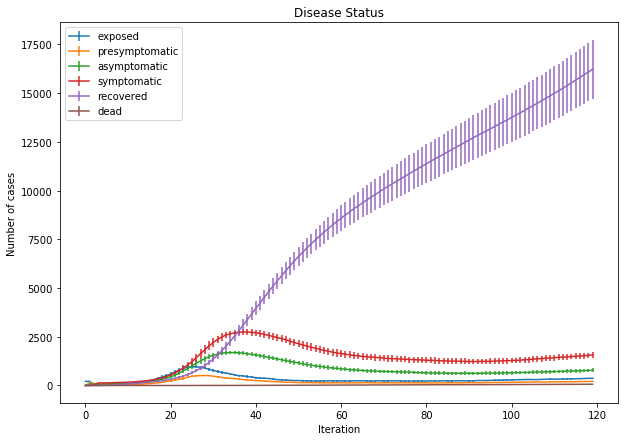

In [11]:
plot_summaries(summaries=summaries, plot_type="error_bars")

In [12]:
#plot_summaries(summaries=summaries, plot_type="lines")

### Disease statuses by age

In [13]:
  
def plot_disease_status_by_age(summaries):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(int(len(DiseaseStatus)/2), int(len(DiseaseStatus)/2), 
                           figsize=(15,11), tight_layout=True)
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)
    age_thresholds = summaries[0].age_thresholds

    for d, disease_status in enumerate(DiseaseStatus):
        lower_age_bound = 0
        for age_idx in range(len(age_thresholds)):
            matrix = np.zeros(shape=(reps, iters))
            for rep in range(reps):
                #matrix[age_idx][rep][it] = summaries[rep].age_counts[str(disease_status)][age_idx][it]
                matrix[rep] = summaries[rep].age_counts[str(disease_status)][age_idx]
            mean = np.mean(matrix, axis=0)
            sd = np.std(matrix, axis=0)
            ax.flat[d].errorbar(x, mean, sd, label=f"{lower_age_bound} - {age_thresholds[age_idx]}" )
            lower_age_bound = age_thresholds[age_idx]
                
            ax.flat[d].legend() 
            ax.flat[d].set_title(f"{str(disease_status)}")
            ax.flat[d].set_xlabel("Iteration")
            ax.flat[d].set_ylabel("Number of cases")
    #fig.set_title(f"Num {disease_status} people by age group")

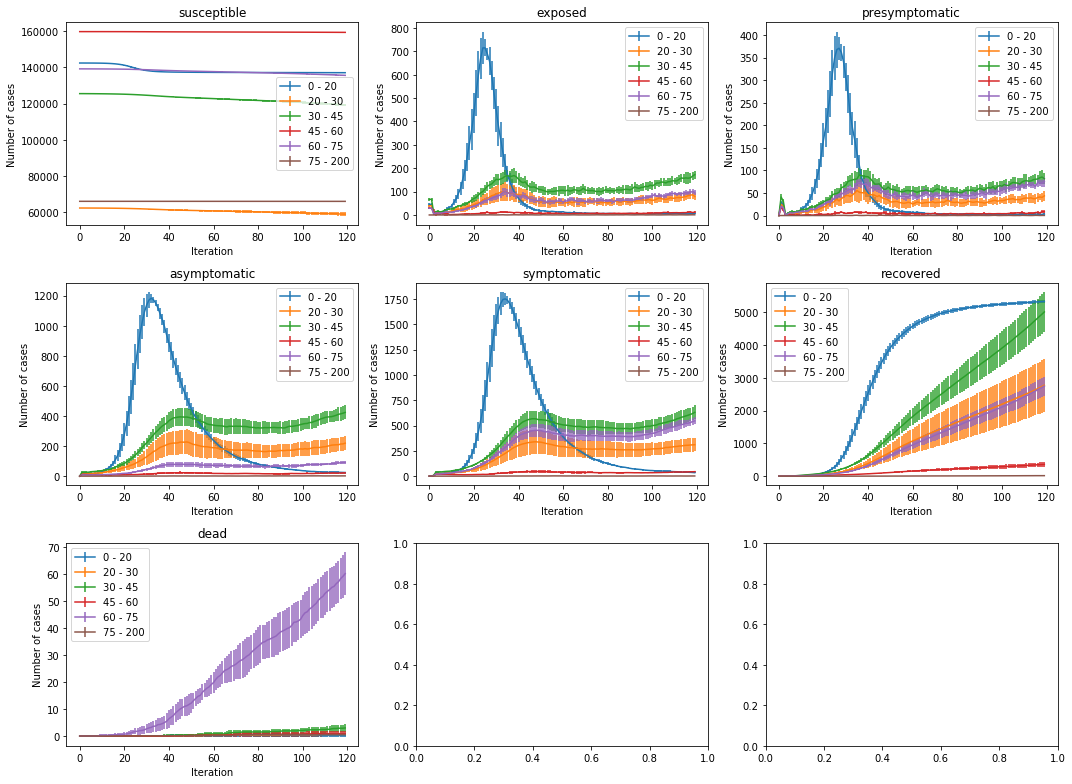

In [14]:
plot_disease_status_by_age(summaries)

### Plot MSOA geodata

#### Load MSOA shapes

Loading OSM buildings shapefile
Loaded 206583 buildings from shapefile
Loaded 7201 MSOA shapes with projection epsg:27700
Loaded 107 devon MSOA codes
Filtered 107 devon MSOA shapes


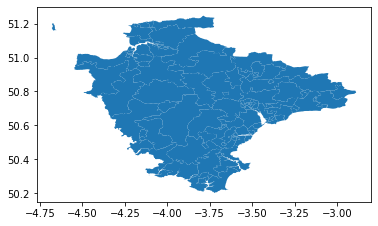

In [15]:
from microsim.load_msoa_locations import load_osm_shapefile, load_msoa_shapes
import pandas as pd

data_dir = ("../devon_data")

osm_buildings = load_osm_shapefile(data_dir)

devon_msoa_shapes = load_msoa_shapes(data_dir, visualize=False)

devon_msoa_shapes.plot()
plt.show()

In [16]:
import pandas as pd

def plot_msoa_choropleth(msoa_shapes, summary, disease_status, timestep):
    # get dataframes for all statuses
    msoa_data = summary.get_area_dataframes()
    
    msoa_data_for_status = msoa_data[disease_status]

    # add "Code" column so dataframes can be merged
    msoa_data_for_status["Code"] = msoa_data_for_status.index
    msoa_shapes = pd.merge(msoa_shapes, msoa_data_for_status, on="Code")

    msoa_shapes.plot(column=f"Day{timestep}", legend=True)
    plt.show()

### Plot disease status by MSOA for a given timestep and status

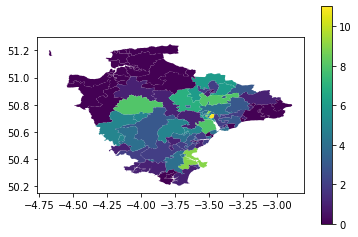

In [17]:
disease_status = "exposed"

plot_msoa_choropleth(devon_msoa_shapes, summaries[0], disease_status, 99)